<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [48]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v22.12.7
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# loss: 0.03

# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-01-26 22:39:34.298343: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_2891316/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

for device in gpu_devices:
    print(device)
#     tf.config.experimental.set_memory_growth(device, True)

2023-01-26 22:39:39.313507: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-26 22:39:39.357791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 22:39:39.359675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-26 22:39:39.359699: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-26 22:39:39.359748: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-26 22:39:39.359777: I tensorflow/stream_executor/platform/defa

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


 had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 22:39:39.452380: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0


# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum   version  \
_id                                                                           
6346a561172785f510f15e2a     db  1439eb4d76211bd57182395091226d86     3.0.0   
6285f9c04d1bfe5e5b297ddd     db  61cfee32867b371843d1e95a194ea2a6     3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
633ea99b9d08c565cfa1231e     db  e88212da6eb7e31a30a6fea422bc58dc     3.0.0   
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db   22.12.7   
...                         ...                               ...       ...   
63ce4a54e83d1ee490f3f768     db  d00f1640636bedb2ba695317bef25dc5  23.01.23   
635fa41bbf4cb23cbb3927ef     db  0112d13a24346dfa78688fd10df75288     3.0.0   
6380855a6a07f3e980b2c029     db  a9e8584be3cedcf52eeed3266ebe64e6     3.0.0   
5efe9280777d4b67a92d56ce   file  02a4101c17ceaa4b9d473f6840ac4d7a     2.0.0   
5f016dee777d4b67a92d5840   file  4ea9485a7c529809ed110d0c77f2e16f     2.0.0   

                                               export_date      len  \
_id                                                                   
6346a561172785f510f15e2a  2022-12-10 06:23:47.793876+00:00   6920.0   
6285f9c04d1bfe5e5b297ddd  2022-12-10 06:20:32.397698+00:00   5550.0   
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00   5840.0   
633ea99b9d08c565cfa1231e  2022-12-10 06:23:46.837617+00:00   6730.0   
6391b4771864c6df4d29f332  2022-12-11 06:49:28.432113+00:00   1990.0   
...                                                    ...      ...   
63ce4a54e83d1ee490f3f768  2023-01-25 19:05:50.210448+00:00   1730.0   
635fa41bbf4cb23cbb3927ef  2022-12-10 06:23:49.334879+00:00    890.0   
6380855a6a07f3e980b2c029  2022-12-10 06:24:01.383768+00:00   1240.0   
5efe9280777d4b67a92d56ce        2023-01-26 22:06:27.342288  14020.0   
5f016dee777d4b67a92d5840        2023-01-26 22:06:28.075890     20.0   

                                             analyze_date         value  \
_id                                                                       
6346a561172785f510f15e2a 2022-10-12 14:31:24.479000+00:00  1.000000e+09   
6285f9c04d1bfe5e5b297ddd 2022-05-19 11:03:36.611000+00:00  1.000000e+11   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
633ea99b9d08c565cfa1231e 2022-10-06 13:10:52.969000+00:00  5.000000e+10   
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
...                                                   ...           ...   
63ce4a54e83d1ee490f3f768 2023-01-23 19:17:25.627000+00:00           NaN   
635fa41bbf4cb23cbb3927ef 2022-10-31 13:33:24.683000+00:00           NaN   
6380855a6a07f3e980b2c029 2022-11-25 12:55:00.117000+00:00           NaN   
5efe9280777d4b67a92d56ce 2020-07-03 21:47:22.279000+00:00           NaN   
5f016dee777d4b67a92d5840 2020-07-05 14:13:31.165000+00:00           NaN   

                          value_log1p  value_span currency  ... valid  \
_id                                                         ...         
6346a561172785f510f15e2a    20.723266      1922.0      RUB  ...  True   
6285f9c04d1bfe5e5b297ddd    25.328436      1505.0      NaN  ...  True   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...  True   
633ea99b9d08c565cfa1231e    24.635289       401.0      RUB  ...  True   
6391b4771864c6df4d29f332    25.328436       483.0      RUB  ...  True   
...                               ...         ...      ...  ...   ...   
63ce4a54e83d1ee490f3f768          NaN         NaN      NaN  ...  True   
635fa41bbf4cb23cbb3927ef          NaN         NaN      NaN  ...  True   
6380855a6a07f3e980b2c029          NaN         NaN      NaN  ...  True   
5efe9280777d4b67a92d56ce          NaN         NaN      NaN  ...  True   
5f016dee777d4b67a92d5840          NaN         NaN      NaN  ...  True   

                         documentType  \
_id                                     
6346a561172785f510f15e2a    AGREEMENT   
6285f9c04d1bfe5e5b297ddd

In [17]:
print(len(stats))

2697


In [18]:
from trainsets.trainset_tools import get_feature_log_weights
get_feature_log_weights(umtm.stats, 'subject')

Service                              0.462540
Deal                                 0.580688
Other                                0.601987
Renting                              0.697076
GeneralContract                      0.703019
Loans                                0.727723
AgencyContract                       0.794902
DealIntellectualProperty             0.806274
Charity                              0.864814
Insurance                            0.894847
RealEstate                           0.989563
RealEstateTransactions               1.187944
PledgeEncumbrance                    1.312190
ParticipationInOtherOrganizations    1.312190
BankGuarantees                       1.354457
SecuritiesTransactions               1.618559
AssetTransactions                    2.091227
Name: subject, dtype: float64

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [19]:
from trainsets.trainset_tools import get_feature_log_weights

stats = umtm.stats
subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights *= subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

subject_weights

1.0
1.0
0.0208047451138797
0.24572981977123073
5.5533274071318965
6.100419992262355


Service                              0.213943
Deal                                 0.337198
Other                                0.362388
Renting                              0.485914
GeneralContract                      0.494236
Loans                                0.529581
AgencyContract                       0.631869
DealIntellectualProperty             0.650078
Charity                              0.747903
Insurance                            0.800752
RealEstate                           0.979235
RealEstateTransactions               1.411212
PledgeEncumbrance                    1.721841
ParticipationInOtherOrganizations    1.721841
BankGuarantees                       1.834554
SecuritiesTransactions               2.619735
AssetTransactions                    4.373230
Name: subject, dtype: float64

In [20]:
from tf_support.super_contract_model import make_xyw

# from functools import lru_cache

# def _dp_fn(doc_id, suffix):
#     return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')



# @lru_cache(maxsize=72)
# def make_xyw(doc_id):

#     row = stats.loc[doc_id]

#     _subj = row['subject']
#     subject_one_hot = ContractSubject.encode_1_hot()[_subj]

#     embeddings =     np.load(_dp_fn(doc_id, 'embeddings'))
#     token_features = np.load(_dp_fn(doc_id, 'token_features'))
#     semantic_map =   np.load(_dp_fn(doc_id, 'semantic_map'))

#     if embeddings.shape[0] != token_features.shape[0]:
#       msg = f'{doc_id} embeddings.shape {embeddings.shape} is incompatible with token_features.shape {token_features.shape}'
#       raise AssertionError(msg)

#     if embeddings.shape[0] != semantic_map.shape[0]:
#       msg = f'{doc_id} embeddings.shape {embeddings.shape} is incompatible with semantic_map.shape {semantic_map.shape}'
#       raise AssertionError(msg)

#     stats.at[doc_id, 'error'] = None
    
#     return (
#       (embeddings, token_features),
#       (semantic_map, subject_one_hot),
#       (row['sample_weight'], row['subject_weight']))

# Validating training set

In [21]:
%%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]
del stats
print(len(stats_valid))
umtm.stats = stats = stats_valid

ERROR - 2023-01-26 22:39:42,631 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbe469a2b4551c06107b5f-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:46,735 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb674f833c72547b754ff75-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:46,879 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb674fd33c72547b754ffdf-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:47,496 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5e5de70c01c6c73c19eebd41-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:51,007 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506abe2456d59975e0f8a-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:52,232 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbbd14a2b4551c061078ed-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:52,448 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fc5eb6c1d0a1603c7a0c8bc-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:52,851 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb6750133c72547b755003d-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:53,667 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb3d7a178df3635f5441d6e-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:54,386 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506b6e2456d59975e1065-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:55,591 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506e3e2456d59975e151b-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:56,207 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63ce4af2e83d1ee490f3fee8-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:56,535 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63ce4af9e83d1ee490f3ff88-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:57,157 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbbd1aa2b4551c061079f9-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:57,925 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506bae2456d59975e10c2-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:57,975 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506cfe2456d59975e1312-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:58,909 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506dfe2456d59975e14b5-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:58,964 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506d0e2456d59975e1318-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:59,298 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5edbc630da3678279fbcadfa-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:59,471 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbbd13a2b4551c061078d2-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:59,485 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbad2ba2b4551c0610782a-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:59,681 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbbd19a2b4551c061079b7-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:59,710 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/634e5a5161d29d0c233eec9a-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:39:59,755 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb674fc33c72547b754ffb6-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:00,145 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb674f833c72547b754ff71-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:02,125 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbbd19a2b4551c0610799e-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:03,588 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fca2ab09083b679224c762b-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:03,934 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbe46da2b4551c06107c81-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:05,669 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506e2e2456d59975e150b-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:05,782 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/616438a187f1d9065bb8b8ea-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:06,028 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/6163e8e487f1d9065bb8b8d8-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:06,260 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/616438b187f1d9065bb8b8ec-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:07,634 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506d3e2456d59975e1377-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:08,023 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5ed2fce89305fa48fa28b34e-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:08,597 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbe46ba2b4551c06107bf8-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:10,110 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fe4821ab770574a00555619-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:10,207 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb6750533c72547b7550094-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:10,321 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb6750a33c72547b755010b-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:10,789 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63ce49f1e83d1ee490f3f19e-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:11,316 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb3d49e78df3635f5441bbd-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:11,337 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506c2e2456d59975e11af-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:11,868 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506bbe2456d59975e10e7-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:11,974 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb6750533c72547b7550099-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:12,112 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506b0e2456d59975e0fdc-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:12,137 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506b5e2456d59975e1044-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:12,159 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506cfe2456d59975e130f-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:12,531 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/638085566a07f3e980b2bfd1-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:12,891 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/6380855c6a07f3e980b2c06a-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:13,377 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63ce4af4e83d1ee490f3ff12-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:13,403 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63ce4af5e83d1ee490f3ff2c-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:13,745 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb6750933c72547b75500f6-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:15,772 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63ce4af5e83d1ee490f3ff30-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:15,792 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63ce4af2e83d1ee490f3feed-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:16,745 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/6380855c6a07f3e980b2c053-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:16,819 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5ee188892281f29204c52297-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:17,160 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506c7e2456d59975e122a-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:18,251 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/638085ac6a07f3e980b2c71a-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:18,253 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506b2e2456d59975e1010-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:18,373 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506e2e2456d59975e150c-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:18,374 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506e2e2456d59975e1501-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:18,393 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/635fa41bbf4cb23cbb3927ef-datapoint-embeddings.npy'


ERROR - 2023-01-26 22:40:18,394 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/6380855a6a07f3e980b2c029-datapoint-embeddings.npy'


2635
CPU times: user 2.83 s, sys: 10.6 s, total: 13.4 s
Wall time: 38 s


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [22]:
len(stats_valid)

2635

In [23]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()


print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MEAN\t', stats.sample_weight.mean())


1.0159143590127713
1.0018614830628396
0.9999999999999998
0.24527324777473042


sample_weight
MIN	 0.02047883754108663
MEAN	 1.0


/root/artem/env/lib/python3.8/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


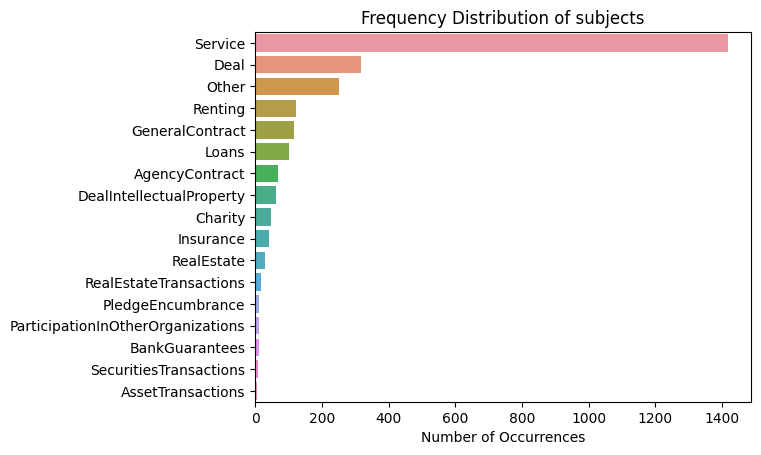


min 4
max 1417
total 2635


In [24]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [25]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['Loans', 'SecuritiesTransactions', 'GeneralContract', 'BankGuarantees', 'Service', 'Charity', 'PledgeEncumbrance', 'AgencyContract', 'Renting', 'Deal', 'DealIntellectualProperty', 'AssetTransactions', 'ParticipationInOtherOrganizations', 'Insurance', 'RealEstateTransactions', 'Other', 'RealEstate']


Service                              0.463051
Deal                                 0.582871
Other                                0.607288
Renting                              0.699489
GeneralContract                      0.704377
Loans                                0.728120
AgencyContract                       0.796387
DealIntellectualProperty             0.811067
Charity                              0.863442
Insurance                            0.893428
RealEstate                           0.987994
RealEstateTransactions               1.186060
PledgeEncumbrance                    1.310108
ParticipationInOtherOrganizations    1.310108
BankGuarantees                       1.352309
SecuritiesTransactions               1.615992
AssetTransactions                    2.087910
Name: subject, dtype: float64

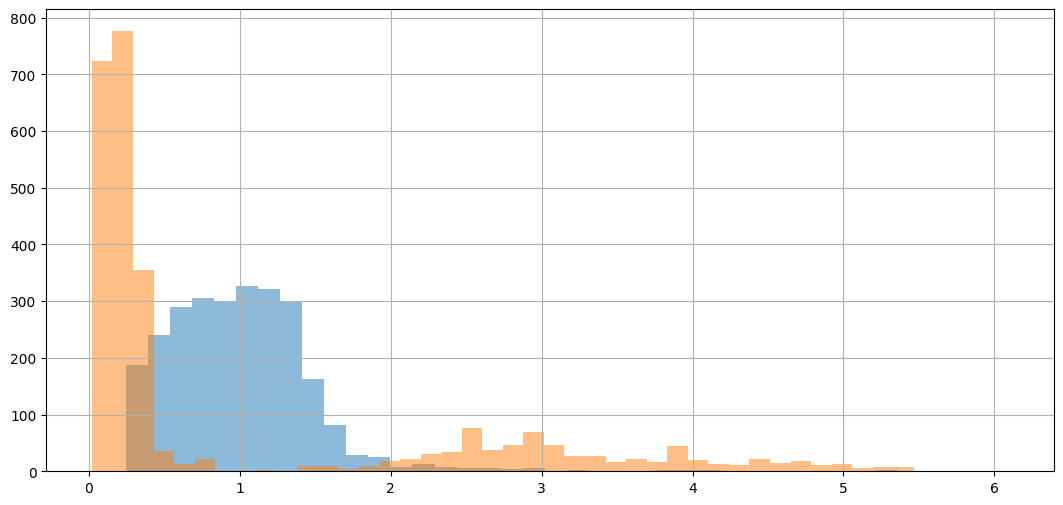

In [26]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

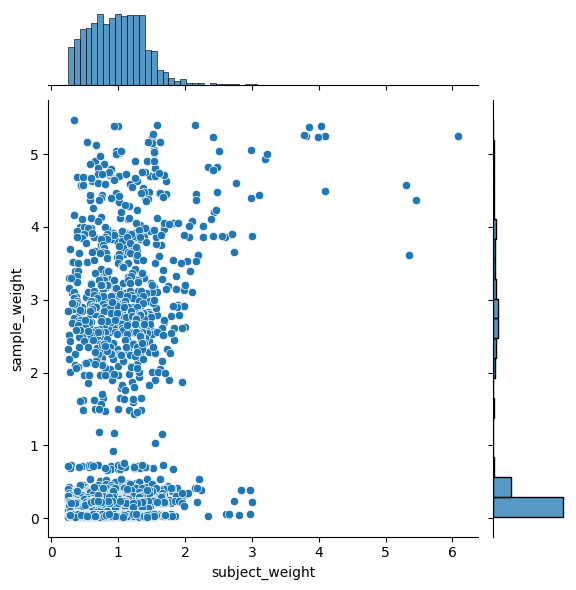

In [27]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 6285f9c04d1bfe5e5b297ddd
semantic map shape is: (5556, 30)


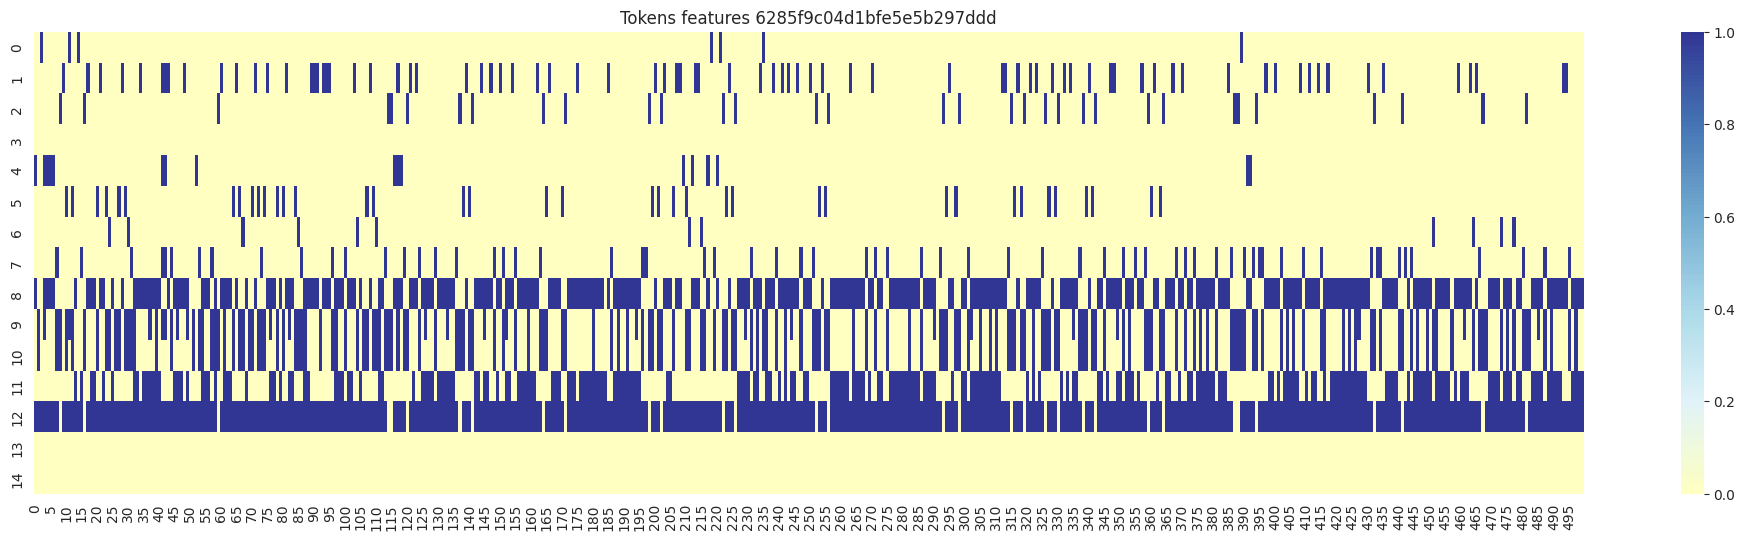

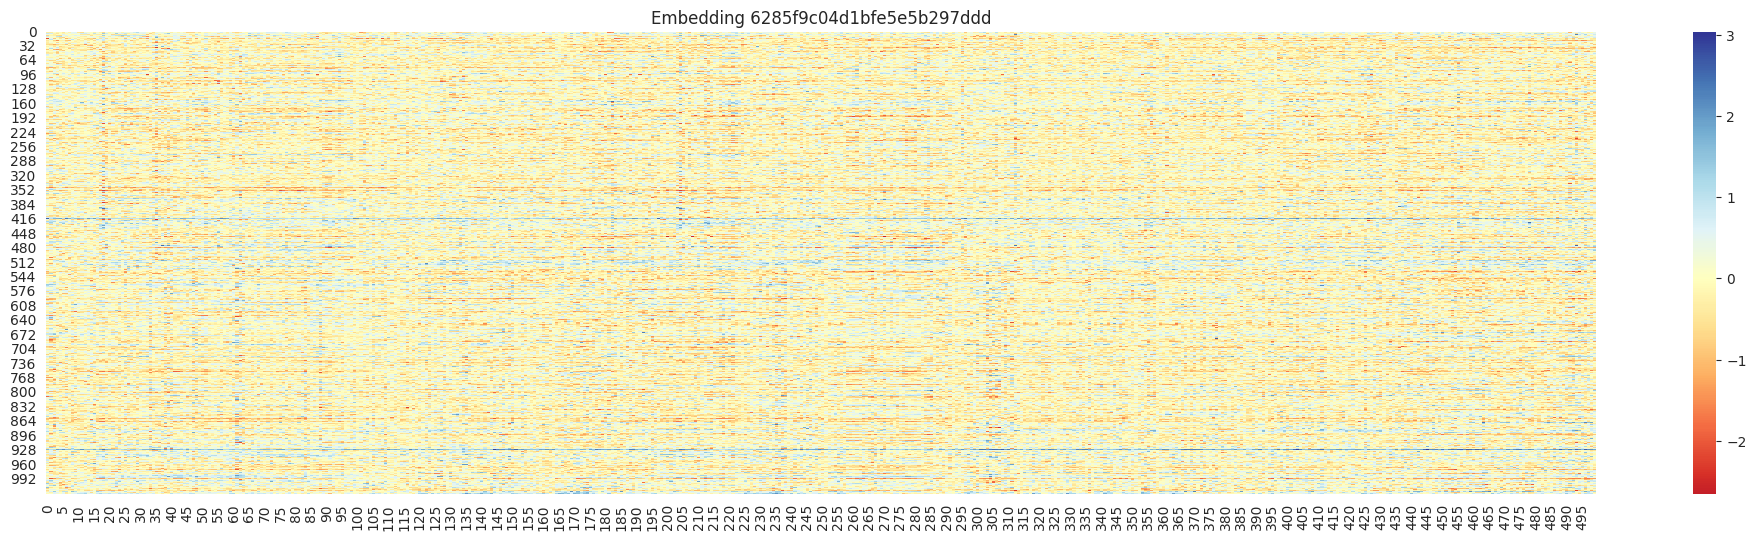

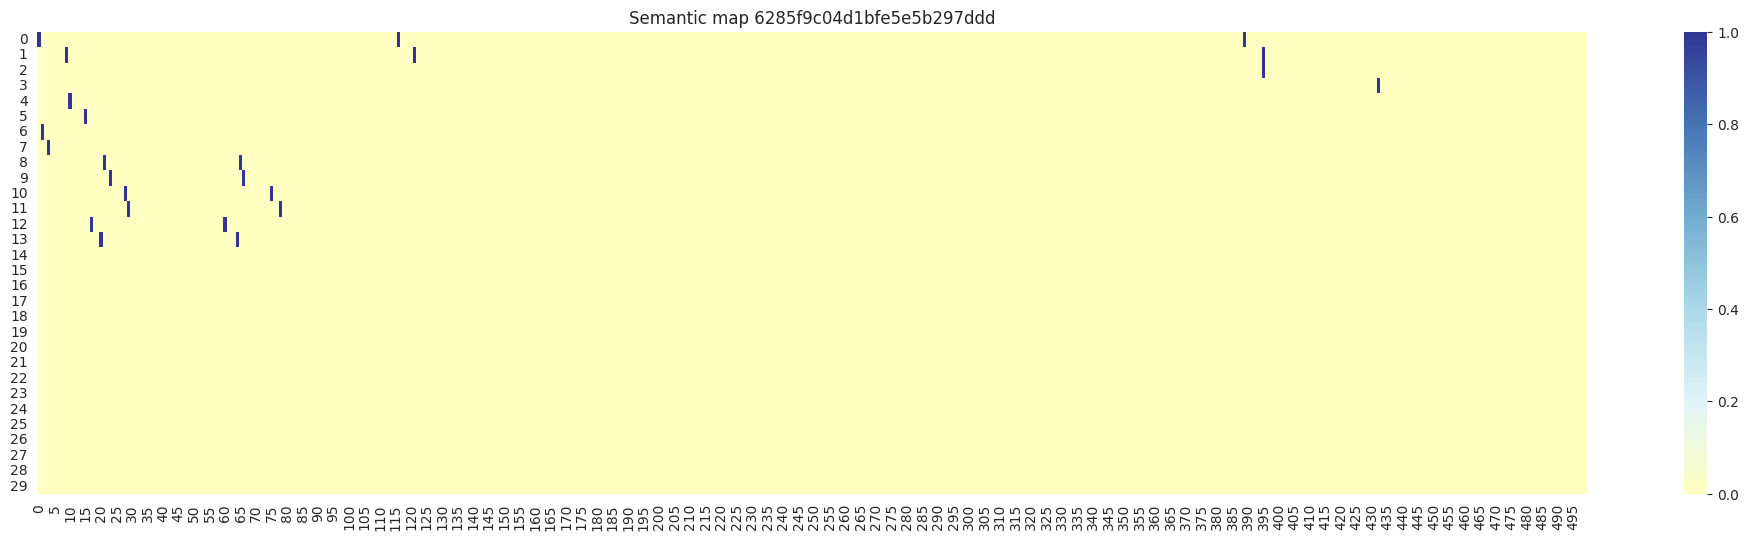

In [28]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

In [29]:
stats_valid = stats_valid[stats_valid.documentType != 'ANNEX']

3
semantic map shape is: (14, 896, 30)


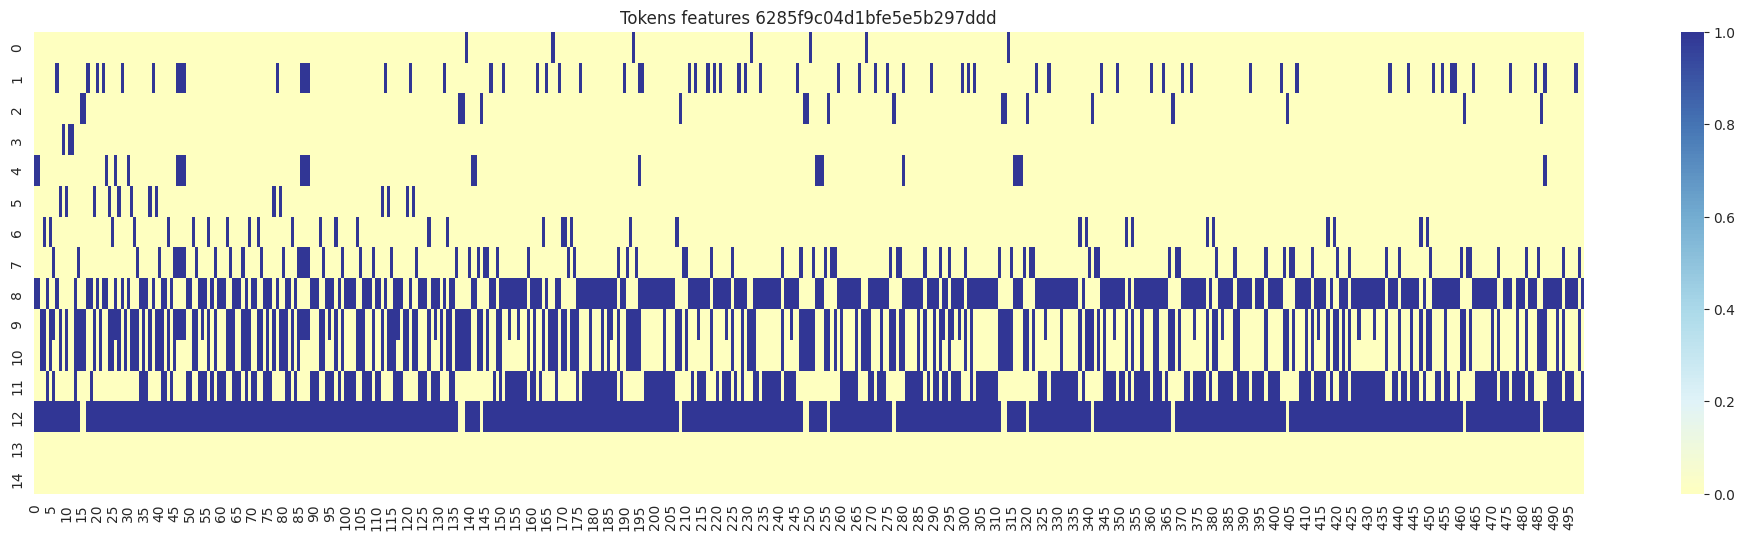

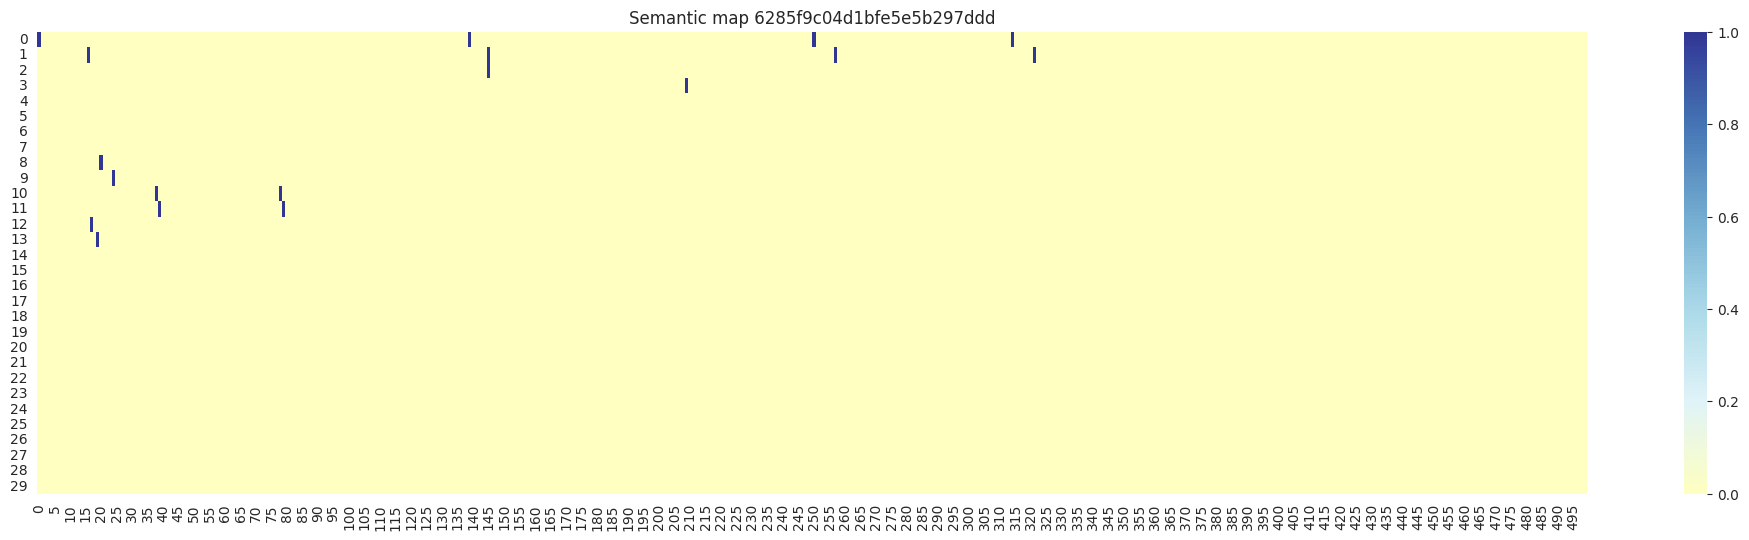

In [30]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map {SAMPLE_DOC_ID}')

train_indices[0]: 5ee372b62281f29204c52565
test_indices[0]: 5fb6750833c72547b75500d7


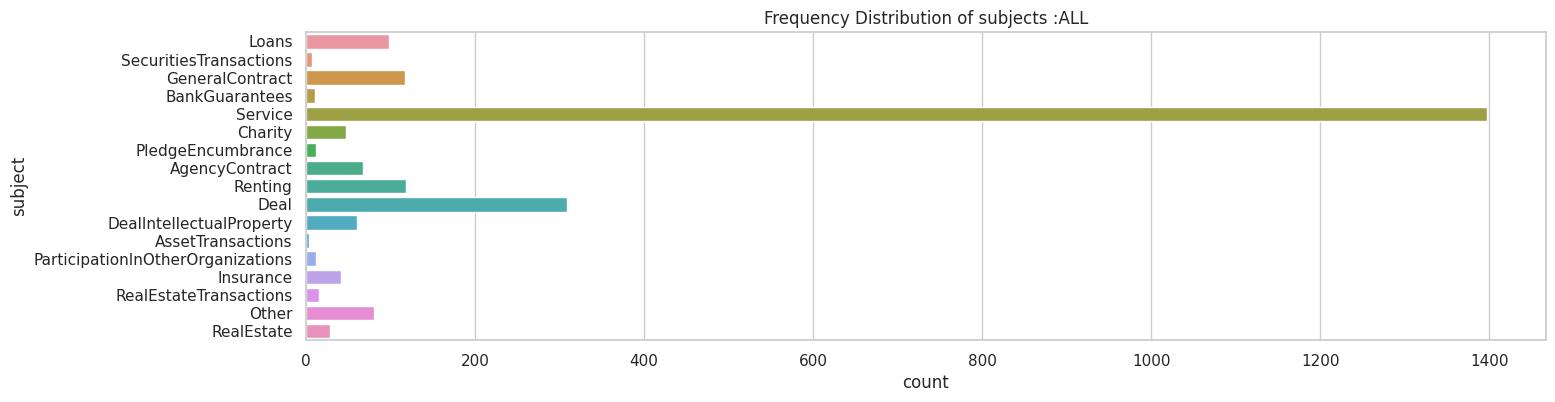

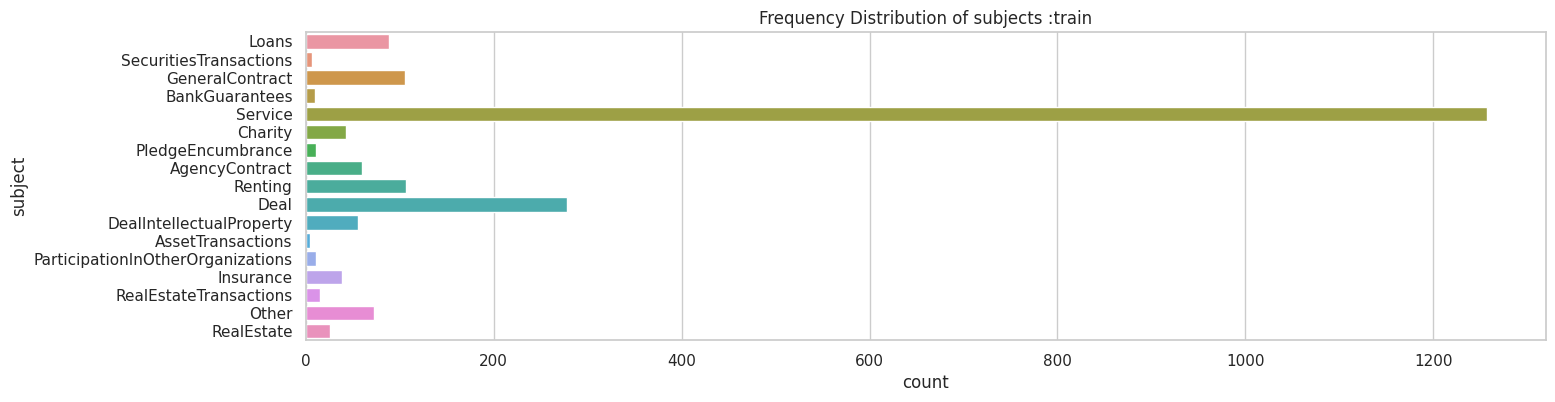

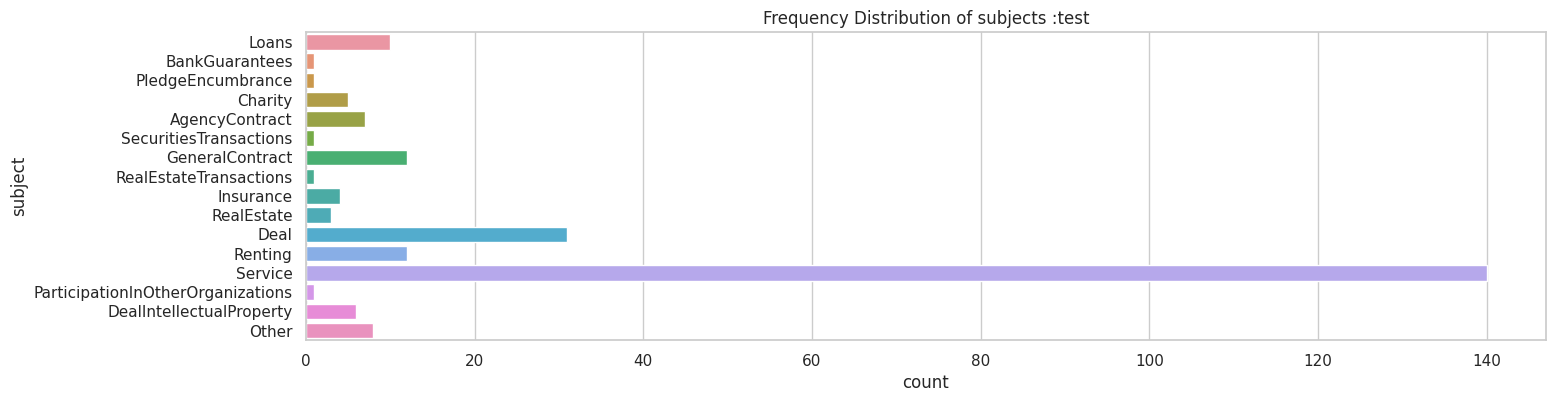

In [31]:
EPOCHS = 50
BATCH_SIZE = 128
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [32]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	128
train_samples:	8748
test_samples:	243
steps_per_epoch:	68
validation_steps:	34


# Models 🦖

In [33]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [34]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [35]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [36]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [37]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## uber_detection_model_005
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [38]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 2
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [39]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


2023-01-26 22:40:28.829833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 22:40:28.830771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 22:40:28.831437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-26 22:40:28.831500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [40]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 10
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


model.name == uber_detection_model_005_1_1
continue: lr:0.0010000000474974513, epoch:0


2023-01-26 22:40:32.138200: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-26 22:40:32.161940: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/10


2023-01-26 22:40:36.087017: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-01-26 22:40:37.477255: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


2023-01-26 22:40:38.390725: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-26 22:40:38.391019: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2023-01-26 22:40:38.720037: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 1/68 [..............................] - ETA: 8:04 - loss: 0.0369 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0253 - O1_tagging_kullback_leibler_divergence: 0.2292 - O1_tagging_mse: 5.9447e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.8731 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0318

 2/68 [..............................] - ETA: 27s - loss: 0.0343 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.1958 - O1_tagging_mse: 5.1583e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.7516 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0287 

 3/68 [>.............................] - ETA: 49s - loss: 0.0317 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.1850 - O1_tagging_mse: 4.9099e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.7886 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0299

 4/68 [>.............................] - ETA: 1:01 - loss: 0.0310 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.1786 - O1_tagging_mse: 4.6856e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_kullback_leibler_divergence: 0.7982 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0306

 5/68 [=>............................] - ETA: 1:00 - loss: 0.0323 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0230 - O1_tagging_kullback_leibler_divergence: 0.1816 - O1_tagging_mse: 4.7717e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.8061 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

 6/68 [=>............................] - ETA: 59s - loss: 0.0327 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0237 - O1_tagging_kullback_leibler_divergence: 0.1857 - O1_tagging_mse: 4.8965e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.7977 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0305 

 7/68 [==>...........................] - ETA: 1:03 - loss: 0.0321 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.1941 - O1_tagging_mse: 5.1336e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.7621 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0295

 8/68 [==>...........................] - ETA: 1:03 - loss: 0.0320 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.1996 - O1_tagging_mse: 5.2768e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.7749 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

 9/68 [==>...........................] - ETA: 1:03 - loss: 0.0318 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.4365e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7726 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0296

10/68 [===>..........................] - ETA: 1:01 - loss: 0.0316 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.6349e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7859 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0299

11/68 [===>..........................] - ETA: 58s - loss: 0.0324 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.8632e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7888 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0302 

12/68 [====>.........................] - ETA: 57s - loss: 0.0324 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 6.0036e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7981 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0304

13/68 [====>.........................] - ETA: 1:04 - loss: 0.0320 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.8230e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7888 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0303

14/68 [=====>........................] - ETA: 1:05 - loss: 0.0319 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.8806e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7807 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0300

15/68 [=====>........................] - ETA: 1:03 - loss: 0.0320 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.9210e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7824 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0301

16/68 [======>.......................] - ETA: 1:01 - loss: 0.0319 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.2281 - O1_tagging_mse: 6.0387e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7900 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0302

17/68 [======>.......................] - ETA: 59s - loss: 0.0318 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2312 - O1_tagging_mse: 6.1257e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7896 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0302 

18/68 [======>.......................] - ETA: 58s - loss: 0.0321 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 6.1855e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7982 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0304

19/68 [=======>......................] - ETA: 58s - loss: 0.0318 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.2354 - O1_tagging_mse: 6.2493e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7923 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0303

20/68 [=======>......................] - ETA: 58s - loss: 0.0316 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.2331 - O1_tagging_mse: 6.1912e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7822 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0300

21/68 [========>.....................] - ETA: 57s - loss: 0.0320 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2336 - O1_tagging_mse: 6.2026e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7885 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0301

22/68 [========>.....................] - ETA: 56s - loss: 0.0322 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2328 - O1_tagging_mse: 6.1812e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7877 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0302

23/68 [=========>....................] - ETA: 54s - loss: 0.0328 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.2350 - O1_tagging_mse: 6.2353e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.8057 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0307

24/68 [=========>....................] - ETA: 56s - loss: 0.0324 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 6.1195e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7923 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0303

25/68 [==========>...................] - ETA: 54s - loss: 0.0321 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2314 - O1_tagging_mse: 6.1408e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7812 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0300

26/68 [==========>...................] - ETA: 53s - loss: 0.0321 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2337 - O1_tagging_mse: 6.2002e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7760 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

27/68 [==========>...................] - ETA: 52s - loss: 0.0324 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2368 - O1_tagging_mse: 6.2763e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7775 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0299

28/68 [===========>..................] - ETA: 51s - loss: 0.0323 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2377 - O1_tagging_mse: 6.3011e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7730 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

29/68 [===========>..................] - ETA: 49s - loss: 0.0322 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2395 - O1_tagging_mse: 6.3446e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.7691 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

30/68 [============>.................] - ETA: 48s - loss: 0.0322 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2418 - O1_tagging_mse: 6.4074e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.7674 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

31/68 [============>.................] - ETA: 49s - loss: 0.0321 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2381 - O1_tagging_mse: 6.3026e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.7674 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

32/68 [=============>................] - ETA: 49s - loss: 0.0322 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2343 - O1_tagging_mse: 6.1928e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7689 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

33/68 [=============>................] - ETA: 47s - loss: 0.0320 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2310 - O1_tagging_mse: 6.1167e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7642 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0296

34/68 [==============>...............] - ETA: 45s - loss: 0.0320 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2327 - O1_tagging_mse: 6.1645e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7670 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0296

35/68 [==============>...............] - ETA: 44s - loss: 0.0320 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2342 - O1_tagging_mse: 6.2050e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7641 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0296

36/68 [==============>...............] - ETA: 42s - loss: 0.0321 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2327 - O1_tagging_mse: 6.1659e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7613 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0296

37/68 [===============>..............] - ETA: 41s - loss: 0.0322 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2331 - O1_tagging_mse: 6.1811e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7640 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0296

38/68 [===============>..............] - ETA: 39s - loss: 0.0324 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.2349 - O1_tagging_mse: 6.2288e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7708 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

39/68 [================>.............] - ETA: 37s - loss: 0.0324 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.2364 - O1_tagging_mse: 6.2686e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7700 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

40/68 [================>.............] - ETA: 36s - loss: 0.0323 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2351 - O1_tagging_mse: 6.2414e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7669 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

41/68 [=================>............] - ETA: 34s - loss: 0.0321 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2352 - O1_tagging_mse: 6.2526e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7638 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0296

42/68 [=================>............] - ETA: 33s - loss: 0.0319 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2350 - O1_tagging_mse: 6.2556e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7585 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0295

43/68 [=================>............] - ETA: 32s - loss: 0.0319 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 6.1851e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7598 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0294

44/68 [==================>...........] - ETA: 31s - loss: 0.0318 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 6.1695e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0293

45/68 [==================>...........] - ETA: 29s - loss: 0.0317 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 6.1869e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0293

46/68 [===================>..........] - ETA: 28s - loss: 0.0317 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2320 - O1_tagging_mse: 6.1791e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7579 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0294

47/68 [===================>..........] - ETA: 27s - loss: 0.0316 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 6.1094e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0293

48/68 [====================>.........] - ETA: 26s - loss: 0.0317 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 6.1161e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7582 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0293

49/68 [====================>.........] - ETA: 25s - loss: 0.0316 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2284 - O1_tagging_mse: 6.0870e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7553 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0292

50/68 [=====================>........] - ETA: 23s - loss: 0.0317 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 6.0479e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7545 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

51/68 [=====================>........] - ETA: 22s - loss: 0.0318 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 6.0696e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7531 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

52/68 [=====================>........] - ETA: 21s - loss: 0.0316 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 6.0184e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7500 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

53/68 [======================>.......] - ETA: 19s - loss: 0.0315 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.9781e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7493 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

54/68 [======================>.......] - ETA: 18s - loss: 0.0316 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 6.0012e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7549 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

55/68 [=======================>......] - ETA: 17s - loss: 0.0314 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.9911e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7547 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

56/68 [=======================>......] - ETA: 15s - loss: 0.0314 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.9743e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

57/68 [========================>.....] - ETA: 14s - loss: 0.0314 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.9333e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7564 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

58/68 [========================>.....] - ETA: 13s - loss: 0.0314 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.9549e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7543 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

59/68 [=========================>....] - ETA: 11s - loss: 0.0315 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.9927e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7572 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

60/68 [=========================>....] - ETA: 10s - loss: 0.0315 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 6.0256e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

61/68 [=========================>....] - ETA: 9s - loss: 0.0315 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 6.0518e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7539 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292 

62/68 [==========================>...] - ETA: 7s - loss: 0.0316 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 6.0196e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7527 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

63/68 [==========================>...] - ETA: 6s - loss: 0.0315 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 6.0171e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7513 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

64/68 [===========================>..] - ETA: 5s - loss: 0.0316 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 6.0168e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

65/68 [===========================>..] - ETA: 3s - loss: 0.0317 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2270 - O1_tagging_mse: 6.0478e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7523 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

66/68 [============================>.] - ETA: 2s - loss: 0.0317 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 6.0140e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7546 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

67/68 [============================>.] - ETA: 1s - loss: 0.0316 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.9887e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

68/68 [==============================] - ETA: 0s - loss: 0.0317 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.9561e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7563 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

68/68 [==============================] - 151s 2s/step - loss: 0.0317 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.9561e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7563 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292 - val_loss: 0.0385 - val_O1_tagging_loss: 0.0082 - val_O2_subject_loss: 0.0302 - val_O1_tagging_kullback_leibler_divergence: 0.1783 - val_O1_tagging_mse: 4.3145e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.6345 - val_O2_subject_mse: 0.0059 - val_O2_subject_binary_crossentropy: 0.0235



Epoch 00001: val_loss improved from inf to 0.03845, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 2/10


 1/68 [..............................] - ETA: 25s - loss: 0.0238 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.1592 - O1_tagging_mse: 4.4661e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_kullback_leibler_divergence: 0.6351 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0266

 2/68 [..............................] - ETA: 1:55 - loss: 0.0325 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0235 - O1_tagging_kullback_leibler_divergence: 0.1950 - O1_tagging_mse: 5.3304e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.8027 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0298

 3/68 [>.............................] - ETA: 1:46 - loss: 0.0356 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.2312 - O1_tagging_mse: 6.2444e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.8088 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0305

 4/68 [>.............................] - ETA: 2:01 - loss: 0.0378 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 5.4835e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.8820 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0319

 5/68 [=>............................] - ETA: 1:58 - loss: 0.0348 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0237 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 5.4669e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.8131 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0303

 6/68 [=>............................] - ETA: 1:54 - loss: 0.0325 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.6734e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7567 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

 7/68 [==>...........................] - ETA: 1:51 - loss: 0.0333 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.9602e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7459 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

 8/68 [==>...........................] - ETA: 1:47 - loss: 0.0332 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.9752e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7624 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

 9/68 [==>...........................] - ETA: 1:41 - loss: 0.0331 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.2357 - O1_tagging_mse: 6.2537e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7372 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

10/68 [===>..........................] - ETA: 1:38 - loss: 0.0326 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2410 - O1_tagging_mse: 6.3976e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.7164 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

11/68 [===>..........................] - ETA: 1:43 - loss: 0.0316 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 6.0626e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7007 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275

12/68 [====>.........................] - ETA: 1:40 - loss: 0.0325 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.2370 - O1_tagging_mse: 6.2436e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.7031 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0277

13/68 [====>.........................] - ETA: 1:40 - loss: 0.0324 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 6.0907e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7152 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

14/68 [=====>........................] - ETA: 1:42 - loss: 0.0318 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.8885e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7062 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

15/68 [=====>........................] - ETA: 1:38 - loss: 0.0315 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.8746e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7096 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

16/68 [======>.......................] - ETA: 1:36 - loss: 0.0311 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.7948e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7077 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

17/68 [======>.......................] - ETA: 1:34 - loss: 0.0311 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.7532e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7070 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

18/68 [======>.......................] - ETA: 1:30 - loss: 0.0318 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.9014e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7122 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0281

19/68 [=======>......................] - ETA: 1:31 - loss: 0.0317 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.8868e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7272 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

20/68 [=======>......................] - ETA: 1:29 - loss: 0.0315 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.8493e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

21/68 [========>.....................] - ETA: 1:26 - loss: 0.0314 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.8845e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7266 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

22/68 [========>.....................] - ETA: 1:24 - loss: 0.0311 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.8547e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

23/68 [=========>....................] - ETA: 1:22 - loss: 0.0310 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.8645e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0283

24/68 [=========>....................] - ETA: 1:21 - loss: 0.0309 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.8554e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7188 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

25/68 [==========>...................] - ETA: 1:18 - loss: 0.0310 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.8746e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7164 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0281

26/68 [==========>...................] - ETA: 1:17 - loss: 0.0308 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.8479e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

27/68 [==========>...................] - ETA: 1:16 - loss: 0.0309 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.8221e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7155 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

28/68 [===========>..................] - ETA: 1:14 - loss: 0.0309 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.8865e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7144 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0281

29/68 [===========>..................] - ETA: 1:12 - loss: 0.0309 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.8803e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7203 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

30/68 [============>.................] - ETA: 1:10 - loss: 0.0310 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.8784e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7219 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0283

31/68 [============>.................] - ETA: 1:08 - loss: 0.0311 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.9382e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7225 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

32/68 [=============>................] - ETA: 1:06 - loss: 0.0310 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.8694e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

33/68 [=============>................] - ETA: 1:04 - loss: 0.0311 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.9358e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7212 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

34/68 [==============>...............] - ETA: 1:02 - loss: 0.0310 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.9203e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7164 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

35/68 [==============>...............] - ETA: 1:00 - loss: 0.0310 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.9499e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7235 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

36/68 [==============>...............] - ETA: 58s - loss: 0.0308 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.9183e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7226 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284 

37/68 [===============>..............] - ETA: 56s - loss: 0.0309 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.9720e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7235 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

38/68 [===============>..............] - ETA: 53s - loss: 0.0315 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2273 - O1_tagging_mse: 6.0356e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

39/68 [================>.............] - ETA: 51s - loss: 0.0315 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 6.0951e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7272 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

40/68 [================>.............] - ETA: 49s - loss: 0.0314 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 6.0567e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7272 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

41/68 [=================>............] - ETA: 47s - loss: 0.0312 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 6.0451e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7273 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

42/68 [=================>............] - ETA: 46s - loss: 0.0310 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.9654e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7262 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

43/68 [=================>............] - ETA: 45s - loss: 0.0310 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.8983e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7262 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

44/68 [==================>...........] - ETA: 42s - loss: 0.0310 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.9345e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7225 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0283

45/68 [==================>...........] - ETA: 41s - loss: 0.0310 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.9447e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7229 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0283

46/68 [===================>..........] - ETA: 39s - loss: 0.0312 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.9851e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7265 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

47/68 [===================>..........] - ETA: 37s - loss: 0.0313 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 6.0127e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7297 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

48/68 [====================>.........] - ETA: 35s - loss: 0.0314 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2286 - O1_tagging_mse: 6.0656e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7307 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

49/68 [====================>.........] - ETA: 33s - loss: 0.0317 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2292 - O1_tagging_mse: 6.0767e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

50/68 [=====================>........] - ETA: 31s - loss: 0.0317 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 6.1186e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7303 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

51/68 [=====================>........] - ETA: 29s - loss: 0.0318 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2319 - O1_tagging_mse: 6.1497e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7338 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

52/68 [=====================>........] - ETA: 28s - loss: 0.0320 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2335 - O1_tagging_mse: 6.1935e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7351 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0287

53/68 [======================>.......] - ETA: 26s - loss: 0.0320 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2352 - O1_tagging_mse: 6.2381e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7353 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0287

54/68 [======================>.......] - ETA: 24s - loss: 0.0319 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2358 - O1_tagging_mse: 6.2528e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

55/68 [=======================>......] - ETA: 22s - loss: 0.0319 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2336 - O1_tagging_mse: 6.1909e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

56/68 [=======================>......] - ETA: 21s - loss: 0.0317 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 6.1349e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

57/68 [========================>.....] - ETA: 19s - loss: 0.0316 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2308 - O1_tagging_mse: 6.1116e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7275 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

58/68 [========================>.....] - ETA: 17s - loss: 0.0316 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2305 - O1_tagging_mse: 6.1088e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

59/68 [=========================>....] - ETA: 15s - loss: 0.0316 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 6.0924e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

60/68 [=========================>....] - ETA: 14s - loss: 0.0315 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 6.0662e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

61/68 [=========================>....] - ETA: 12s - loss: 0.0314 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 6.0288e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7283 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

62/68 [==========================>...] - ETA: 10s - loss: 0.0313 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.9729e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7301 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

63/68 [==========================>...] - ETA: 8s - loss: 0.0315 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 6.0107e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7326 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286 

64/68 [===========================>..] - ETA: 7s - loss: 0.0317 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2288 - O1_tagging_mse: 6.0486e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7363 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

65/68 [===========================>..] - ETA: 5s - loss: 0.0317 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 6.0700e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7334 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

66/68 [============================>.] - ETA: 3s - loss: 0.0316 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 6.0985e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7323 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

67/68 [============================>.] - ETA: 1s - loss: 0.0316 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 6.0762e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

68/68 [==============================] - ETA: 0s - loss: 0.0316 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 6.0487e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7359 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

68/68 [==============================] - 168s 3s/step - loss: 0.0316 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 6.0487e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.7359 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286 - val_loss: 0.0337 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0262 - val_O1_tagging_kullback_leibler_divergence: 0.1746 - val_O1_tagging_mse: 4.2908e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_kullback_leibler_divergence: 0.5334 - val_O2_subject_mse: 0.0050 - val_O2_subject_binary_crossentropy: 0.0207



Epoch 00002: val_loss improved from 0.03845 to 0.03366, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 3/10


 1/68 [..............................] - ETA: 12s - loss: 0.0363 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.3077 - O1_tagging_mse: 8.2248e-04 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 0.5473 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0244

 2/68 [..............................] - ETA: 2:57 - loss: 0.0341 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 6.0349e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6630 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

 3/68 [>.............................] - ETA: 2:32 - loss: 0.0322 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.1891e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6515 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

 4/68 [>.............................] - ETA: 2:36 - loss: 0.0311 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.1914 - O1_tagging_mse: 4.8704e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.6432 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

 5/68 [=>............................] - ETA: 2:22 - loss: 0.0311 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.1969 - O1_tagging_mse: 5.0407e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6668 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

 6/68 [=>............................] - ETA: 2:17 - loss: 0.0318 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.1925 - O1_tagging_mse: 4.9527e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.7294 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

 7/68 [==>...........................] - ETA: 2:13 - loss: 0.0307 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.1880 - O1_tagging_mse: 4.8764e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.7255 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

 8/68 [==>...........................] - ETA: 2:03 - loss: 0.0316 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.1983 - O1_tagging_mse: 5.1476e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7429 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

 9/68 [==>...........................] - ETA: 2:11 - loss: 0.0308 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.1983 - O1_tagging_mse: 5.1598e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

10/68 [===>..........................] - ETA: 2:07 - loss: 0.0321 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.4227e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

11/68 [===>..........................] - ETA: 2:02 - loss: 0.0324 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.5297e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7722 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

12/68 [====>.........................] - ETA: 2:04 - loss: 0.0322 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.3848e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7703 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

13/68 [====>.........................] - ETA: 2:00 - loss: 0.0315 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.4049e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7602 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

14/68 [=====>........................] - ETA: 1:58 - loss: 0.0316 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 5.3025e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7546 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

15/68 [=====>........................] - ETA: 1:56 - loss: 0.0316 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.2016 - O1_tagging_mse: 5.2474e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7500 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

16/68 [======>.......................] - ETA: 1:51 - loss: 0.0318 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 5.2853e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7515 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

17/68 [======>.......................] - ETA: 1:49 - loss: 0.0318 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.3185e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7444 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

18/68 [======>.......................] - ETA: 1:46 - loss: 0.0314 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.3034e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7440 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

19/68 [=======>......................] - ETA: 1:41 - loss: 0.0312 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.3885e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7615 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

20/68 [=======>......................] - ETA: 1:40 - loss: 0.0309 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.3622e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7497 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

21/68 [========>.....................] - ETA: 1:37 - loss: 0.0304 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 5.3101e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

22/68 [========>.....................] - ETA: 1:35 - loss: 0.0300 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2011 - O1_tagging_mse: 5.2656e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

23/68 [=========>....................] - ETA: 1:32 - loss: 0.0300 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2016 - O1_tagging_mse: 5.2813e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7475 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

24/68 [=========>....................] - ETA: 1:29 - loss: 0.0303 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 5.3235e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7565 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

25/68 [==========>...................] - ETA: 1:26 - loss: 0.0302 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.3812e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7517 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

26/68 [==========>...................] - ETA: 1:23 - loss: 0.0304 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.4604e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7467 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

27/68 [==========>...................] - ETA: 1:23 - loss: 0.0305 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.3742e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7545 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

28/68 [===========>..................] - ETA: 1:21 - loss: 0.0301 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.3786e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

29/68 [===========>..................] - ETA: 1:18 - loss: 0.0302 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.4015e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7467 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

30/68 [============>.................] - ETA: 1:17 - loss: 0.0300 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.3500e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7464 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

31/68 [============>.................] - ETA: 1:14 - loss: 0.0300 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.3618e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7429 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

32/68 [=============>................] - ETA: 1:11 - loss: 0.0306 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.4472e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7516 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

33/68 [=============>................] - ETA: 1:09 - loss: 0.0307 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.5143e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7498 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

34/68 [==============>...............] - ETA: 1:07 - loss: 0.0311 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.5787e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.7491 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

35/68 [==============>...............] - ETA: 1:05 - loss: 0.0311 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.6265e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7480 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

36/68 [==============>...............] - ETA: 1:02 - loss: 0.0312 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.6744e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7467 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

37/68 [===============>..............] - ETA: 1:00 - loss: 0.0314 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.7288e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7480 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

38/68 [===============>..............] - ETA: 58s - loss: 0.0314 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.6882e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7528 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289 

39/68 [================>.............] - ETA: 56s - loss: 0.0313 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.6675e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7512 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

40/68 [================>.............] - ETA: 54s - loss: 0.0313 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.7183e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7530 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

41/68 [=================>............] - ETA: 52s - loss: 0.0316 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.7560e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7533 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

42/68 [=================>............] - ETA: 49s - loss: 0.0316 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.8041e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7549 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

43/68 [=================>............] - ETA: 47s - loss: 0.0318 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.8342e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7574 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

44/68 [==================>...........] - ETA: 45s - loss: 0.0317 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.8402e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7537 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

45/68 [==================>...........] - ETA: 43s - loss: 0.0316 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.8418e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7519 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

46/68 [===================>..........] - ETA: 41s - loss: 0.0317 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.8021e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7519 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

47/68 [===================>..........] - ETA: 39s - loss: 0.0316 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.7803e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7509 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

48/68 [====================>.........] - ETA: 37s - loss: 0.0316 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.8176e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7515 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

49/68 [====================>.........] - ETA: 35s - loss: 0.0315 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.8322e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7444 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

50/68 [=====================>........] - ETA: 33s - loss: 0.0314 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.8420e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7430 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

51/68 [=====================>........] - ETA: 31s - loss: 0.0314 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.8361e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7430 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

52/68 [=====================>........] - ETA: 29s - loss: 0.0313 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.7959e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

53/68 [======================>.......] - ETA: 27s - loss: 0.0312 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.7774e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

54/68 [======================>.......] - ETA: 25s - loss: 0.0310 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7583e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7412 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

55/68 [=======================>......] - ETA: 24s - loss: 0.0310 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.7255e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

56/68 [=======================>......] - ETA: 22s - loss: 0.0310 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7488e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7385 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

57/68 [========================>.....] - ETA: 20s - loss: 0.0309 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.7485e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7362 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

58/68 [========================>.....] - ETA: 18s - loss: 0.0309 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.7772e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7347 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

59/68 [=========================>....] - ETA: 16s - loss: 0.0310 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.8027e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7333 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

60/68 [=========================>....] - ETA: 14s - loss: 0.0311 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.7968e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7385 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

61/68 [=========================>....] - ETA: 12s - loss: 0.0310 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.7672e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7338 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

62/68 [==========================>...] - ETA: 10s - loss: 0.0311 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.8031e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

63/68 [==========================>...] - ETA: 9s - loss: 0.0311 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.8318e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7378 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285 

64/68 [===========================>..] - ETA: 7s - loss: 0.0310 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.8206e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7381 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

65/68 [===========================>..] - ETA: 5s - loss: 0.0309 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.8115e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7349 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

66/68 [============================>.] - ETA: 3s - loss: 0.0308 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.7775e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

67/68 [============================>.] - ETA: 1s - loss: 0.0309 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.8037e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7335 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

68/68 [==============================] - ETA: 0s - loss: 0.0310 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.8315e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7355 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

68/68 [==============================] - 172s 3s/step - loss: 0.0310 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.8315e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7355 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284 - val_loss: 0.0334 - val_O1_tagging_loss: 0.0078 - val_O2_subject_loss: 0.0256 - val_O1_tagging_kullback_leibler_divergence: 0.1780 - val_O1_tagging_mse: 4.2983e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.4991 - val_O2_subject_mse: 0.0049 - val_O2_subject_binary_crossentropy: 0.0203



Epoch 00003: val_loss improved from 0.03366 to 0.03342, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 4/10


 1/68 [..............................] - ETA: 30s - loss: 0.0285 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.1565 - O1_tagging_mse: 4.0177e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_kullback_leibler_divergence: 0.6292 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

 2/68 [..............................] - ETA: 1:53 - loss: 0.0300 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.3195e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7259 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

 3/68 [>.............................] - ETA: 2:08 - loss: 0.0305 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.9370e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6983 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0266

 4/68 [>.............................] - ETA: 2:03 - loss: 0.0305 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2394 - O1_tagging_mse: 6.2575e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.7881 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0290

 5/68 [=>............................] - ETA: 2:05 - loss: 0.0292 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2362 - O1_tagging_mse: 6.1745e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7430 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0278

 6/68 [=>............................] - ETA: 2:00 - loss: 0.0278 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.9486e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7081 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0269

 7/68 [==>...........................] - ETA: 1:59 - loss: 0.0274 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2370 - O1_tagging_mse: 6.2089e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.7113 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0270

 8/68 [==>...........................] - ETA: 1:58 - loss: 0.0282 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2469 - O1_tagging_mse: 6.4727e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.7106 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

 9/68 [==>...........................] - ETA: 1:57 - loss: 0.0280 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2506 - O1_tagging_mse: 6.6112e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6950 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0266

10/68 [===>..........................] - ETA: 1:54 - loss: 0.0285 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2420 - O1_tagging_mse: 6.3772e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.7124 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0271

11/68 [===>..........................] - ETA: 1:51 - loss: 0.0282 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2369 - O1_tagging_mse: 6.2521e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.7180 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

12/68 [====>.........................] - ETA: 1:52 - loss: 0.0280 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2321 - O1_tagging_mse: 6.1139e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7062 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

13/68 [====>.........................] - ETA: 1:47 - loss: 0.0285 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2396 - O1_tagging_mse: 6.3065e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6907 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0268

14/68 [=====>........................] - ETA: 1:44 - loss: 0.0288 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2441 - O1_tagging_mse: 6.4266e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6862 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0267

15/68 [=====>........................] - ETA: 1:42 - loss: 0.0296 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2496 - O1_tagging_mse: 6.5824e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6944 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

16/68 [======>.......................] - ETA: 1:40 - loss: 0.0299 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2503 - O1_tagging_mse: 6.5978e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.7102 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

17/68 [======>.......................] - ETA: 1:40 - loss: 0.0302 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2417 - O1_tagging_mse: 6.3741e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.7188 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

18/68 [======>.......................] - ETA: 1:39 - loss: 0.0300 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2366 - O1_tagging_mse: 6.2350e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.7099 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

19/68 [=======>......................] - ETA: 1:38 - loss: 0.0296 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 6.0649e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.7020 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

20/68 [=======>......................] - ETA: 1:36 - loss: 0.0293 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 6.0138e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6987 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

21/68 [========>.....................] - ETA: 1:34 - loss: 0.0293 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.9321e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7000 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

22/68 [========>.....................] - ETA: 1:31 - loss: 0.0291 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.9179e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6962 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

23/68 [=========>....................] - ETA: 1:30 - loss: 0.0289 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.8381e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6932 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

24/68 [=========>....................] - ETA: 1:29 - loss: 0.0286 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.7802e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6923 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

25/68 [==========>...................] - ETA: 1:27 - loss: 0.0287 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.8080e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6883 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

26/68 [==========>...................] - ETA: 1:24 - loss: 0.0288 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.8527e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6890 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

27/68 [==========>...................] - ETA: 1:23 - loss: 0.0285 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.7371e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6850 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0267

28/68 [===========>..................] - ETA: 1:20 - loss: 0.0287 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.7861e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6801 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

29/68 [===========>..................] - ETA: 1:18 - loss: 0.0286 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.7548e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6830 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

30/68 [============>.................] - ETA: 1:15 - loss: 0.0291 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.8153e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6870 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

31/68 [============>.................] - ETA: 1:13 - loss: 0.0292 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.8407e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6925 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

32/68 [=============>................] - ETA: 1:10 - loss: 0.0292 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.8483e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6921 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

33/68 [=============>................] - ETA: 1:09 - loss: 0.0290 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.7875e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6911 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

34/68 [==============>...............] - ETA: 1:06 - loss: 0.0290 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.7993e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6858 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

35/68 [==============>...............] - ETA: 1:04 - loss: 0.0290 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.7529e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6876 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

36/68 [==============>...............] - ETA: 1:03 - loss: 0.0289 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.6892e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6880 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

37/68 [===============>..............] - ETA: 1:00 - loss: 0.0289 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.6999e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6846 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

38/68 [===============>..............] - ETA: 58s - loss: 0.0289 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.7124e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6831 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268 

39/68 [================>.............] - ETA: 56s - loss: 0.0289 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.7237e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6830 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

40/68 [================>.............] - ETA: 53s - loss: 0.0289 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.7268e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6807 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

41/68 [=================>............] - ETA: 51s - loss: 0.0290 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.7472e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6848 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

42/68 [=================>............] - ETA: 49s - loss: 0.0290 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.7857e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6841 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

43/68 [=================>............] - ETA: 47s - loss: 0.0289 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.7567e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6846 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

44/68 [==================>...........] - ETA: 45s - loss: 0.0289 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.7752e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6898 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

45/68 [==================>...........] - ETA: 43s - loss: 0.0290 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.7647e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6885 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

46/68 [===================>..........] - ETA: 41s - loss: 0.0291 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.7610e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6930 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

47/68 [===================>..........] - ETA: 39s - loss: 0.0292 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.7958e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6953 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

48/68 [====================>.........] - ETA: 37s - loss: 0.0290 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.7657e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6929 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

49/68 [====================>.........] - ETA: 35s - loss: 0.0293 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.8032e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6952 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

50/68 [=====================>........] - ETA: 33s - loss: 0.0294 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.8011e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6979 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

51/68 [=====================>........] - ETA: 31s - loss: 0.0295 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.7679e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7018 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

52/68 [=====================>........] - ETA: 29s - loss: 0.0296 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.7704e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7036 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

53/68 [======================>.......] - ETA: 27s - loss: 0.0295 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.7462e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7039 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

54/68 [======================>.......] - ETA: 25s - loss: 0.0295 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.7542e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.7012 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

55/68 [=======================>......] - ETA: 24s - loss: 0.0294 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.7142e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6962 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

56/68 [=======================>......] - ETA: 22s - loss: 0.0295 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.7480e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6967 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

57/68 [========================>.....] - ETA: 20s - loss: 0.0295 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.7897e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6958 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

58/68 [========================>.....] - ETA: 18s - loss: 0.0295 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.8223e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6992 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

59/68 [=========================>....] - ETA: 16s - loss: 0.0295 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.8133e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7004 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

60/68 [=========================>....] - ETA: 14s - loss: 0.0294 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.7704e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7019 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

61/68 [=========================>....] - ETA: 12s - loss: 0.0292 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.7653e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7017 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

62/68 [==========================>...] - ETA: 10s - loss: 0.0292 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.7894e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6996 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

63/68 [==========================>...] - ETA: 8s - loss: 0.0292 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.7833e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6998 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272 

64/68 [===========================>..] - ETA: 7s - loss: 0.0293 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.7883e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7014 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

65/68 [===========================>..] - ETA: 5s - loss: 0.0293 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.7983e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6979 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

66/68 [============================>.] - ETA: 3s - loss: 0.0293 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.7883e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6977 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

67/68 [============================>.] - ETA: 1s - loss: 0.0293 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.8017e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6971 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

68/68 [==============================] - ETA: 0s - loss: 0.0292 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.7632e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6966 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

68/68 [==============================] - 168s 2s/step - loss: 0.0292 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.7632e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6966 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271 - val_loss: 0.0359 - val_O1_tagging_loss: 0.0078 - val_O2_subject_loss: 0.0281 - val_O1_tagging_kullback_leibler_divergence: 0.1768 - val_O1_tagging_mse: 4.3069e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.5873 - val_O2_subject_mse: 0.0053 - val_O2_subject_binary_crossentropy: 0.0221



Epoch 00004: val_loss did not improve from 0.03342
Epoch 5/10


 1/68 [..............................] - ETA: 14s - loss: 0.0308 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2943 - O1_tagging_mse: 7.6425e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 0.7381 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0296

 2/68 [..............................] - ETA: 2:02 - loss: 0.0331 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.3153 - O1_tagging_mse: 8.1331e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 0.6861 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0275

 3/68 [>.............................] - ETA: 2:16 - loss: 0.0303 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2736 - O1_tagging_mse: 7.0180e-04 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_kullback_leibler_divergence: 0.7141 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 4/68 [>.............................] - ETA: 2:11 - loss: 0.0282 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2374 - O1_tagging_mse: 6.1529e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6445 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0258

 5/68 [=>............................] - ETA: 2:04 - loss: 0.0268 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.9371e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6022 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0245

 6/68 [=>............................] - ETA: 2:00 - loss: 0.0268 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.7210e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6305 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0253

 7/68 [==>...........................] - ETA: 1:58 - loss: 0.0269 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.6469e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6410 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0255

 8/68 [==>...........................] - ETA: 1:51 - loss: 0.0277 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.8223e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6412 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

 9/68 [==>...........................] - ETA: 1:47 - loss: 0.0276 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.6786e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6423 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

10/68 [===>..........................] - ETA: 1:47 - loss: 0.0263 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.4678e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6301 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

11/68 [===>..........................] - ETA: 1:43 - loss: 0.0258 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.4507e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6343 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

12/68 [====>.........................] - ETA: 1:39 - loss: 0.0260 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.5753e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6377 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

13/68 [====>.........................] - ETA: 1:41 - loss: 0.0257 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.4849e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6334 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

14/68 [=====>........................] - ETA: 1:37 - loss: 0.0264 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.5302e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6395 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

15/68 [=====>........................] - ETA: 1:40 - loss: 0.0265 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.4509e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6404 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

16/68 [======>.......................] - ETA: 1:37 - loss: 0.0261 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.4406e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6361 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

17/68 [======>.......................] - ETA: 1:35 - loss: 0.0261 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.4045e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6447 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

18/68 [======>.......................] - ETA: 1:33 - loss: 0.0261 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.3441e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6463 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

19/68 [=======>......................] - ETA: 1:30 - loss: 0.0269 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.4399e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6556 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

20/68 [=======>......................] - ETA: 1:29 - loss: 0.0267 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.4445e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6466 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

21/68 [========>.....................] - ETA: 1:27 - loss: 0.0268 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.4227e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6490 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

22/68 [========>.....................] - ETA: 1:25 - loss: 0.0270 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.3820e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6476 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

23/68 [=========>....................] - ETA: 1:24 - loss: 0.0269 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 5.3113e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6454 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

24/68 [=========>....................] - ETA: 1:22 - loss: 0.0273 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.3353e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6462 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

25/68 [==========>...................] - ETA: 1:19 - loss: 0.0275 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.3783e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6529 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

26/68 [==========>...................] - ETA: 1:17 - loss: 0.0273 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.3927e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6453 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

27/68 [==========>...................] - ETA: 1:15 - loss: 0.0272 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.3668e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6497 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

28/68 [===========>..................] - ETA: 1:13 - loss: 0.0269 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.3868e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6397 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

29/68 [===========>..................] - ETA: 1:11 - loss: 0.0269 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.3765e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6408 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

30/68 [============>.................] - ETA: 1:10 - loss: 0.0268 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 5.3156e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6439 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

31/68 [============>.................] - ETA: 1:08 - loss: 0.0267 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2024 - O1_tagging_mse: 5.2891e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6413 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

32/68 [=============>................] - ETA: 1:06 - loss: 0.0265 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2024 - O1_tagging_mse: 5.2904e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6402 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

33/68 [=============>................] - ETA: 1:03 - loss: 0.0266 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 5.3025e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6369 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

34/68 [==============>...............] - ETA: 1:01 - loss: 0.0267 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.3506e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6370 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

35/68 [==============>...............] - ETA: 1:00 - loss: 0.0266 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.3447e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6365 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

36/68 [==============>...............] - ETA: 57s - loss: 0.0268 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.3903e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6445 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256 

37/68 [===============>..............] - ETA: 56s - loss: 0.0267 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 5.3457e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6417 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

38/68 [===============>..............] - ETA: 54s - loss: 0.0266 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.3261e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6378 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

39/68 [================>.............] - ETA: 52s - loss: 0.0267 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.3437e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6428 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

40/68 [================>.............] - ETA: 50s - loss: 0.0266 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.3271e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6391 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

41/68 [=================>............] - ETA: 48s - loss: 0.0266 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.3288e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6344 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

42/68 [=================>............] - ETA: 46s - loss: 0.0265 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.3029e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6340 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

43/68 [=================>............] - ETA: 44s - loss: 0.0267 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.3489e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6363 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

44/68 [==================>...........] - ETA: 42s - loss: 0.0267 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.3672e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6381 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

45/68 [==================>...........] - ETA: 40s - loss: 0.0265 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.3727e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6374 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

46/68 [===================>..........] - ETA: 38s - loss: 0.0266 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.4051e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6388 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

47/68 [===================>..........] - ETA: 37s - loss: 0.0265 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.3493e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6399 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

48/68 [====================>.........] - ETA: 35s - loss: 0.0264 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 5.3138e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6388 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

49/68 [====================>.........] - ETA: 33s - loss: 0.0264 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.3450e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6407 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

50/68 [=====================>........] - ETA: 31s - loss: 0.0266 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.3278e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6424 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

51/68 [=====================>........] - ETA: 29s - loss: 0.0265 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.3634e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6442 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

52/68 [=====================>........] - ETA: 27s - loss: 0.0267 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.3976e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6484 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

53/68 [======================>.......] - ETA: 26s - loss: 0.0268 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.4375e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6473 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

54/68 [======================>.......] - ETA: 24s - loss: 0.0270 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.4463e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6513 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

55/68 [=======================>......] - ETA: 22s - loss: 0.0270 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.4428e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6515 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

56/68 [=======================>......] - ETA: 20s - loss: 0.0270 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.4146e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6484 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

57/68 [========================>.....] - ETA: 18s - loss: 0.0270 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.4382e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6482 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

58/68 [========================>.....] - ETA: 17s - loss: 0.0272 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.4701e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6482 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

59/68 [=========================>....] - ETA: 15s - loss: 0.0272 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.4669e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6480 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

60/68 [=========================>....] - ETA: 13s - loss: 0.0272 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.4640e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6482 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

61/68 [=========================>....] - ETA: 11s - loss: 0.0273 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.4919e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6470 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

62/68 [==========================>...] - ETA: 10s - loss: 0.0273 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.4958e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6476 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

63/68 [==========================>...] - ETA: 8s - loss: 0.0273 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.4634e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6455 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258 

64/68 [===========================>..] - ETA: 6s - loss: 0.0272 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.4582e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6460 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

65/68 [===========================>..] - ETA: 5s - loss: 0.0273 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.4614e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6449 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

66/68 [============================>.] - ETA: 3s - loss: 0.0273 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.4401e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6450 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

67/68 [============================>.] - ETA: 1s - loss: 0.0272 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.4225e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6434 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

68/68 [==============================] - ETA: 0s - loss: 0.0272 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.4174e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6455 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

68/68 [==============================] - 167s 2s/step - loss: 0.0272 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.4174e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6455 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257 - val_loss: 0.0330 - val_O1_tagging_loss: 0.0078 - val_O2_subject_loss: 0.0252 - val_O1_tagging_kullback_leibler_divergence: 0.1783 - val_O1_tagging_mse: 4.2725e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.5417 - val_O2_subject_mse: 0.0048 - val_O2_subject_binary_crossentropy: 0.0204



Epoch 00005: val_loss improved from 0.03342 to 0.03295, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 6/10


 1/68 [..............................] - ETA: 29s - loss: 0.0176 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.1367 - O1_tagging_mse: 3.7362e-04 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_kullback_leibler_divergence: 0.8095 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0284

 2/68 [..............................] - ETA: 2:19 - loss: 0.0245 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.1876 - O1_tagging_mse: 5.0592e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

 3/68 [>.............................] - ETA: 2:52 - loss: 0.0259 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.1971 - O1_tagging_mse: 5.2474e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.6355 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

 4/68 [>.............................] - ETA: 2:42 - loss: 0.0277 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.6222e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7084 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0264

 5/68 [=>............................] - ETA: 2:31 - loss: 0.0269 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.8739e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6982 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0262

 6/68 [=>............................] - ETA: 2:26 - loss: 0.0273 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 6.0853e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6834 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0260

 7/68 [==>...........................] - ETA: 2:21 - loss: 0.0273 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2395 - O1_tagging_mse: 6.3722e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6712 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0257

 8/68 [==>...........................] - ETA: 2:18 - loss: 0.0267 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2339 - O1_tagging_mse: 6.2257e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6498 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0251

 9/68 [==>...........................] - ETA: 2:17 - loss: 0.0269 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2364 - O1_tagging_mse: 6.2868e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6525 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0252

10/68 [===>..........................] - ETA: 2:17 - loss: 0.0278 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 6.1968e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6618 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0255

11/68 [===>..........................] - ETA: 2:14 - loss: 0.0282 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2415 - O1_tagging_mse: 6.4218e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6370 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0249

12/68 [====>.........................] - ETA: 2:14 - loss: 0.0279 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2387 - O1_tagging_mse: 6.3477e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6255 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

13/68 [====>.........................] - ETA: 2:12 - loss: 0.0276 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2365 - O1_tagging_mse: 6.3048e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

14/68 [=====>........................] - ETA: 2:07 - loss: 0.0277 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2411 - O1_tagging_mse: 6.4195e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6037 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

15/68 [=====>........................] - ETA: 2:06 - loss: 0.0280 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2432 - O1_tagging_mse: 6.4766e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5981 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

16/68 [======>.......................] - ETA: 2:02 - loss: 0.0276 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2443 - O1_tagging_mse: 6.4929e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5893 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

17/68 [======>.......................] - ETA: 2:04 - loss: 0.0277 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2380 - O1_tagging_mse: 6.3077e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5990 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

18/68 [======>.......................] - ETA: 2:03 - loss: 0.0275 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2316 - O1_tagging_mse: 6.1331e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6061 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

19/68 [=======>......................] - ETA: 2:02 - loss: 0.0272 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 6.0064e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5973 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

20/68 [=======>......................] - ETA: 2:02 - loss: 0.0273 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.9229e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6060 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

21/68 [========>.....................] - ETA: 1:58 - loss: 0.0275 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 6.0038e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6053 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

22/68 [========>.....................] - ETA: 1:54 - loss: 0.0279 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2317 - O1_tagging_mse: 6.1183e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6166 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

23/68 [=========>....................] - ETA: 1:51 - loss: 0.0279 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2311 - O1_tagging_mse: 6.1015e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6207 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

24/68 [=========>....................] - ETA: 1:47 - loss: 0.0277 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 6.0146e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6259 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

25/68 [==========>...................] - ETA: 1:45 - loss: 0.0275 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.9313e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6256 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

26/68 [==========>...................] - ETA: 1:41 - loss: 0.0275 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.9285e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6262 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

27/68 [==========>...................] - ETA: 1:40 - loss: 0.0271 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.8314e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6238 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

28/68 [===========>..................] - ETA: 1:37 - loss: 0.0270 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.8002e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6286 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

29/68 [===========>..................] - ETA: 1:34 - loss: 0.0272 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.8006e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6308 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

30/68 [============>.................] - ETA: 1:31 - loss: 0.0274 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.8776e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6349 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

31/68 [============>.................] - ETA: 1:28 - loss: 0.0276 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.9418e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6347 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

32/68 [=============>................] - ETA: 1:25 - loss: 0.0276 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.9998e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6360 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

33/68 [=============>................] - ETA: 1:23 - loss: 0.0277 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 6.0032e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6318 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

34/68 [==============>...............] - ETA: 1:21 - loss: 0.0275 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.9183e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6274 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

35/68 [==============>...............] - ETA: 1:18 - loss: 0.0274 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.8843e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6279 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

36/68 [==============>...............] - ETA: 1:16 - loss: 0.0277 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.8765e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6298 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

37/68 [===============>..............] - ETA: 1:13 - loss: 0.0278 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.8967e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6320 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

38/68 [===============>..............] - ETA: 1:12 - loss: 0.0278 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.8954e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6269 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

39/68 [================>.............] - ETA: 1:10 - loss: 0.0280 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.9385e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6269 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

40/68 [================>.............] - ETA: 1:08 - loss: 0.0280 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.8913e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6269 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

41/68 [=================>............] - ETA: 1:05 - loss: 0.0282 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.9376e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6342 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

42/68 [=================>............] - ETA: 1:03 - loss: 0.0283 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.8818e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6357 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

43/68 [=================>............] - ETA: 1:00 - loss: 0.0284 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.8998e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6378 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

44/68 [==================>...........] - ETA: 58s - loss: 0.0285 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.9492e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6406 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252 

45/68 [==================>...........] - ETA: 55s - loss: 0.0285 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.9570e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6429 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

46/68 [===================>..........] - ETA: 52s - loss: 0.0285 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 5.9875e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6444 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

47/68 [===================>..........] - ETA: 51s - loss: 0.0283 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.9423e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6431 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

48/68 [====================>.........] - ETA: 48s - loss: 0.0283 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.9381e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6405 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

49/68 [====================>.........] - ETA: 45s - loss: 0.0283 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.9599e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6389 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

50/68 [=====================>........] - ETA: 43s - loss: 0.0282 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.9753e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6410 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

51/68 [=====================>........] - ETA: 41s - loss: 0.0283 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.9314e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6385 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

52/68 [=====================>........] - ETA: 39s - loss: 0.0283 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.8771e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6373 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

53/68 [======================>.......] - ETA: 36s - loss: 0.0285 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.9221e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6370 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

54/68 [======================>.......] - ETA: 34s - loss: 0.0284 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.9455e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6320 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0250

55/68 [=======================>......] - ETA: 31s - loss: 0.0284 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.9812e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6349 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

56/68 [=======================>......] - ETA: 29s - loss: 0.0285 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.9830e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6352 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

57/68 [========================>.....] - ETA: 27s - loss: 0.0285 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.9669e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6371 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

58/68 [========================>.....] - ETA: 24s - loss: 0.0287 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 6.0094e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6380 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

59/68 [=========================>....] - ETA: 22s - loss: 0.0287 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2270 - O1_tagging_mse: 5.9964e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6388 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

60/68 [=========================>....] - ETA: 19s - loss: 0.0287 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 6.0169e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6390 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

61/68 [=========================>....] - ETA: 17s - loss: 0.0287 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 6.0428e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6439 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

62/68 [==========================>...] - ETA: 14s - loss: 0.0288 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 6.0701e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6491 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

63/68 [==========================>...] - ETA: 12s - loss: 0.0288 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 6.0547e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6482 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

64/68 [===========================>..] - ETA: 9s - loss: 0.0288 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 6.0202e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6507 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255 

65/68 [===========================>..] - ETA: 7s - loss: 0.0288 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.9653e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6551 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0256

66/68 [============================>.] - ETA: 4s - loss: 0.0288 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.9304e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6571 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

67/68 [============================>.] - ETA: 2s - loss: 0.0288 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.9545e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6565 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

68/68 [==============================] - ETA: 0s - loss: 0.0288 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.9423e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6572 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

68/68 [==============================] - 218s 3s/step - loss: 0.0288 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.9423e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6572 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257 - val_loss: 0.0333 - val_O1_tagging_loss: 0.0078 - val_O2_subject_loss: 0.0255 - val_O1_tagging_kullback_leibler_divergence: 0.1794 - val_O1_tagging_mse: 4.2805e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.5319 - val_O2_subject_mse: 0.0048 - val_O2_subject_binary_crossentropy: 0.0204



Epoch 00006: val_loss did not improve from 0.03295
Epoch 7/10
 1/68 [..............................] - ETA: 10s - loss: 0.0374 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0221 - O1_tagging_kullback_leibler_divergence: 0.3933 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_kullback_leibler_divergence: 0.7134 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

 2/68 [..............................] - ETA: 3:12 - loss: 0.0329 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.3643 - O1_tagging_mse: 9.3085e-04 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_kullback_leibler_divergence: 0.6602 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0265

 3/68 [>.............................] - ETA: 2:48 - loss: 0.0309 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.3105 - O1_tagging_mse: 8.0157e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 0.7133 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

 4/68 [>.............................] - ETA: 2:42 - loss: 0.0311 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.2549 - O1_tagging_mse: 6.5790e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.7405 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

 5/68 [=>............................] - ETA: 2:42 - loss: 0.0310 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2351 - O1_tagging_mse: 6.1239e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7354 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

 6/68 [=>............................] - ETA: 2:32 - loss: 0.0312 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.2369 - O1_tagging_mse: 6.1933e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7129 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

 7/68 [==>...........................] - ETA: 2:27 - loss: 0.0310 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.2359 - O1_tagging_mse: 6.1811e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.7004 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

 8/68 [==>...........................] - ETA: 2:36 - loss: 0.0296 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.9678e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.7007 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

 9/68 [==>...........................] - ETA: 2:36 - loss: 0.0295 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.9075e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.7017 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0272

10/68 [===>..........................] - ETA: 2:33 - loss: 0.0294 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.8210e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7063 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

11/68 [===>..........................] - ETA: 2:31 - loss: 0.0288 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7591e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.7097 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275

12/68 [====>.........................] - ETA: 2:27 - loss: 0.0288 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.8642e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6897 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

13/68 [====>.........................] - ETA: 2:28 - loss: 0.0280 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.7155e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6696 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

14/68 [=====>........................] - ETA: 2:25 - loss: 0.0281 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.7012e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6633 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0262

15/68 [=====>........................] - ETA: 2:22 - loss: 0.0276 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5579e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6526 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

16/68 [======>.......................] - ETA: 2:19 - loss: 0.0278 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.5242e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6762 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

17/68 [======>.......................] - ETA: 2:18 - loss: 0.0279 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.4742e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6757 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

18/68 [======>.......................] - ETA: 2:13 - loss: 0.0287 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5955e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6837 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

19/68 [=======>......................] - ETA: 2:13 - loss: 0.0286 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.5055e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6689 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

20/68 [=======>......................] - ETA: 2:10 - loss: 0.0287 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.5339e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6750 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0266

21/68 [========>.....................] - ETA: 2:07 - loss: 0.0283 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.4981e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6706 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

22/68 [========>.....................] - ETA: 2:03 - loss: 0.0289 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.6017e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6729 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0266

23/68 [=========>....................] - ETA: 2:00 - loss: 0.0289 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.6007e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6657 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

24/68 [=========>....................] - ETA: 1:56 - loss: 0.0285 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.6002e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6588 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

25/68 [==========>...................] - ETA: 1:53 - loss: 0.0285 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.6041e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6529 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

26/68 [==========>...................] - ETA: 1:52 - loss: 0.0283 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.5221e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6498 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

27/68 [==========>...................] - ETA: 1:47 - loss: 0.0283 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.6035e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6475 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

28/68 [===========>..................] - ETA: 1:44 - loss: 0.0281 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.6079e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6437 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

29/68 [===========>..................] - ETA: 1:41 - loss: 0.0278 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5907e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6437 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

30/68 [============>.................] - ETA: 1:39 - loss: 0.0280 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.6209e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6526 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

31/68 [============>.................] - ETA: 1:35 - loss: 0.0283 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.6980e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6528 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

32/68 [=============>................] - ETA: 1:32 - loss: 0.0283 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.7504e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6534 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

33/68 [=============>................] - ETA: 1:30 - loss: 0.0284 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.7481e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6514 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

34/68 [==============>...............] - ETA: 1:27 - loss: 0.0284 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.7440e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6489 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

35/68 [==============>...............] - ETA: 1:25 - loss: 0.0283 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.7578e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6505 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

36/68 [==============>...............] - ETA: 1:22 - loss: 0.0284 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.7096e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6516 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

37/68 [===============>..............] - ETA: 1:19 - loss: 0.0286 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.7390e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6552 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

38/68 [===============>..............] - ETA: 1:16 - loss: 0.0285 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.7603e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6533 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

39/68 [================>.............] - ETA: 1:14 - loss: 0.0283 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.6922e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6482 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

40/68 [================>.............] - ETA: 1:12 - loss: 0.0282 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.6672e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6457 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

41/68 [=================>............] - ETA: 1:09 - loss: 0.0282 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.6982e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6459 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

42/68 [=================>............] - ETA: 1:07 - loss: 0.0282 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.6429e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6498 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

43/68 [=================>............] - ETA: 1:04 - loss: 0.0282 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.6513e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6521 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

44/68 [==================>...........] - ETA: 1:01 - loss: 0.0282 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.6279e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6506 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

45/68 [==================>...........] - ETA: 59s - loss: 0.0281 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.5933e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6513 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260 

46/68 [===================>..........] - ETA: 56s - loss: 0.0281 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.6045e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6520 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

47/68 [===================>..........] - ETA: 53s - loss: 0.0281 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.6363e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6522 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

48/68 [====================>.........] - ETA: 51s - loss: 0.0280 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.6111e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6550 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

49/68 [====================>.........] - ETA: 49s - loss: 0.0282 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.6250e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6565 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

50/68 [=====================>........] - ETA: 46s - loss: 0.0281 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.6195e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6560 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

51/68 [=====================>........] - ETA: 43s - loss: 0.0280 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.6197e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6553 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

52/68 [=====================>........] - ETA: 40s - loss: 0.0280 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.6376e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6574 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

53/68 [======================>.......] - ETA: 38s - loss: 0.0281 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.6019e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6569 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

54/68 [======================>.......] - ETA: 36s - loss: 0.0279 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.5604e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6546 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

55/68 [=======================>......] - ETA: 33s - loss: 0.0280 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.5321e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6566 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

56/68 [=======================>......] - ETA: 30s - loss: 0.0280 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.5554e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6555 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

57/68 [========================>.....] - ETA: 28s - loss: 0.0279 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.5271e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6531 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

58/68 [========================>.....] - ETA: 25s - loss: 0.0278 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.5346e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6498 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

59/68 [=========================>....] - ETA: 23s - loss: 0.0279 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.5368e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6508 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

60/68 [=========================>....] - ETA: 20s - loss: 0.0282 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.5767e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6547 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

61/68 [=========================>....] - ETA: 18s - loss: 0.0283 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.5612e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6570 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

62/68 [==========================>...] - ETA: 15s - loss: 0.0283 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.5519e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6595 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

63/68 [==========================>...] - ETA: 12s - loss: 0.0282 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.5456e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6560 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

64/68 [===========================>..] - ETA: 10s - loss: 0.0282 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5610e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6549 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

65/68 [===========================>..] - ETA: 7s - loss: 0.0281 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.5328e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6537 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259 

66/68 [============================>.] - ETA: 5s - loss: 0.0280 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.5239e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6536 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

67/68 [============================>.] - ETA: 2s - loss: 0.0280 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.4967e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6530 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

68/68 [==============================] - ETA: 0s - loss: 0.0280 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.5119e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6516 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

68/68 [==============================] - 225s 3s/step - loss: 0.0280 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.5119e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6516 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259 - val_loss: 0.0323 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0247 - val_O1_tagging_kullback_leibler_divergence: 0.1764 - val_O1_tagging_mse: 4.2150e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.5200 - val_O2_subject_mse: 0.0049 - val_O2_subject_binary_crossentropy: 0.0196



Epoch 00007: val_loss improved from 0.03295 to 0.03234, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 8/10
 1/68 [..............................] - ETA: 4s - loss: 0.0406 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.4451 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_kullback_leibler_divergence: 0.8458 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0313

 2/68 [..............................] - ETA: 3:40 - loss: 0.0307 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2589 - O1_tagging_mse: 6.7725e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.6937 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

 3/68 [>.............................] - ETA: 3:29 - loss: 0.0281 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.4614e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5854 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0242

 4/68 [>.............................] - ETA: 3:07 - loss: 0.0283 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.5847e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5945 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0242

 5/68 [=>............................] - ETA: 2:56 - loss: 0.0286 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 6.0785e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6041 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

 6/68 [=>............................] - ETA: 3:07 - loss: 0.0283 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.6080e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6238 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

 7/68 [==>...........................] - ETA: 2:58 - loss: 0.0283 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 5.8898e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6361 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 8/68 [==>...........................] - ETA: 2:53 - loss: 0.0281 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2281 - O1_tagging_mse: 5.8980e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6111 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

 9/68 [==>...........................] - ETA: 2:50 - loss: 0.0281 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.9164e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6473 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0252

10/68 [===>..........................] - ETA: 2:49 - loss: 0.0281 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.7473e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6459 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0252

11/68 [===>..........................] - ETA: 2:44 - loss: 0.0287 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.8701e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6495 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0253

12/68 [====>.........................] - ETA: 2:39 - loss: 0.0300 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.2337 - O1_tagging_mse: 6.0694e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6576 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0255

13/68 [====>.........................] - ETA: 2:37 - loss: 0.0298 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2356 - O1_tagging_mse: 6.1413e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6478 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

14/68 [=====>........................] - ETA: 2:32 - loss: 0.0302 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.2371 - O1_tagging_mse: 6.1855e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6678 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0259

15/68 [=====>........................] - ETA: 2:30 - loss: 0.0300 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2328 - O1_tagging_mse: 6.0643e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6593 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

16/68 [======>.......................] - ETA: 2:27 - loss: 0.0298 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 6.0022e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6537 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

17/68 [======>.......................] - ETA: 2:26 - loss: 0.0294 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.8545e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6456 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0253

18/68 [======>.......................] - ETA: 2:24 - loss: 0.0290 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.8006e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6420 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

19/68 [=======>......................] - ETA: 2:21 - loss: 0.0286 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.6817e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6391 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

20/68 [=======>......................] - ETA: 2:16 - loss: 0.0287 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.7638e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6347 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

21/68 [========>.....................] - ETA: 2:13 - loss: 0.0285 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.7150e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6402 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

22/68 [========>.....................] - ETA: 2:07 - loss: 0.0288 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.8324e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6350 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

23/68 [=========>....................] - ETA: 2:05 - loss: 0.0287 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.7480e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6343 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

24/68 [=========>....................] - ETA: 2:02 - loss: 0.0287 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.7232e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6289 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

25/68 [==========>...................] - ETA: 1:58 - loss: 0.0288 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.7108e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6290 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

26/68 [==========>...................] - ETA: 1:54 - loss: 0.0288 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.7810e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6258 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

27/68 [==========>...................] - ETA: 1:53 - loss: 0.0285 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.6567e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6310 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

28/68 [===========>..................] - ETA: 1:49 - loss: 0.0285 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.6887e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6309 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

29/68 [===========>..................] - ETA: 1:46 - loss: 0.0284 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.7203e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6264 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

30/68 [============>.................] - ETA: 1:44 - loss: 0.0282 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.7017e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6214 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

31/68 [============>.................] - ETA: 1:41 - loss: 0.0281 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.6630e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6166 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

32/68 [=============>................] - ETA: 1:38 - loss: 0.0281 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.6265e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6165 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

33/68 [=============>................] - ETA: 1:35 - loss: 0.0279 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.5726e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6124 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

34/68 [==============>...............] - ETA: 1:32 - loss: 0.0279 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.5866e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6135 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

35/68 [==============>...............] - ETA: 1:29 - loss: 0.0277 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.5872e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6134 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

36/68 [==============>...............] - ETA: 1:25 - loss: 0.0277 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.6238e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6135 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

37/68 [===============>..............] - ETA: 1:23 - loss: 0.0276 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.5724e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6212 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

38/68 [===============>..............] - ETA: 1:21 - loss: 0.0275 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.5174e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6230 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

39/68 [================>.............] - ETA: 1:18 - loss: 0.0274 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.5038e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6210 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

40/68 [================>.............] - ETA: 1:15 - loss: 0.0272 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.5187e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6181 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

41/68 [=================>............] - ETA: 1:12 - loss: 0.0273 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.5476e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6225 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

42/68 [=================>............] - ETA: 1:09 - loss: 0.0272 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.5190e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6198 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

43/68 [=================>............] - ETA: 1:06 - loss: 0.0274 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.5587e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6184 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

44/68 [==================>...........] - ETA: 1:04 - loss: 0.0274 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.5232e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6179 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

45/68 [==================>...........] - ETA: 1:00 - loss: 0.0275 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.5654e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6193 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

46/68 [===================>..........] - ETA: 58s - loss: 0.0274 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.5824e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6146 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243 

47/68 [===================>..........] - ETA: 55s - loss: 0.0273 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.5764e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6177 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

48/68 [====================>.........] - ETA: 52s - loss: 0.0273 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.5691e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6188 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

49/68 [====================>.........] - ETA: 50s - loss: 0.0273 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.5746e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6182 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

50/68 [=====================>........] - ETA: 47s - loss: 0.0272 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.5640e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6156 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

51/68 [=====================>........] - ETA: 45s - loss: 0.0271 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.5703e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6150 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

52/68 [=====================>........] - ETA: 42s - loss: 0.0271 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.5350e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6145 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

53/68 [======================>.......] - ETA: 40s - loss: 0.0269 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.4974e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6097 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

54/68 [======================>.......] - ETA: 37s - loss: 0.0269 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.5102e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

55/68 [=======================>......] - ETA: 34s - loss: 0.0271 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.5079e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6166 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

56/68 [=======================>......] - ETA: 32s - loss: 0.0270 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.4929e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6148 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

57/68 [========================>.....] - ETA: 29s - loss: 0.0268 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.4667e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6123 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

58/68 [========================>.....] - ETA: 26s - loss: 0.0268 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.4556e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6141 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

59/68 [=========================>....] - ETA: 24s - loss: 0.0267 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.4662e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6155 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

60/68 [=========================>....] - ETA: 21s - loss: 0.0266 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.4391e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6158 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

61/68 [=========================>....] - ETA: 18s - loss: 0.0267 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.4741e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6157 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

62/68 [==========================>...] - ETA: 15s - loss: 0.0268 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.5054e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6150 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

63/68 [==========================>...] - ETA: 13s - loss: 0.0268 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.5203e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6142 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

64/68 [===========================>..] - ETA: 10s - loss: 0.0268 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.5564e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6127 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

65/68 [===========================>..] - ETA: 7s - loss: 0.0268 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.5490e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6125 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241 

66/68 [============================>.] - ETA: 5s - loss: 0.0268 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.5101e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6164 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

67/68 [============================>.] - ETA: 2s - loss: 0.0268 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.5199e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6172 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

68/68 [==============================] - ETA: 0s - loss: 0.0268 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.5149e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6181 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

68/68 [==============================] - 230s 3s/step - loss: 0.0268 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.5149e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6181 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243 - val_loss: 0.0319 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0242 - val_O1_tagging_kullback_leibler_divergence: 0.1761 - val_O1_tagging_mse: 4.2406e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.5052 - val_O2_subject_mse: 0.0047 - val_O2_subject_binary_crossentropy: 0.0190



Epoch 00008: val_loss improved from 0.03234 to 0.03187, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 9/10


 1/68 [..............................] - ETA: 28s - loss: 0.0227 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.1890 - O1_tagging_mse: 4.7202e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.4427 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

 2/68 [..............................] - ETA: 3:05 - loss: 0.0226 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.1732 - O1_tagging_mse: 4.3455e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_kullback_leibler_divergence: 0.4734 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0204

 3/68 [>.............................] - ETA: 3:02 - loss: 0.0224 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.1941 - O1_tagging_mse: 4.9252e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5253 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0217

 4/68 [>.............................] - ETA: 3:09 - loss: 0.0223 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.1972 - O1_tagging_mse: 5.0313e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5329 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0220

 5/68 [=>............................] - ETA: 3:06 - loss: 0.0228 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.2940e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5222 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0218

 6/68 [=>............................] - ETA: 3:08 - loss: 0.0235 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.1966 - O1_tagging_mse: 5.0796e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5385 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0222

 7/68 [==>...........................] - ETA: 3:06 - loss: 0.0251 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.1919 - O1_tagging_mse: 4.9717e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5545 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0226

 8/68 [==>...........................] - ETA: 3:07 - loss: 0.0243 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.1899 - O1_tagging_mse: 4.8977e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5360 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

 9/68 [==>...........................] - ETA: 3:17 - loss: 0.0238 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.1890 - O1_tagging_mse: 4.8501e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5438 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0223

10/68 [===>..........................] - ETA: 3:14 - loss: 0.0237 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.1880 - O1_tagging_mse: 4.8423e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5515 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

11/68 [===>..........................] - ETA: 3:05 - loss: 0.0243 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1954 - O1_tagging_mse: 5.0429e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5629 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

12/68 [====>.........................] - ETA: 3:01 - loss: 0.0241 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1963 - O1_tagging_mse: 5.0774e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5748 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

13/68 [====>.........................] - ETA: 2:56 - loss: 0.0239 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1967 - O1_tagging_mse: 5.0918e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5833 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

14/68 [=====>........................] - ETA: 2:48 - loss: 0.0242 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.2458e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5874 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

15/68 [=====>........................] - ETA: 2:49 - loss: 0.0246 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.1991 - O1_tagging_mse: 5.1672e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5904 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

16/68 [======>.......................] - ETA: 2:45 - loss: 0.0243 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1994 - O1_tagging_mse: 5.1923e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5834 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

17/68 [======>.......................] - ETA: 2:39 - loss: 0.0246 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.2972e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5951 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

18/68 [======>.......................] - ETA: 2:34 - loss: 0.0250 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.3863e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5983 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

19/68 [=======>......................] - ETA: 2:31 - loss: 0.0250 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 5.3476e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6006 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

20/68 [=======>......................] - ETA: 2:27 - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.4096e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6023 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

21/68 [========>.....................] - ETA: 2:24 - loss: 0.0257 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.4670e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6068 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

22/68 [========>.....................] - ETA: 2:19 - loss: 0.0258 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.4999e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6155 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

23/68 [=========>....................] - ETA: 2:28 - loss: 0.0256 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.4546e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6050 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

24/68 [=========>....................] - ETA: 2:23 - loss: 0.0260 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.5386e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6108 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

25/68 [==========>...................] - ETA: 2:18 - loss: 0.0262 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.6223e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6098 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

26/68 [==========>...................] - ETA: 2:14 - loss: 0.0264 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.6617e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6148 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

27/68 [==========>...................] - ETA: 2:09 - loss: 0.0266 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7417e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6185 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

28/68 [===========>..................] - ETA: 2:06 - loss: 0.0265 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.6875e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6196 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

29/68 [===========>..................] - ETA: 2:02 - loss: 0.0266 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.7260e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6248 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

30/68 [============>.................] - ETA: 1:57 - loss: 0.0267 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.7988e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6253 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

31/68 [============>.................] - ETA: 1:54 - loss: 0.0267 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.7660e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6225 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

32/68 [=============>................] - ETA: 1:49 - loss: 0.0269 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.8278e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6256 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

33/68 [=============>................] - ETA: 1:46 - loss: 0.0271 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.8700e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6245 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

34/68 [==============>...............] - ETA: 1:42 - loss: 0.0273 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 5.9371e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6272 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

35/68 [==============>...............] - ETA: 1:39 - loss: 0.0273 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.9014e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6284 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

36/68 [==============>...............] - ETA: 1:35 - loss: 0.0272 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.9011e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6229 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

37/68 [===============>..............] - ETA: 1:31 - loss: 0.0271 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 5.9410e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6262 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

38/68 [===============>..............] - ETA: 1:28 - loss: 0.0271 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2284 - O1_tagging_mse: 5.9618e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6239 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

39/68 [================>.............] - ETA: 1:24 - loss: 0.0273 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 6.0257e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6210 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246

40/68 [================>.............] - ETA: 1:22 - loss: 0.0273 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.9436e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6268 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

41/68 [=================>............] - ETA: 1:18 - loss: 0.0272 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 5.9391e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6302 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

42/68 [=================>............] - ETA: 1:15 - loss: 0.0271 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.9406e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6281 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

43/68 [=================>............] - ETA: 1:12 - loss: 0.0271 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.8923e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6254 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

44/68 [==================>...........] - ETA: 1:09 - loss: 0.0270 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.8837e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6226 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

45/68 [==================>...........] - ETA: 1:06 - loss: 0.0272 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2273 - O1_tagging_mse: 5.9373e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6256 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

46/68 [===================>..........] - ETA: 1:03 - loss: 0.0271 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 5.8856e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6277 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

47/68 [===================>..........] - ETA: 1:00 - loss: 0.0271 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8681e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6266 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

48/68 [====================>.........] - ETA: 57s - loss: 0.0270 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 5.8926e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6225 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246 

49/68 [====================>.........] - ETA: 53s - loss: 0.0271 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.9051e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6252 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

50/68 [=====================>........] - ETA: 50s - loss: 0.0275 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 5.9457e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6328 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0249

51/68 [=====================>........] - ETA: 47s - loss: 0.0275 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.9690e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6334 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0249

52/68 [=====================>........] - ETA: 45s - loss: 0.0275 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2281 - O1_tagging_mse: 5.9657e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6372 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

53/68 [======================>.......] - ETA: 42s - loss: 0.0275 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.9572e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6358 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

54/68 [======================>.......] - ETA: 39s - loss: 0.0275 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.9720e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6327 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0249

55/68 [=======================>......] - ETA: 36s - loss: 0.0275 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.9943e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6331 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0249

56/68 [=======================>......] - ETA: 33s - loss: 0.0274 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2288 - O1_tagging_mse: 5.9904e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6308 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

57/68 [========================>.....] - ETA: 30s - loss: 0.0273 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 5.9872e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6314 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

58/68 [========================>.....] - ETA: 27s - loss: 0.0273 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.9432e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6296 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

59/68 [=========================>....] - ETA: 24s - loss: 0.0274 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 5.9688e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6301 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

60/68 [=========================>....] - ETA: 22s - loss: 0.0273 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.9447e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6271 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

61/68 [=========================>....] - ETA: 19s - loss: 0.0273 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.9360e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6280 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

62/68 [==========================>...] - ETA: 16s - loss: 0.0272 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.9256e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6273 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

63/68 [==========================>...] - ETA: 13s - loss: 0.0272 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.9076e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6283 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

64/68 [===========================>..] - ETA: 11s - loss: 0.0272 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.8767e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6264 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

65/68 [===========================>..] - ETA: 8s - loss: 0.0273 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.9062e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6240 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246 

66/68 [============================>.] - ETA: 5s - loss: 0.0271 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.8711e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6201 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

67/68 [============================>.] - ETA: 2s - loss: 0.0271 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.8480e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6199 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

68/68 [==============================] - ETA: 0s - loss: 0.0271 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.8253e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6206 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

68/68 [==============================] - 239s 4s/step - loss: 0.0271 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.8253e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6206 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245 - val_loss: 0.0316 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0241 - val_O1_tagging_kullback_leibler_divergence: 0.1744 - val_O1_tagging_mse: 4.2147e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_kullback_leibler_divergence: 0.5091 - val_O2_subject_mse: 0.0046 - val_O2_subject_binary_crossentropy: 0.0190



Epoch 00009: val_loss improved from 0.03187 to 0.03156, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 10/10
 1/68 [..............................] - ETA: 7s - loss: 0.0261 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.3072 - O1_tagging_mse: 8.1165e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 0.5314 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

 2/68 [..............................] - ETA: 3:18 - loss: 0.0263 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2375 - O1_tagging_mse: 6.1598e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5729 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 3/68 [>.............................] - ETA: 3:12 - loss: 0.0252 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.9236e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5792 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

 4/68 [>.............................] - ETA: 3:05 - loss: 0.0254 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2413 - O1_tagging_mse: 6.3191e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5663 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

 5/68 [=>............................] - ETA: 2:57 - loss: 0.0259 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2372 - O1_tagging_mse: 6.2175e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5896 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 6/68 [=>............................] - ETA: 2:53 - loss: 0.0275 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2431 - O1_tagging_mse: 6.3597e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5967 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

 7/68 [==>...........................] - ETA: 2:54 - loss: 0.0281 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.2347 - O1_tagging_mse: 6.1781e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6356 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

 8/68 [==>...........................] - ETA: 2:54 - loss: 0.0272 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.7693e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6230 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0252

 9/68 [==>...........................] - ETA: 2:53 - loss: 0.0264 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.5880e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5939 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

10/68 [===>..........................] - ETA: 2:49 - loss: 0.0266 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.7584e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5882 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

11/68 [===>..........................] - ETA: 2:49 - loss: 0.0263 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.6502e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5850 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

12/68 [====>.........................] - ETA: 2:45 - loss: 0.0264 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.7633e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5909 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

13/68 [====>.........................] - ETA: 2:41 - loss: 0.0265 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.8536e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6028 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

14/68 [=====>........................] - ETA: 2:37 - loss: 0.0267 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.9313e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6040 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0245

15/68 [=====>........................] - ETA: 2:36 - loss: 0.0261 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.7870e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5915 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

16/68 [======>.......................] - ETA: 2:32 - loss: 0.0261 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.8274e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5857 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

17/68 [======>.......................] - ETA: 2:28 - loss: 0.0265 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.9000e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5844 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

18/68 [======>.......................] - ETA: 2:26 - loss: 0.0265 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.7973e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5852 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

19/68 [=======>......................] - ETA: 2:24 - loss: 0.0263 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.6896e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5848 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

20/68 [=======>......................] - ETA: 2:19 - loss: 0.0259 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.6788e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5858 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

21/68 [========>.....................] - ETA: 2:13 - loss: 0.0263 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.7526e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6025 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

22/68 [========>.....................] - ETA: 2:11 - loss: 0.0263 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.6863e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6009 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

23/68 [=========>....................] - ETA: 2:07 - loss: 0.0261 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.7130e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6000 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

24/68 [=========>....................] - ETA: 2:05 - loss: 0.0259 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.6598e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5948 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

25/68 [==========>...................] - ETA: 2:01 - loss: 0.0257 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.6604e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5954 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

26/68 [==========>...................] - ETA: 1:59 - loss: 0.0254 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.6032e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5908 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

27/68 [==========>...................] - ETA: 1:55 - loss: 0.0256 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.6739e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5876 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

28/68 [===========>..................] - ETA: 1:52 - loss: 0.0255 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.6121e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5892 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

29/68 [===========>..................] - ETA: 1:51 - loss: 0.0253 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.5345e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5837 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

30/68 [============>.................] - ETA: 1:47 - loss: 0.0255 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.5989e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5933 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

31/68 [============>.................] - ETA: 1:45 - loss: 0.0254 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.5818e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5902 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

32/68 [=============>................] - ETA: 1:43 - loss: 0.0252 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.5218e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5896 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

33/68 [=============>................] - ETA: 1:39 - loss: 0.0254 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.5748e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5910 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

34/68 [==============>...............] - ETA: 1:37 - loss: 0.0254 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5583e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5978 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

35/68 [==============>...............] - ETA: 1:34 - loss: 0.0253 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.5186e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5983 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

36/68 [==============>...............] - ETA: 1:31 - loss: 0.0254 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.4974e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5970 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

37/68 [===============>..............] - ETA: 1:28 - loss: 0.0253 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.4910e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6012 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

38/68 [===============>..............] - ETA: 1:24 - loss: 0.0254 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.5388e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6027 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

39/68 [================>.............] - ETA: 1:21 - loss: 0.0253 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.4936e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5980 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

40/68 [================>.............] - ETA: 1:19 - loss: 0.0252 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.4431e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5945 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

41/68 [=================>............] - ETA: 1:15 - loss: 0.0255 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.4861e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5994 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

42/68 [=================>............] - ETA: 1:13 - loss: 0.0254 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.4265e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6001 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

43/68 [=================>............] - ETA: 1:10 - loss: 0.0253 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.4416e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6022 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

44/68 [==================>...........] - ETA: 1:07 - loss: 0.0254 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.4725e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6024 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

45/68 [==================>...........] - ETA: 1:04 - loss: 0.0254 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.5035e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5989 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

46/68 [===================>..........] - ETA: 1:01 - loss: 0.0255 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.5520e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6015 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

47/68 [===================>..........] - ETA: 58s - loss: 0.0257 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.5806e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6044 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241 

48/68 [====================>.........] - ETA: 55s - loss: 0.0257 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.5849e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6021 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

49/68 [====================>.........] - ETA: 53s - loss: 0.0257 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.5363e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6000 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

50/68 [=====================>........] - ETA: 50s - loss: 0.0257 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.5220e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5987 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

51/68 [=====================>........] - ETA: 48s - loss: 0.0257 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.4841e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5988 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

52/68 [=====================>........] - ETA: 44s - loss: 0.0257 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.4917e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5975 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

53/68 [======================>.......] - ETA: 42s - loss: 0.0259 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.5159e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5976 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

54/68 [======================>.......] - ETA: 39s - loss: 0.0259 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.5047e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5944 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

55/68 [=======================>......] - ETA: 36s - loss: 0.0258 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.4766e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5955 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

56/68 [=======================>......] - ETA: 33s - loss: 0.0259 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.4988e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5934 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

57/68 [========================>.....] - ETA: 30s - loss: 0.0260 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.5321e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5972 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

58/68 [========================>.....] - ETA: 27s - loss: 0.0261 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.5600e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5951 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

59/68 [=========================>....] - ETA: 25s - loss: 0.0260 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.5303e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5939 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

60/68 [=========================>....] - ETA: 22s - loss: 0.0261 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.5650e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5954 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

61/68 [=========================>....] - ETA: 19s - loss: 0.0260 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.5277e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5930 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

62/68 [==========================>...] - ETA: 16s - loss: 0.0260 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.5448e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5925 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

63/68 [==========================>...] - ETA: 13s - loss: 0.0260 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.5532e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5919 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

64/68 [===========================>..] - ETA: 11s - loss: 0.0259 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.5327e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5909 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

65/68 [===========================>..] - ETA: 8s - loss: 0.0260 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.5397e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5896 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237 

66/68 [============================>.] - ETA: 5s - loss: 0.0259 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.5310e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5897 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

67/68 [============================>.] - ETA: 2s - loss: 0.0260 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.5434e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5904 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

68/68 [==============================] - ETA: 0s - loss: 0.0260 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.5717e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5910 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

68/68 [==============================] - 239s 4s/step - loss: 0.0260 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.5717e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5910 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238 - val_loss: 0.0327 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0250 - val_O1_tagging_kullback_leibler_divergence: 0.1758 - val_O1_tagging_mse: 4.2658e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.5855 - val_O2_subject_mse: 0.0051 - val_O2_subject_binary_crossentropy: 0.0200



Epoch 00010: val_loss did not improve from 0.03156


#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [41]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 12
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-6)

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

Epoch 1/24


 1/68 [..............................] - ETA: 4:46 - loss: 0.0276 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.1633 - O1_tagging_mse: 4.2914e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_kullback_leibler_divergence: 0.5499 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

 2/68 [..............................] - ETA: 2:35 - loss: 0.0265 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.1947 - O1_tagging_mse: 5.1620e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5367 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0222

 3/68 [>.............................] - ETA: 2:46 - loss: 0.0250 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.1956 - O1_tagging_mse: 5.1990e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5594 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0227

 4/68 [>.............................] - ETA: 2:35 - loss: 0.0285 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.7649e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5867 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

 5/68 [=>............................] - ETA: 2:45 - loss: 0.0271 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.5476e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5627 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

 6/68 [=>............................] - ETA: 2:45 - loss: 0.0265 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.5216e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6185 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

 7/68 [==>...........................] - ETA: 2:52 - loss: 0.0266 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.4610e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6293 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

 8/68 [==>...........................] - ETA: 2:55 - loss: 0.0256 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.5365e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6140 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

 9/68 [==>...........................] - ETA: 2:49 - loss: 0.0251 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.6101e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6287 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

10/68 [===>..........................] - ETA: 2:50 - loss: 0.0248 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2027 - O1_tagging_mse: 5.3637e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

11/68 [===>..........................] - ETA: 2:41 - loss: 0.0249 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.5312e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6191 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

12/68 [====>.........................] - ETA: 2:39 - loss: 0.0249 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.6298e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6153 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

13/68 [====>.........................] - ETA: 2:42 - loss: 0.0248 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.5375e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6232 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

14/68 [=====>........................] - ETA: 2:38 - loss: 0.0249 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.6126e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6267 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

15/68 [=====>........................] - ETA: 2:37 - loss: 0.0244 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.5491e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6124 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

16/68 [======>.......................] - ETA: 2:34 - loss: 0.0245 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.5151e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6053 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

17/68 [======>.......................] - ETA: 2:29 - loss: 0.0251 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.6450e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6103 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

18/68 [======>.......................] - ETA: 2:28 - loss: 0.0247 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.5265e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6081 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

19/68 [=======>......................] - ETA: 2:23 - loss: 0.0252 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.6233e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6127 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

20/68 [=======>......................] - ETA: 2:20 - loss: 0.0252 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.5432e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6135 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

21/68 [========>.....................] - ETA: 2:19 - loss: 0.0250 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.5233e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6123 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

22/68 [========>.....................] - ETA: 2:16 - loss: 0.0250 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.5950e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6128 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

23/68 [=========>....................] - ETA: 2:14 - loss: 0.0250 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.5375e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6062 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

24/68 [=========>....................] - ETA: 2:12 - loss: 0.0248 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.4839e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6020 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

25/68 [==========>...................] - ETA: 2:08 - loss: 0.0252 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.5429e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6095 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

26/68 [==========>...................] - ETA: 2:04 - loss: 0.0255 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.5563e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6156 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

27/68 [==========>...................] - ETA: 2:01 - loss: 0.0253 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.5608e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6083 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

28/68 [===========>..................] - ETA: 1:58 - loss: 0.0250 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.5500e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6030 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

29/68 [===========>..................] - ETA: 1:55 - loss: 0.0250 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.5274e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6019 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

30/68 [============>.................] - ETA: 1:51 - loss: 0.0252 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.5669e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6121 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

31/68 [============>.................] - ETA: 1:47 - loss: 0.0252 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.6321e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6099 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

32/68 [=============>................] - ETA: 1:43 - loss: 0.0253 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.6883e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6054 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

33/68 [=============>................] - ETA: 1:41 - loss: 0.0251 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.6409e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5991 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

34/68 [==============>...............] - ETA: 1:37 - loss: 0.0251 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.6746e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6017 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

35/68 [==============>...............] - ETA: 1:35 - loss: 0.0250 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.6121e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6033 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

36/68 [==============>...............] - ETA: 1:32 - loss: 0.0250 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.6186e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6026 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

37/68 [===============>..............] - ETA: 1:28 - loss: 0.0249 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.6595e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6031 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

38/68 [===============>..............] - ETA: 1:26 - loss: 0.0248 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.6136e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6019 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

39/68 [================>.............] - ETA: 1:24 - loss: 0.0247 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.5621e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5983 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

40/68 [================>.............] - ETA: 1:21 - loss: 0.0249 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.5210e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6012 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

41/68 [=================>............] - ETA: 1:17 - loss: 0.0250 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.5502e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6006 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

42/68 [=================>............] - ETA: 1:14 - loss: 0.0251 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.5855e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6008 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

43/68 [=================>............] - ETA: 1:11 - loss: 0.0251 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.6283e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6054 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

44/68 [==================>...........] - ETA: 1:07 - loss: 0.0253 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.6698e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6060 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

45/68 [==================>...........] - ETA: 1:05 - loss: 0.0252 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.6616e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6054 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

46/68 [===================>..........] - ETA: 1:02 - loss: 0.0252 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.6961e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6008 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

47/68 [===================>..........] - ETA: 59s - loss: 0.0253 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.6732e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5985 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235 

48/68 [====================>.........] - ETA: 56s - loss: 0.0252 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.6922e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5974 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

49/68 [====================>.........] - ETA: 53s - loss: 0.0252 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.6963e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5975 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

50/68 [=====================>........] - ETA: 50s - loss: 0.0251 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.6757e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5949 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

51/68 [=====================>........] - ETA: 48s - loss: 0.0251 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.6549e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5946 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

52/68 [=====================>........] - ETA: 45s - loss: 0.0250 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.6384e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5943 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

53/68 [======================>.......] - ETA: 42s - loss: 0.0250 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.6356e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5938 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

54/68 [======================>.......] - ETA: 39s - loss: 0.0250 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.6510e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5981 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

55/68 [=======================>......] - ETA: 36s - loss: 0.0250 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.6668e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5962 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

56/68 [=======================>......] - ETA: 33s - loss: 0.0251 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.6289e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5948 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

57/68 [========================>.....] - ETA: 31s - loss: 0.0250 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.6183e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5941 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

58/68 [========================>.....] - ETA: 28s - loss: 0.0250 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.6280e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5923 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

59/68 [=========================>....] - ETA: 25s - loss: 0.0249 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.6051e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5927 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

60/68 [=========================>....] - ETA: 22s - loss: 0.0249 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.5983e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5950 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

61/68 [=========================>....] - ETA: 19s - loss: 0.0250 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.6163e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5964 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

62/68 [==========================>...] - ETA: 17s - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.6406e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5984 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

63/68 [==========================>...] - ETA: 14s - loss: 0.0252 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.6724e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6002 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

64/68 [===========================>..] - ETA: 11s - loss: 0.0253 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.7035e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5998 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

65/68 [===========================>..] - ETA: 8s - loss: 0.0253 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.7324e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5984 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234 

66/68 [============================>.] - ETA: 5s - loss: 0.0253 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.7350e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5985 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

67/68 [============================>.] - ETA: 2s - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7668e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6016 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

68/68 [==============================] - ETA: 0s - loss: 0.0254 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.7291e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6018 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

68/68 [==============================] - 322s 5s/step - loss: 0.0254 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.7291e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6018 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235 - val_loss: 0.0267 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0187 - val_O1_tagging_kullback_leibler_divergence: 0.1751 - val_O1_tagging_mse: 4.2636e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3385 - val_O2_subject_mse: 0.0034 - val_O2_subject_binary_crossentropy: 0.0146



Epoch 00001: val_loss improved from inf to 0.02673, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 2/24


 1/68 [..............................] - ETA: 22s - loss: 0.0258 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.4779e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5551 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0228

 2/68 [..............................] - ETA: 4:03 - loss: 0.0247 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.1857 - O1_tagging_mse: 4.8220e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.5994 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0234

 3/68 [>.............................] - ETA: 3:13 - loss: 0.0254 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.4943e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6390 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0244

 4/68 [>.............................] - ETA: 3:01 - loss: 0.0240 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.6182e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6330 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0246

 5/68 [=>............................] - ETA: 2:50 - loss: 0.0257 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2329 - O1_tagging_mse: 6.1120e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6360 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0250

 6/68 [=>............................] - ETA: 2:58 - loss: 0.0258 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.4944e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6388 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0251

 7/68 [==>...........................] - ETA: 3:01 - loss: 0.0258 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.2691e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6260 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

 8/68 [==>...........................] - ETA: 2:51 - loss: 0.0256 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.3244e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6127 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

 9/68 [==>...........................] - ETA: 2:47 - loss: 0.0251 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 5.3480e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6097 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

10/68 [===>..........................] - ETA: 2:45 - loss: 0.0244 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1996 - O1_tagging_mse: 5.1897e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6157 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

11/68 [===>..........................] - ETA: 2:43 - loss: 0.0243 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1993 - O1_tagging_mse: 5.1893e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6089 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

12/68 [====>.........................] - ETA: 2:38 - loss: 0.0239 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.1990 - O1_tagging_mse: 5.1930e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5887 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0235

13/68 [====>.........................] - ETA: 2:34 - loss: 0.0239 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1979 - O1_tagging_mse: 5.1430e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5885 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

14/68 [=====>........................] - ETA: 2:31 - loss: 0.0238 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2010 - O1_tagging_mse: 5.2277e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5932 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

15/68 [=====>........................] - ETA: 2:25 - loss: 0.0244 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.3732e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5919 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

16/68 [======>.......................] - ETA: 2:22 - loss: 0.0243 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.5014e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5894 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

17/68 [======>.......................] - ETA: 2:23 - loss: 0.0242 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.3851e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5905 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

18/68 [======>.......................] - ETA: 2:21 - loss: 0.0241 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.4037e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5807 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

19/68 [=======>......................] - ETA: 2:17 - loss: 0.0243 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.4831e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5779 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

20/68 [=======>......................] - ETA: 2:15 - loss: 0.0244 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.5231e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5843 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

21/68 [========>.....................] - ETA: 2:14 - loss: 0.0243 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.5094e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5793 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

22/68 [========>.....................] - ETA: 2:10 - loss: 0.0248 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.5873e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5759 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

23/68 [=========>....................] - ETA: 2:07 - loss: 0.0249 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.6669e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5760 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

24/68 [=========>....................] - ETA: 2:03 - loss: 0.0252 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.7602e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5727 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

25/68 [==========>...................] - ETA: 2:01 - loss: 0.0249 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.8098e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5697 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

26/68 [==========>...................] - ETA: 1:59 - loss: 0.0248 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.7684e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5709 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

27/68 [==========>...................] - ETA: 1:57 - loss: 0.0250 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7582e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5764 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

28/68 [===========>..................] - ETA: 1:54 - loss: 0.0248 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.7388e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5751 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

29/68 [===========>..................] - ETA: 1:50 - loss: 0.0250 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.7607e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5803 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

30/68 [============>.................] - ETA: 1:47 - loss: 0.0250 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.7839e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5802 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

31/68 [============>.................] - ETA: 1:45 - loss: 0.0248 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.7392e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5742 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

32/68 [=============>................] - ETA: 1:43 - loss: 0.0250 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.7235e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5753 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

33/68 [=============>................] - ETA: 1:39 - loss: 0.0251 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.7701e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5787 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

34/68 [==============>...............] - ETA: 1:36 - loss: 0.0254 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.8256e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5788 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

35/68 [==============>...............] - ETA: 1:35 - loss: 0.0253 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.7809e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5785 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

36/68 [==============>...............] - ETA: 1:32 - loss: 0.0253 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.8067e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5744 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

37/68 [===============>..............] - ETA: 1:29 - loss: 0.0253 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.7429e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5734 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

38/68 [===============>..............] - ETA: 1:25 - loss: 0.0256 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.8105e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5759 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

39/68 [================>.............] - ETA: 1:23 - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.7916e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5785 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

40/68 [================>.............] - ETA: 1:19 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.8495e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5859 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

41/68 [=================>............] - ETA: 1:16 - loss: 0.0258 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.8759e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5828 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

42/68 [=================>............] - ETA: 1:14 - loss: 0.0260 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.8617e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5848 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

43/68 [=================>............] - ETA: 1:11 - loss: 0.0260 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.8726e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5849 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

44/68 [==================>...........] - ETA: 1:09 - loss: 0.0259 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.8019e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5925 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

45/68 [==================>...........] - ETA: 1:06 - loss: 0.0259 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.8208e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5909 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

46/68 [===================>..........] - ETA: 1:03 - loss: 0.0260 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.8521e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5934 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

47/68 [===================>..........] - ETA: 1:00 - loss: 0.0259 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.8173e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5906 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

48/68 [====================>.........] - ETA: 57s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.7622e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5910 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233 

49/68 [====================>.........] - ETA: 54s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.7766e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5910 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

50/68 [=====================>........] - ETA: 51s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.7829e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5893 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

51/68 [=====================>........] - ETA: 49s - loss: 0.0257 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.7559e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5883 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

52/68 [=====================>........] - ETA: 46s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.7859e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5867 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

53/68 [======================>.......] - ETA: 43s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.8082e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5902 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

54/68 [======================>.......] - ETA: 40s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.8310e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5904 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

55/68 [=======================>......] - ETA: 37s - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.8479e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5909 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

56/68 [=======================>......] - ETA: 34s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.8234e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5916 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

57/68 [========================>.....] - ETA: 31s - loss: 0.0258 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.8659e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5917 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

58/68 [========================>.....] - ETA: 28s - loss: 0.0259 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.8866e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5927 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

59/68 [=========================>....] - ETA: 26s - loss: 0.0258 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.8435e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5941 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

60/68 [=========================>....] - ETA: 23s - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.8410e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5916 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

61/68 [=========================>....] - ETA: 20s - loss: 0.0256 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.8221e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5904 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

62/68 [==========================>...] - ETA: 17s - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.8455e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5932 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

63/68 [==========================>...] - ETA: 14s - loss: 0.0258 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.8457e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5948 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

64/68 [===========================>..] - ETA: 11s - loss: 0.0258 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.8561e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5953 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

65/68 [===========================>..] - ETA: 8s - loss: 0.0259 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.8777e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5981 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235 

66/68 [============================>.] - ETA: 5s - loss: 0.0259 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.8546e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5979 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

67/68 [============================>.] - ETA: 2s - loss: 0.0259 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 5.8701e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5972 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

68/68 [==============================] - ETA: 0s - loss: 0.0259 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8510e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6001 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

68/68 [==============================] - 323s 5s/step - loss: 0.0259 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8510e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6001 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235 - val_loss: 0.0276 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0196 - val_O1_tagging_kullback_leibler_divergence: 0.1740 - val_O1_tagging_mse: 4.2519e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3815 - val_O2_subject_mse: 0.0037 - val_O2_subject_binary_crossentropy: 0.0157



Epoch 00002: val_loss did not improve from 0.02673
Epoch 3/24


 1/68 [..............................] - ETA: 19s - loss: 0.0195 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.1890 - O1_tagging_mse: 4.8819e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.3959 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0174

 2/68 [..............................] - ETA: 2:26 - loss: 0.0224 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.9144e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5138 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0209

 3/68 [>.............................] - ETA: 2:46 - loss: 0.0230 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.5136e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5872 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 4/68 [>.............................] - ETA: 2:51 - loss: 0.0230 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.1947 - O1_tagging_mse: 5.0023e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6102 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

 5/68 [=>............................] - ETA: 3:00 - loss: 0.0215 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.1828 - O1_tagging_mse: 4.7032e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.5686 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

 6/68 [=>............................] - ETA: 2:54 - loss: 0.0215 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.1885 - O1_tagging_mse: 4.8529e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5609 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0223

 7/68 [==>...........................] - ETA: 2:51 - loss: 0.0219 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.1838 - O1_tagging_mse: 4.7473e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.5820 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

 8/68 [==>...........................] - ETA: 2:46 - loss: 0.0230 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.1923 - O1_tagging_mse: 4.9795e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5899 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 9/68 [==>...........................] - ETA: 2:45 - loss: 0.0226 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1922 - O1_tagging_mse: 4.9854e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5875 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

10/68 [===>..........................] - ETA: 2:38 - loss: 0.0235 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2017 - O1_tagging_mse: 5.2302e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5707 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

11/68 [===>..........................] - ETA: 2:42 - loss: 0.0232 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.1954 - O1_tagging_mse: 5.0709e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5776 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

12/68 [====>.........................] - ETA: 2:42 - loss: 0.0225 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.1901 - O1_tagging_mse: 4.9605e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5575 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0224

13/68 [====>.........................] - ETA: 2:39 - loss: 0.0226 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.1907 - O1_tagging_mse: 4.9714e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5569 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0223

14/68 [=====>........................] - ETA: 2:38 - loss: 0.0227 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.1891 - O1_tagging_mse: 4.9073e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5745 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

15/68 [=====>........................] - ETA: 2:36 - loss: 0.0229 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.1890 - O1_tagging_mse: 4.9251e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5717 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

16/68 [======>.......................] - ETA: 2:31 - loss: 0.0227 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.1899 - O1_tagging_mse: 4.9480e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5601 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

17/68 [======>.......................] - ETA: 2:27 - loss: 0.0232 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.1938 - O1_tagging_mse: 5.0513e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5563 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

18/68 [======>.......................] - ETA: 2:23 - loss: 0.0233 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.1960 - O1_tagging_mse: 5.1102e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5575 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

19/68 [=======>......................] - ETA: 2:19 - loss: 0.0240 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2004 - O1_tagging_mse: 5.2174e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5720 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0229

20/68 [=======>......................] - ETA: 2:20 - loss: 0.0239 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.1983 - O1_tagging_mse: 5.1629e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5690 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

21/68 [========>.....................] - ETA: 2:17 - loss: 0.0243 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2006 - O1_tagging_mse: 5.2131e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5772 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

22/68 [========>.....................] - ETA: 2:12 - loss: 0.0247 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 5.3152e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5775 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

23/68 [=========>....................] - ETA: 2:09 - loss: 0.0249 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.3939e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5785 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

24/68 [=========>....................] - ETA: 2:07 - loss: 0.0251 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.3219e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5860 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

25/68 [==========>...................] - ETA: 2:07 - loss: 0.0251 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.2600e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5890 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

26/68 [==========>...................] - ETA: 2:03 - loss: 0.0251 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.2996e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5958 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

27/68 [==========>...................] - ETA: 2:00 - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.2980e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5968 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

28/68 [===========>..................] - ETA: 1:57 - loss: 0.0254 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.3157e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6017 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

29/68 [===========>..................] - ETA: 1:55 - loss: 0.0253 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2021 - O1_tagging_mse: 5.2332e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6075 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

30/68 [============>.................] - ETA: 1:51 - loss: 0.0254 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.2846e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6063 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

31/68 [============>.................] - ETA: 1:50 - loss: 0.0253 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 5.2481e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6084 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

32/68 [=============>................] - ETA: 1:46 - loss: 0.0257 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.3042e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6113 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

33/68 [=============>................] - ETA: 1:43 - loss: 0.0256 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.2875e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6117 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

34/68 [==============>...............] - ETA: 1:41 - loss: 0.0255 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2020 - O1_tagging_mse: 5.2385e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6079 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

35/68 [==============>...............] - ETA: 1:40 - loss: 0.0253 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2007 - O1_tagging_mse: 5.1991e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6025 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

36/68 [==============>...............] - ETA: 1:37 - loss: 0.0252 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.1993 - O1_tagging_mse: 5.1642e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5995 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

37/68 [===============>..............] - ETA: 1:33 - loss: 0.0252 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.1990 - O1_tagging_mse: 5.1627e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5997 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

38/68 [===============>..............] - ETA: 1:30 - loss: 0.0253 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.1994 - O1_tagging_mse: 5.1753e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6033 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

39/68 [================>.............] - ETA: 1:26 - loss: 0.0254 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 5.2207e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6079 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

40/68 [================>.............] - ETA: 1:24 - loss: 0.0253 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2018 - O1_tagging_mse: 5.2392e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6065 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

41/68 [=================>............] - ETA: 1:21 - loss: 0.0253 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.2700e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6019 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

42/68 [=================>............] - ETA: 1:18 - loss: 0.0254 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.2722e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5989 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

43/68 [=================>............] - ETA: 1:14 - loss: 0.0254 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.2840e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6028 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

44/68 [==================>...........] - ETA: 1:12 - loss: 0.0252 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 5.2709e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6011 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

45/68 [==================>...........] - ETA: 1:09 - loss: 0.0253 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.2848e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5998 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

46/68 [===================>..........] - ETA: 1:06 - loss: 0.0253 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.2536e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5975 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

47/68 [===================>..........] - ETA: 1:03 - loss: 0.0252 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 5.2487e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5923 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

48/68 [====================>.........] - ETA: 1:00 - loss: 0.0252 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 5.2226e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5981 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

49/68 [====================>.........] - ETA: 57s - loss: 0.0255 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.2756e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5971 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235 

50/68 [=====================>........] - ETA: 54s - loss: 0.0255 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 5.2700e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5960 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

51/68 [=====================>........] - ETA: 51s - loss: 0.0254 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.2621e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5941 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

52/68 [=====================>........] - ETA: 48s - loss: 0.0255 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.2901e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5961 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

53/68 [======================>.......] - ETA: 45s - loss: 0.0254 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.2667e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5948 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

54/68 [======================>.......] - ETA: 42s - loss: 0.0255 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.2948e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5951 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

55/68 [=======================>......] - ETA: 39s - loss: 0.0254 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.2975e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5946 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

56/68 [=======================>......] - ETA: 36s - loss: 0.0255 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.3047e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5957 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

57/68 [========================>.....] - ETA: 33s - loss: 0.0256 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.3207e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5970 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

58/68 [========================>.....] - ETA: 30s - loss: 0.0256 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 5.3117e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5962 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

59/68 [=========================>....] - ETA: 27s - loss: 0.0256 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 5.3055e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5962 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

60/68 [=========================>....] - ETA: 24s - loss: 0.0257 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.3123e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5981 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

61/68 [=========================>....] - ETA: 21s - loss: 0.0258 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.3522e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5971 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

62/68 [==========================>...] - ETA: 18s - loss: 0.0258 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 5.3932e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5982 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

63/68 [==========================>...] - ETA: 15s - loss: 0.0260 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.4212e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5987 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

64/68 [===========================>..] - ETA: 11s - loss: 0.0262 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.4520e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6038 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

65/68 [===========================>..] - ETA: 9s - loss: 0.0261 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.4229e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6055 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237 

66/68 [============================>.] - ETA: 6s - loss: 0.0261 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.4222e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6053 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

67/68 [============================>.] - ETA: 3s - loss: 0.0260 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.4238e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6045 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

68/68 [==============================] - ETA: 0s - loss: 0.0260 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.4263e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6009 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

68/68 [==============================] - 326s 5s/step - loss: 0.0260 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.4263e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6009 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236 - val_loss: 0.0272 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0197 - val_O1_tagging_kullback_leibler_divergence: 0.1742 - val_O1_tagging_mse: 4.2514e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3711 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0155



Epoch 00003: val_loss did not improve from 0.02673
Epoch 4/24
 1/68 [..............................] - ETA: 11s - loss: 0.0344 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.3251 - O1_tagging_mse: 8.2272e-04 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_kullback_leibler_divergence: 0.5991 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0236

 2/68 [..............................] - ETA: 3:26 - loss: 0.0289 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 6.0291e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6449 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0243

 3/68 [>.............................] - ETA: 3:41 - loss: 0.0252 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.1959 - O1_tagging_mse: 5.1524e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5642 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0221

 4/68 [>.............................] - ETA: 3:19 - loss: 0.0266 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.6056e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5919 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

 5/68 [=>............................] - ETA: 3:24 - loss: 0.0249 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.2672e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5688 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0223

 6/68 [=>............................] - ETA: 3:13 - loss: 0.0254 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.4798e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5467 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0219

 7/68 [==>...........................] - ETA: 3:01 - loss: 0.0243 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.5929e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5486 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0219

 8/68 [==>...........................] - ETA: 3:00 - loss: 0.0245 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.3945e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5612 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0223

 9/68 [==>...........................] - ETA: 2:51 - loss: 0.0259 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.6148e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6018 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0235

10/68 [===>..........................] - ETA: 2:43 - loss: 0.0269 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.8459e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5978 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0235

11/68 [===>..........................] - ETA: 2:42 - loss: 0.0266 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.7211e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5948 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0234

12/68 [====>.........................] - ETA: 2:38 - loss: 0.0266 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.8125e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5978 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0236

13/68 [====>.........................] - ETA: 2:38 - loss: 0.0257 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.6487e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5873 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

14/68 [=====>........................] - ETA: 2:35 - loss: 0.0256 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.7567e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5819 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

15/68 [=====>........................] - ETA: 2:31 - loss: 0.0258 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.8960e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5831 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

16/68 [======>.......................] - ETA: 2:29 - loss: 0.0257 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.8573e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5820 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0232

17/68 [======>.......................] - ETA: 2:25 - loss: 0.0257 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.9030e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5919 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0234

18/68 [======>.......................] - ETA: 2:23 - loss: 0.0256 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.8086e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5864 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0232

19/68 [=======>......................] - ETA: 2:18 - loss: 0.0259 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.9159e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5789 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0231

20/68 [=======>......................] - ETA: 2:16 - loss: 0.0258 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.9313e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5778 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0230

21/68 [========>.....................] - ETA: 2:12 - loss: 0.0257 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.9491e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5796 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0231

22/68 [========>.....................] - ETA: 2:10 - loss: 0.0255 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.9247e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5851 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

23/68 [=========>....................] - ETA: 2:09 - loss: 0.0255 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.8183e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5889 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0233

24/68 [=========>....................] - ETA: 2:08 - loss: 0.0253 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.7753e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5868 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

25/68 [==========>...................] - ETA: 2:06 - loss: 0.0252 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.7511e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5903 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

26/68 [==========>...................] - ETA: 2:03 - loss: 0.0251 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.7407e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5984 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0235

27/68 [==========>...................] - ETA: 2:00 - loss: 0.0251 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.7288e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6044 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

28/68 [===========>..................] - ETA: 1:58 - loss: 0.0249 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.7073e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5968 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

29/68 [===========>..................] - ETA: 1:55 - loss: 0.0249 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.7370e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6033 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

30/68 [============>.................] - ETA: 1:51 - loss: 0.0253 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7850e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

31/68 [============>.................] - ETA: 1:48 - loss: 0.0256 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.8399e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6111 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

32/68 [=============>................] - ETA: 1:47 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.7741e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6084 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

33/68 [=============>................] - ETA: 1:43 - loss: 0.0258 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.7928e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6046 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

34/68 [==============>...............] - ETA: 1:40 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.7867e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6062 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

35/68 [==============>...............] - ETA: 1:38 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.7745e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6047 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

36/68 [==============>...............] - ETA: 1:34 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.8050e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6027 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

37/68 [===============>..............] - ETA: 1:31 - loss: 0.0258 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.8493e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6011 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

38/68 [===============>..............] - ETA: 1:29 - loss: 0.0256 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.8118e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5986 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

39/68 [================>.............] - ETA: 1:26 - loss: 0.0256 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.8136e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6025 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

40/68 [================>.............] - ETA: 1:23 - loss: 0.0256 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.7919e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6008 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

41/68 [=================>............] - ETA: 1:20 - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.7343e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5987 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

42/68 [=================>............] - ETA: 1:16 - loss: 0.0256 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.7724e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5989 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

43/68 [=================>............] - ETA: 1:13 - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7631e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5979 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

44/68 [==================>...........] - ETA: 1:10 - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.7211e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5945 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

45/68 [==================>...........] - ETA: 1:08 - loss: 0.0256 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.6988e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5948 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

46/68 [===================>..........] - ETA: 1:05 - loss: 0.0256 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.6690e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5966 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

47/68 [===================>..........] - ETA: 1:02 - loss: 0.0255 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.6704e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5967 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

48/68 [====================>.........] - ETA: 58s - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.7004e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5972 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234 

49/68 [====================>.........] - ETA: 55s - loss: 0.0256 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.7377e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6007 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

50/68 [=====================>........] - ETA: 52s - loss: 0.0257 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.7524e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6002 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

51/68 [=====================>........] - ETA: 49s - loss: 0.0257 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.7420e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6002 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

52/68 [=====================>........] - ETA: 46s - loss: 0.0257 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.7778e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5986 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

53/68 [======================>.......] - ETA: 43s - loss: 0.0256 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.7758e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5975 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

54/68 [======================>.......] - ETA: 40s - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.8177e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5941 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

55/68 [=======================>......] - ETA: 37s - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.8508e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5933 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

56/68 [=======================>......] - ETA: 34s - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.8551e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5944 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

57/68 [========================>.....] - ETA: 31s - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.8701e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5939 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

58/68 [========================>.....] - ETA: 28s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.9036e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5938 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

59/68 [=========================>....] - ETA: 26s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.8914e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5947 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

60/68 [=========================>....] - ETA: 23s - loss: 0.0259 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 5.9267e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5970 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

61/68 [=========================>....] - ETA: 20s - loss: 0.0258 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.8821e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6011 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

62/68 [==========================>...] - ETA: 17s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.8796e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6006 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

63/68 [==========================>...] - ETA: 14s - loss: 0.0259 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.9125e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6043 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

64/68 [===========================>..] - ETA: 11s - loss: 0.0258 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.8948e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6020 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

65/68 [===========================>..] - ETA: 8s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.8967e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6010 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236 

66/68 [============================>.] - ETA: 5s - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.8746e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5985 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

67/68 [============================>.] - ETA: 2s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2235 - O1_tagging_mse: 5.8457e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5990 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

68/68 [==============================] - ETA: 0s - loss: 0.0259 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.8647e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5983 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

68/68 [==============================] - 326s 5s/step - loss: 0.0259 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.8647e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5983 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235 - val_loss: 0.0273 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0194 - val_O1_tagging_kullback_leibler_divergence: 0.1770 - val_O1_tagging_mse: 4.2490e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3445 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0149



Epoch 00004: val_loss did not improve from 0.02673
Epoch 5/24


 1/68 [..............................] - ETA: 13s - loss: 0.0258 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.3628 - O1_tagging_mse: 9.3316e-04 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_kullback_leibler_divergence: 0.3990 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0186

 2/68 [..............................] - ETA: 2:45 - loss: 0.0246 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.3021 - O1_tagging_mse: 7.8987e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 0.4431 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0193

 3/68 [>.............................] - ETA: 3:16 - loss: 0.0237 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.7808e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4668 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0196

 4/68 [>.............................] - ETA: 3:22 - loss: 0.0227 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2005 - O1_tagging_mse: 5.2493e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4829 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0200

 5/68 [=>............................] - ETA: 2:58 - loss: 0.0237 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.7278e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4982 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0206

 6/68 [=>............................] - ETA: 3:05 - loss: 0.0235 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.4763e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5185 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0210

 7/68 [==>...........................] - ETA: 3:03 - loss: 0.0240 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.4958e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5457 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0219

 8/68 [==>...........................] - ETA: 2:58 - loss: 0.0242 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.6751e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5498 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

 9/68 [==>...........................] - ETA: 3:01 - loss: 0.0247 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.4688e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5589 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

10/68 [===>..........................] - ETA: 2:51 - loss: 0.0261 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.7302e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5679 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0224

11/68 [===>..........................] - ETA: 2:50 - loss: 0.0258 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7204e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5603 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

12/68 [====>.........................] - ETA: 2:44 - loss: 0.0256 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.7440e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5668 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

13/68 [====>.........................] - ETA: 2:40 - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.7711e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5801 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

14/68 [=====>........................] - ETA: 2:41 - loss: 0.0246 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.5921e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5650 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0224

15/68 [=====>........................] - ETA: 2:36 - loss: 0.0244 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.5499e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5549 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

16/68 [======>.......................] - ETA: 2:31 - loss: 0.0244 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.5754e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5668 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0224

17/68 [======>.......................] - ETA: 2:27 - loss: 0.0248 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.6944e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5723 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0226

18/68 [======>.......................] - ETA: 2:25 - loss: 0.0247 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.7333e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5764 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0227

19/68 [=======>......................] - ETA: 2:24 - loss: 0.0244 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.7720e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5735 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

20/68 [=======>......................] - ETA: 2:23 - loss: 0.0241 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.7208e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5667 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0224

21/68 [========>.....................] - ETA: 2:19 - loss: 0.0243 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.7829e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5676 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

22/68 [========>.....................] - ETA: 2:17 - loss: 0.0242 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.8033e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5689 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

23/68 [=========>....................] - ETA: 2:16 - loss: 0.0240 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.6797e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5689 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

24/68 [=========>....................] - ETA: 2:13 - loss: 0.0243 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.6308e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5752 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0227

25/68 [==========>...................] - ETA: 2:10 - loss: 0.0243 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.5785e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5715 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0226

26/68 [==========>...................] - ETA: 2:05 - loss: 0.0245 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.6558e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5741 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0227

27/68 [==========>...................] - ETA: 2:03 - loss: 0.0243 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.5705e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5783 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

28/68 [===========>..................] - ETA: 2:01 - loss: 0.0241 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.5142e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5767 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0227

29/68 [===========>..................] - ETA: 1:57 - loss: 0.0242 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.5407e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5827 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

30/68 [============>.................] - ETA: 1:53 - loss: 0.0245 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.6184e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5847 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

31/68 [============>.................] - ETA: 1:49 - loss: 0.0245 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.6599e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5834 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

32/68 [=============>................] - ETA: 1:47 - loss: 0.0247 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.6951e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5885 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

33/68 [=============>................] - ETA: 1:43 - loss: 0.0251 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.7605e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5897 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

34/68 [==============>...............] - ETA: 1:41 - loss: 0.0250 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.7174e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5896 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

35/68 [==============>...............] - ETA: 1:38 - loss: 0.0251 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7269e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5925 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

36/68 [==============>...............] - ETA: 1:34 - loss: 0.0250 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.6998e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5892 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

37/68 [===============>..............] - ETA: 1:32 - loss: 0.0249 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.6304e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5881 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

38/68 [===============>..............] - ETA: 1:29 - loss: 0.0249 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.6017e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5911 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

39/68 [================>.............] - ETA: 1:26 - loss: 0.0248 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.5812e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5884 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

40/68 [================>.............] - ETA: 1:23 - loss: 0.0247 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.5747e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5848 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

41/68 [=================>............] - ETA: 1:20 - loss: 0.0249 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.6129e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5845 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

42/68 [=================>............] - ETA: 1:17 - loss: 0.0249 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.6322e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5839 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

43/68 [=================>............] - ETA: 1:13 - loss: 0.0249 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.6388e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5826 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

44/68 [==================>...........] - ETA: 1:10 - loss: 0.0250 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.6603e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5865 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

45/68 [==================>...........] - ETA: 1:07 - loss: 0.0249 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.6406e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5865 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

46/68 [===================>..........] - ETA: 1:05 - loss: 0.0249 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.6297e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5866 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

47/68 [===================>..........] - ETA: 1:02 - loss: 0.0248 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.6063e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5819 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

48/68 [====================>.........] - ETA: 59s - loss: 0.0248 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.5993e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5856 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230 

49/68 [====================>.........] - ETA: 56s - loss: 0.0248 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.6285e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5844 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

50/68 [=====================>........] - ETA: 53s - loss: 0.0248 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.6097e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5843 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

51/68 [=====================>........] - ETA: 50s - loss: 0.0248 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.5854e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5844 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

52/68 [=====================>........] - ETA: 48s - loss: 0.0248 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.5783e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5856 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

53/68 [======================>.......] - ETA: 45s - loss: 0.0248 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.5803e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5862 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

54/68 [======================>.......] - ETA: 42s - loss: 0.0247 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.5833e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5865 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

55/68 [=======================>......] - ETA: 39s - loss: 0.0246 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.5901e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5856 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

56/68 [=======================>......] - ETA: 36s - loss: 0.0247 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.6325e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5858 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

57/68 [========================>.....] - ETA: 33s - loss: 0.0247 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.6272e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5855 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

58/68 [========================>.....] - ETA: 30s - loss: 0.0248 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.6077e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5893 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

59/68 [=========================>....] - ETA: 27s - loss: 0.0247 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.5966e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5882 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

60/68 [=========================>....] - ETA: 24s - loss: 0.0247 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.6016e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5890 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

61/68 [=========================>....] - ETA: 21s - loss: 0.0247 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.6117e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5897 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

62/68 [==========================>...] - ETA: 18s - loss: 0.0246 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.5781e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5887 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

63/68 [==========================>...] - ETA: 15s - loss: 0.0246 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.5429e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5897 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

64/68 [===========================>..] - ETA: 12s - loss: 0.0245 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.5242e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5891 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

65/68 [===========================>..] - ETA: 9s - loss: 0.0245 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5277e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5897 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232 

66/68 [============================>.] - ETA: 6s - loss: 0.0246 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.5074e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5904 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

67/68 [============================>.] - ETA: 3s - loss: 0.0248 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.5080e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5940 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

68/68 [==============================] - ETA: 0s - loss: 0.0248 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5275e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5932 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

68/68 [==============================] - 333s 5s/step - loss: 0.0248 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5275e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5932 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233 - val_loss: 0.0266 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0186 - val_O1_tagging_kullback_leibler_divergence: 0.1760 - val_O1_tagging_mse: 4.2959e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3410 - val_O2_subject_mse: 0.0033 - val_O2_subject_binary_crossentropy: 0.0146



Epoch 00005: val_loss improved from 0.02673 to 0.02660, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 6/24


 1/68 [..............................] - ETA: 16s - loss: 0.0348 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.4313 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_kullback_leibler_divergence: 0.5400 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0237

 2/68 [..............................] - ETA: 2:52 - loss: 0.0285 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.3181 - O1_tagging_mse: 8.4254e-04 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_kullback_leibler_divergence: 0.5374 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0223

 3/68 [>.............................] - ETA: 2:58 - loss: 0.0272 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2640 - O1_tagging_mse: 7.0200e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 0.5341 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0222

 4/68 [>.............................] - ETA: 3:30 - loss: 0.0276 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.7384e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5412 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0223

 5/68 [=>............................] - ETA: 3:24 - loss: 0.0263 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.6027e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5318 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0220

 6/68 [=>............................] - ETA: 3:23 - loss: 0.0256 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.3222e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5162 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0214

 7/68 [==>...........................] - ETA: 3:09 - loss: 0.0265 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.6501e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5152 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

 8/68 [==>...........................] - ETA: 3:04 - loss: 0.0266 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.5933e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5276 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0216

 9/68 [==>...........................] - ETA: 2:56 - loss: 0.0273 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.8010e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5374 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0219

10/68 [===>..........................] - ETA: 2:54 - loss: 0.0268 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.6505e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5475 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0222

11/68 [===>..........................] - ETA: 2:50 - loss: 0.0270 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.5645e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5772 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

12/68 [====>.........................] - ETA: 2:51 - loss: 0.0268 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.4079e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5628 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

13/68 [====>.........................] - ETA: 2:49 - loss: 0.0261 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 5.3487e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5509 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0222

14/68 [=====>........................] - ETA: 2:41 - loss: 0.0264 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.4899e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5640 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0226

15/68 [=====>........................] - ETA: 2:37 - loss: 0.0269 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.5787e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5781 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

16/68 [======>.......................] - ETA: 2:35 - loss: 0.0268 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.6477e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5800 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

17/68 [======>.......................] - ETA: 2:30 - loss: 0.0270 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.7612e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5835 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

18/68 [======>.......................] - ETA: 2:26 - loss: 0.0272 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.8698e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5803 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

19/68 [=======>......................] - ETA: 2:24 - loss: 0.0272 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.8548e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5877 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0233

20/68 [=======>......................] - ETA: 2:21 - loss: 0.0271 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.9277e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5834 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

21/68 [========>.....................] - ETA: 2:18 - loss: 0.0271 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.9256e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5829 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

22/68 [========>.....................] - ETA: 2:16 - loss: 0.0270 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.8759e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5890 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

23/68 [=========>....................] - ETA: 2:13 - loss: 0.0267 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2235 - O1_tagging_mse: 5.8331e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5833 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

24/68 [=========>....................] - ETA: 2:11 - loss: 0.0266 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.7618e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5796 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

25/68 [==========>...................] - ETA: 2:07 - loss: 0.0265 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8494e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5785 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

26/68 [==========>...................] - ETA: 2:04 - loss: 0.0264 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.7806e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5749 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

27/68 [==========>...................] - ETA: 2:01 - loss: 0.0266 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.7943e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5769 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

28/68 [===========>..................] - ETA: 1:57 - loss: 0.0268 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.8526e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5794 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

29/68 [===========>..................] - ETA: 1:54 - loss: 0.0274 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 5.9371e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5832 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

30/68 [============>.................] - ETA: 1:51 - loss: 0.0274 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 5.9682e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5778 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

31/68 [============>.................] - ETA: 1:48 - loss: 0.0275 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2323 - O1_tagging_mse: 6.0532e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5762 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

32/68 [=============>................] - ETA: 1:46 - loss: 0.0274 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2292 - O1_tagging_mse: 5.9779e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5776 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

33/68 [=============>................] - ETA: 1:45 - loss: 0.0272 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 5.8770e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5822 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

34/68 [==============>...............] - ETA: 1:42 - loss: 0.0270 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.8149e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5861 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

35/68 [==============>...............] - ETA: 1:39 - loss: 0.0269 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.8259e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5884 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

36/68 [==============>...............] - ETA: 1:36 - loss: 0.0269 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.8188e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5904 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

37/68 [===============>..............] - ETA: 1:33 - loss: 0.0271 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.8017e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5930 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

38/68 [===============>..............] - ETA: 1:30 - loss: 0.0273 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.8450e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5976 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0236

39/68 [================>.............] - ETA: 1:27 - loss: 0.0273 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.8134e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5972 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0236

40/68 [================>.............] - ETA: 1:24 - loss: 0.0274 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.8334e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6003 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0236

41/68 [=================>............] - ETA: 1:20 - loss: 0.0275 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.8879e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6035 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

42/68 [=================>............] - ETA: 1:17 - loss: 0.0276 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.9087e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6058 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

43/68 [=================>............] - ETA: 1:15 - loss: 0.0274 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.8232e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6050 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

44/68 [==================>...........] - ETA: 1:12 - loss: 0.0273 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.8015e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6103 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

45/68 [==================>...........] - ETA: 1:10 - loss: 0.0272 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7424e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

46/68 [===================>..........] - ETA: 1:07 - loss: 0.0271 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.7055e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6095 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

47/68 [===================>..........] - ETA: 1:03 - loss: 0.0272 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7538e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6078 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

48/68 [====================>.........] - ETA: 1:00 - loss: 0.0271 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7477e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6067 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

49/68 [====================>.........] - ETA: 57s - loss: 0.0270 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.7541e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6076 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239 

50/68 [=====================>........] - ETA: 54s - loss: 0.0269 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.7551e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6101 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

51/68 [=====================>........] - ETA: 52s - loss: 0.0267 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.7034e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6107 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

52/68 [=====================>........] - ETA: 49s - loss: 0.0265 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.6565e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6107 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

53/68 [======================>.......] - ETA: 45s - loss: 0.0266 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.6620e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6126 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

54/68 [======================>.......] - ETA: 42s - loss: 0.0266 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.6822e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6081 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

55/68 [=======================>......] - ETA: 39s - loss: 0.0266 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.6880e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6079 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

56/68 [=======================>......] - ETA: 36s - loss: 0.0266 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.6866e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6076 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

57/68 [========================>.....] - ETA: 33s - loss: 0.0265 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.6552e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6043 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

58/68 [========================>.....] - ETA: 30s - loss: 0.0266 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.6785e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6035 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

59/68 [=========================>....] - ETA: 27s - loss: 0.0266 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.6923e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6031 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

60/68 [=========================>....] - ETA: 24s - loss: 0.0265 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.6596e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6013 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

61/68 [=========================>....] - ETA: 21s - loss: 0.0265 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.6454e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6011 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

62/68 [==========================>...] - ETA: 18s - loss: 0.0266 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.6500e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6026 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

63/68 [==========================>...] - ETA: 15s - loss: 0.0266 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.6452e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6027 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

64/68 [===========================>..] - ETA: 12s - loss: 0.0266 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.6573e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6015 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

65/68 [===========================>..] - ETA: 9s - loss: 0.0265 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.6682e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6036 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238 

66/68 [============================>.] - ETA: 6s - loss: 0.0265 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.6745e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6028 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

67/68 [============================>.] - ETA: 3s - loss: 0.0266 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.6859e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6048 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

68/68 [==============================] - ETA: 0s - loss: 0.0266 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.7110e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6045 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

68/68 [==============================] - 334s 5s/step - loss: 0.0266 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.7110e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6045 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238 - val_loss: 0.0271 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0191 - val_O1_tagging_kullback_leibler_divergence: 0.1744 - val_O1_tagging_mse: 4.2508e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3599 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0149



Epoch 00006: val_loss did not improve from 0.02660
Epoch 7/24


 1/68 [..............................] - ETA: 14s - loss: 0.0210 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2370 - O1_tagging_mse: 6.0039e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5308 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

 2/68 [..............................] - ETA: 4:26 - loss: 0.0204 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.1824 - O1_tagging_mse: 4.6272e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.4724 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0203

 3/68 [>.............................] - ETA: 3:16 - loss: 0.0223 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.3328e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4806 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0206

 4/68 [>.............................] - ETA: 3:05 - loss: 0.0223 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.6588e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5023 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0213

 5/68 [=>............................] - ETA: 3:13 - loss: 0.0230 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.6131e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5368 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0224

 6/68 [=>............................] - ETA: 3:12 - loss: 0.0235 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.4726e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5604 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

 7/68 [==>...........................] - ETA: 3:05 - loss: 0.0240 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.8175e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5749 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

 8/68 [==>...........................] - ETA: 2:59 - loss: 0.0245 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2327 - O1_tagging_mse: 6.0523e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5793 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0235

 9/68 [==>...........................] - ETA: 2:59 - loss: 0.0260 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2412 - O1_tagging_mse: 6.2862e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6298 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

10/68 [===>..........................] - ETA: 2:54 - loss: 0.0273 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2484 - O1_tagging_mse: 6.4852e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6442 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0251

11/68 [===>..........................] - ETA: 2:53 - loss: 0.0275 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2469 - O1_tagging_mse: 6.4499e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6336 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

12/68 [====>.........................] - ETA: 2:53 - loss: 0.0277 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2332 - O1_tagging_mse: 6.0965e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6351 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

13/68 [====>.........................] - ETA: 2:54 - loss: 0.0272 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.8555e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6286 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

14/68 [=====>........................] - ETA: 2:48 - loss: 0.0274 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.8597e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6251 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

15/68 [=====>........................] - ETA: 2:42 - loss: 0.0278 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 5.9902e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6279 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

16/68 [======>.......................] - ETA: 2:36 - loss: 0.0277 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2338 - O1_tagging_mse: 6.1085e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6212 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

17/68 [======>.......................] - ETA: 2:31 - loss: 0.0280 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2376 - O1_tagging_mse: 6.2143e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6414 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

18/68 [======>.......................] - ETA: 2:29 - loss: 0.0285 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2362 - O1_tagging_mse: 6.1761e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6480 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

19/68 [=======>......................] - ETA: 2:25 - loss: 0.0284 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2389 - O1_tagging_mse: 6.2416e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6493 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

20/68 [=======>......................] - ETA: 2:23 - loss: 0.0284 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2360 - O1_tagging_mse: 6.1624e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6550 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

21/68 [========>.....................] - ETA: 2:21 - loss: 0.0281 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 6.0885e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6463 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

22/68 [========>.....................] - ETA: 2:18 - loss: 0.0278 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 5.9945e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6410 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

23/68 [=========>....................] - ETA: 2:14 - loss: 0.0277 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 5.9863e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6349 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

24/68 [=========>....................] - ETA: 2:11 - loss: 0.0278 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2312 - O1_tagging_mse: 6.0387e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6288 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

25/68 [==========>...................] - ETA: 2:08 - loss: 0.0276 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2311 - O1_tagging_mse: 6.0346e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6253 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

26/68 [==========>...................] - ETA: 2:06 - loss: 0.0275 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 5.9274e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6301 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

27/68 [==========>...................] - ETA: 2:03 - loss: 0.0276 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.9586e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6306 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

28/68 [===========>..................] - ETA: 1:59 - loss: 0.0281 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2311 - O1_tagging_mse: 6.0437e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6374 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

29/68 [===========>..................] - ETA: 1:57 - loss: 0.0278 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 6.0078e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6271 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

30/68 [============>.................] - ETA: 1:54 - loss: 0.0276 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 6.0039e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6195 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

31/68 [============>.................] - ETA: 1:51 - loss: 0.0279 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 6.0590e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6252 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

32/68 [=============>................] - ETA: 1:49 - loss: 0.0278 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2281 - O1_tagging_mse: 5.9613e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6230 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

33/68 [=============>................] - ETA: 1:46 - loss: 0.0279 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.9076e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6239 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

34/68 [==============>...............] - ETA: 1:43 - loss: 0.0279 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2281 - O1_tagging_mse: 5.9564e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6230 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

35/68 [==============>...............] - ETA: 1:39 - loss: 0.0279 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2302 - O1_tagging_mse: 6.0101e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6200 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

36/68 [==============>...............] - ETA: 1:37 - loss: 0.0281 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2290 - O1_tagging_mse: 5.9692e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6263 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

37/68 [===============>..............] - ETA: 1:34 - loss: 0.0280 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.9155e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6282 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

38/68 [===============>..............] - ETA: 1:30 - loss: 0.0280 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 5.9324e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6278 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

39/68 [================>.............] - ETA: 1:27 - loss: 0.0279 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.9457e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6293 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

40/68 [================>.............] - ETA: 1:24 - loss: 0.0278 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 5.9907e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6322 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

41/68 [=================>............] - ETA: 1:21 - loss: 0.0278 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2308 - O1_tagging_mse: 6.0220e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6324 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

42/68 [=================>............] - ETA: 1:18 - loss: 0.0278 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.9772e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6310 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

43/68 [=================>............] - ETA: 1:15 - loss: 0.0277 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2286 - O1_tagging_mse: 5.9622e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6280 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

44/68 [==================>...........] - ETA: 1:13 - loss: 0.0276 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.9005e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6282 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

45/68 [==================>...........] - ETA: 1:10 - loss: 0.0275 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.8602e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6241 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

46/68 [===================>..........] - ETA: 1:06 - loss: 0.0276 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.9025e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6224 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

47/68 [===================>..........] - ETA: 1:04 - loss: 0.0275 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8532e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6211 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

48/68 [====================>.........] - ETA: 1:01 - loss: 0.0275 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.8303e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6211 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

49/68 [====================>.........] - ETA: 58s - loss: 0.0276 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.8402e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6198 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241 

50/68 [=====================>........] - ETA: 55s - loss: 0.0274 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.7797e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6184 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

51/68 [=====================>........] - ETA: 52s - loss: 0.0275 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.8089e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6167 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

52/68 [=====================>........] - ETA: 48s - loss: 0.0274 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.8001e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6154 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

53/68 [======================>.......] - ETA: 45s - loss: 0.0274 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.8024e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6129 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

54/68 [======================>.......] - ETA: 43s - loss: 0.0272 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.7573e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6110 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

55/68 [=======================>......] - ETA: 40s - loss: 0.0271 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.7203e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6073 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

56/68 [=======================>......] - ETA: 36s - loss: 0.0271 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7309e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6060 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

57/68 [========================>.....] - ETA: 33s - loss: 0.0270 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.6833e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6066 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

58/68 [========================>.....] - ETA: 30s - loss: 0.0270 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.7193e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6040 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

59/68 [=========================>....] - ETA: 27s - loss: 0.0269 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.6882e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6014 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

60/68 [=========================>....] - ETA: 24s - loss: 0.0268 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.6465e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6003 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

61/68 [=========================>....] - ETA: 21s - loss: 0.0269 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.6688e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6003 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

62/68 [==========================>...] - ETA: 18s - loss: 0.0269 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.7005e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5994 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

63/68 [==========================>...] - ETA: 15s - loss: 0.0272 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.7370e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6020 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

64/68 [===========================>..] - ETA: 12s - loss: 0.0270 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.7387e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5980 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

65/68 [===========================>..] - ETA: 9s - loss: 0.0270 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.7019e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5980 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235 

66/68 [============================>.] - ETA: 6s - loss: 0.0268 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.6809e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5950 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

67/68 [============================>.] - ETA: 3s - loss: 0.0270 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.7189e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5948 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

68/68 [==============================] - ETA: 0s - loss: 0.0270 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.7117e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5953 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

68/68 [==============================] - 342s 5s/step - loss: 0.0270 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.7117e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5953 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235 - val_loss: 0.0273 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0194 - val_O1_tagging_kullback_leibler_divergence: 0.1761 - val_O1_tagging_mse: 4.2741e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3600 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0152



Epoch 00007: val_loss did not improve from 0.02660
Epoch 8/24


 1/68 [..............................] - ETA: 18s - loss: 0.0293 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 5.2408e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6664 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0247

 2/68 [..............................] - ETA: 3:37 - loss: 0.0262 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.1917 - O1_tagging_mse: 4.9442e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5496 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0216

 3/68 [>.............................] - ETA: 3:32 - loss: 0.0248 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.1828 - O1_tagging_mse: 4.7840e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.5321 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0214

 4/68 [>.............................] - ETA: 3:25 - loss: 0.0224 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.1763 - O1_tagging_mse: 4.6524e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_kullback_leibler_divergence: 0.4999 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0206

 5/68 [=>............................] - ETA: 3:33 - loss: 0.0225 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.1757 - O1_tagging_mse: 4.5962e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_kullback_leibler_divergence: 0.5115 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0210

 6/68 [=>............................] - ETA: 3:40 - loss: 0.0225 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.1710 - O1_tagging_mse: 4.4817e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_kullback_leibler_divergence: 0.5243 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0214

 7/68 [==>...........................] - ETA: 3:23 - loss: 0.0239 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.1805 - O1_tagging_mse: 4.7380e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.5664 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

 8/68 [==>...........................] - ETA: 3:10 - loss: 0.0240 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.1867 - O1_tagging_mse: 4.9042e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.5661 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0227

 9/68 [==>...........................] - ETA: 3:03 - loss: 0.0247 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.1972 - O1_tagging_mse: 5.1618e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5610 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0226

10/68 [===>..........................] - ETA: 3:01 - loss: 0.0249 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2007 - O1_tagging_mse: 5.2508e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5643 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0227

11/68 [===>..........................] - ETA: 2:57 - loss: 0.0246 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.3061e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5532 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0223

12/68 [====>.........................] - ETA: 2:53 - loss: 0.0248 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.4466e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5445 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

13/68 [====>.........................] - ETA: 2:50 - loss: 0.0248 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.5909e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5571 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

14/68 [=====>........................] - ETA: 2:47 - loss: 0.0260 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.7910e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5715 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

15/68 [=====>........................] - ETA: 2:46 - loss: 0.0259 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.6330e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5792 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

16/68 [======>.......................] - ETA: 2:46 - loss: 0.0253 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.5362e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5717 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

17/68 [======>.......................] - ETA: 2:45 - loss: 0.0249 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.4153e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5738 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

18/68 [======>.......................] - ETA: 2:42 - loss: 0.0247 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 5.4510e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5764 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

19/68 [=======>......................] - ETA: 2:36 - loss: 0.0248 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.5576e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5759 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

20/68 [=======>......................] - ETA: 2:32 - loss: 0.0248 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.5460e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5744 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

21/68 [========>.....................] - ETA: 2:29 - loss: 0.0248 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.4910e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5757 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

22/68 [========>.....................] - ETA: 2:29 - loss: 0.0244 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.4148e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5777 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

23/68 [=========>....................] - ETA: 2:27 - loss: 0.0244 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.3502e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5737 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

24/68 [=========>....................] - ETA: 2:24 - loss: 0.0243 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.2975e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5705 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0226

25/68 [==========>...................] - ETA: 2:20 - loss: 0.0242 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2032 - O1_tagging_mse: 5.3088e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5733 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0226

26/68 [==========>...................] - ETA: 2:18 - loss: 0.0246 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.3355e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5811 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

27/68 [==========>...................] - ETA: 2:12 - loss: 0.0249 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.4137e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5877 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

28/68 [===========>..................] - ETA: 2:10 - loss: 0.0249 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 5.3607e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5871 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

29/68 [===========>..................] - ETA: 2:07 - loss: 0.0250 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 5.3642e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5849 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

30/68 [============>.................] - ETA: 2:03 - loss: 0.0253 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.4175e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5868 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

31/68 [============>.................] - ETA: 2:00 - loss: 0.0252 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 5.3893e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5921 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

32/68 [=============>................] - ETA: 1:57 - loss: 0.0252 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 5.3475e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5939 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

33/68 [=============>................] - ETA: 1:52 - loss: 0.0252 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 5.3850e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5947 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

34/68 [==============>...............] - ETA: 1:50 - loss: 0.0252 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.3674e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5949 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

35/68 [==============>...............] - ETA: 1:47 - loss: 0.0251 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.3309e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5947 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

36/68 [==============>...............] - ETA: 1:44 - loss: 0.0249 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.3363e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5922 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

37/68 [===============>..............] - ETA: 1:40 - loss: 0.0250 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 5.3599e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5946 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

38/68 [===============>..............] - ETA: 1:37 - loss: 0.0250 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.4226e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5971 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

39/68 [================>.............] - ETA: 1:33 - loss: 0.0251 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.4683e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5967 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

40/68 [================>.............] - ETA: 1:30 - loss: 0.0250 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.4063e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6044 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

41/68 [=================>............] - ETA: 1:27 - loss: 0.0249 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.3838e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5985 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

42/68 [=================>............] - ETA: 1:23 - loss: 0.0249 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.3910e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5997 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

43/68 [=================>............] - ETA: 1:20 - loss: 0.0250 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.4343e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6023 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

44/68 [==================>...........] - ETA: 1:17 - loss: 0.0248 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.4181e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6002 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

45/68 [==================>...........] - ETA: 1:13 - loss: 0.0247 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.4299e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5989 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

46/68 [===================>..........] - ETA: 1:10 - loss: 0.0246 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.4447e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5968 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

47/68 [===================>..........] - ETA: 1:07 - loss: 0.0246 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.4477e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5969 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

48/68 [====================>.........] - ETA: 1:03 - loss: 0.0246 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.4459e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6001 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

49/68 [====================>.........] - ETA: 1:00 - loss: 0.0246 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.4434e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5993 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

50/68 [=====================>........] - ETA: 57s - loss: 0.0246 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.4613e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6023 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235 

51/68 [=====================>........] - ETA: 53s - loss: 0.0247 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.4983e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6023 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

52/68 [=====================>........] - ETA: 50s - loss: 0.0247 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.4922e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6001 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

53/68 [======================>.......] - ETA: 47s - loss: 0.0246 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.5054e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5983 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

54/68 [======================>.......] - ETA: 44s - loss: 0.0245 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.5093e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5963 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

55/68 [=======================>......] - ETA: 41s - loss: 0.0245 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.5311e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5943 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

56/68 [=======================>......] - ETA: 37s - loss: 0.0244 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.4966e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5957 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

57/68 [========================>.....] - ETA: 34s - loss: 0.0244 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.4771e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5962 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

58/68 [========================>.....] - ETA: 31s - loss: 0.0244 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.4762e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5952 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

59/68 [=========================>....] - ETA: 28s - loss: 0.0244 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.4659e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5921 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

60/68 [=========================>....] - ETA: 25s - loss: 0.0244 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.4388e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5945 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

61/68 [=========================>....] - ETA: 22s - loss: 0.0243 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.4112e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5917 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

62/68 [==========================>...] - ETA: 19s - loss: 0.0242 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.4165e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5892 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

63/68 [==========================>...] - ETA: 16s - loss: 0.0241 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 5.4001e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5907 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

64/68 [===========================>..] - ETA: 12s - loss: 0.0241 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.3656e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5912 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

65/68 [===========================>..] - ETA: 9s - loss: 0.0241 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.3760e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5933 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232 

66/68 [============================>.] - ETA: 6s - loss: 0.0241 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.3519e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5908 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

67/68 [============================>.] - ETA: 3s - loss: 0.0241 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.3533e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5924 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

68/68 [==============================] - ETA: 0s - loss: 0.0241 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.3661e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5897 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

68/68 [==============================] - 347s 5s/step - loss: 0.0241 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 5.3661e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5897 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231 - val_loss: 0.0280 - val_O1_tagging_loss: 0.0078 - val_O2_subject_loss: 0.0202 - val_O1_tagging_kullback_leibler_divergence: 0.1761 - val_O1_tagging_mse: 4.2259e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3827 - val_O2_subject_mse: 0.0037 - val_O2_subject_binary_crossentropy: 0.0158



Epoch 00008: val_loss did not improve from 0.02660
Epoch 9/24


 1/68 [..............................] - ETA: 31s - loss: 0.0204 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.1765 - O1_tagging_mse: 4.5945e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.5288 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

 2/68 [..............................] - ETA: 3:38 - loss: 0.0226 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.1718 - O1_tagging_mse: 4.3518e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_kullback_leibler_divergence: 0.5610 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0221

 3/68 [>.............................] - ETA: 3:13 - loss: 0.0236 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.1918 - O1_tagging_mse: 4.9137e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5528 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 4/68 [>.............................] - ETA: 3:26 - loss: 0.0226 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.1793 - O1_tagging_mse: 4.6311e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.5977 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 5/68 [=>............................] - ETA: 3:11 - loss: 0.0239 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.1962 - O1_tagging_mse: 5.0514e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6335 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

 6/68 [=>............................] - ETA: 3:04 - loss: 0.0271 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.4580e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6503 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246

 7/68 [==>...........................] - ETA: 2:58 - loss: 0.0262 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.5157e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6040 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

 8/68 [==>...........................] - ETA: 3:00 - loss: 0.0253 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2016 - O1_tagging_mse: 5.2208e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5867 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

 9/68 [==>...........................] - ETA: 2:54 - loss: 0.0255 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.4488e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5822 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

10/68 [===>..........................] - ETA: 2:50 - loss: 0.0258 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.6567e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5834 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

11/68 [===>..........................] - ETA: 2:45 - loss: 0.0260 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.7619e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5882 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

12/68 [====>.........................] - ETA: 2:41 - loss: 0.0259 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.7844e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6033 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

13/68 [====>.........................] - ETA: 2:37 - loss: 0.0260 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.9017e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6160 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

14/68 [=====>........................] - ETA: 2:35 - loss: 0.0262 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.8969e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6239 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

15/68 [=====>........................] - ETA: 2:30 - loss: 0.0261 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2300 - O1_tagging_mse: 5.9990e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6265 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

16/68 [======>.......................] - ETA: 2:27 - loss: 0.0268 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2357 - O1_tagging_mse: 6.1484e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6383 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

17/68 [======>.......................] - ETA: 2:28 - loss: 0.0266 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2302 - O1_tagging_mse: 6.0005e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6254 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

18/68 [======>.......................] - ETA: 2:26 - loss: 0.0268 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 5.9580e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6216 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

19/68 [=======>......................] - ETA: 2:22 - loss: 0.0269 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2308 - O1_tagging_mse: 6.0198e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6212 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

20/68 [=======>......................] - ETA: 2:16 - loss: 0.0270 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2359 - O1_tagging_mse: 6.1511e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

21/68 [========>.....................] - ETA: 2:17 - loss: 0.0268 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2317 - O1_tagging_mse: 6.0454e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6127 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

22/68 [========>.....................] - ETA: 2:15 - loss: 0.0268 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2329 - O1_tagging_mse: 6.0781e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6075 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

23/68 [=========>....................] - ETA: 2:14 - loss: 0.0264 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 5.9796e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6050 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

24/68 [=========>....................] - ETA: 2:12 - loss: 0.0262 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.8636e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6041 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

25/68 [==========>...................] - ETA: 2:08 - loss: 0.0264 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.9268e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6022 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

26/68 [==========>...................] - ETA: 2:05 - loss: 0.0263 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2270 - O1_tagging_mse: 5.9135e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6044 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

27/68 [==========>...................] - ETA: 2:02 - loss: 0.0263 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.8888e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6011 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

28/68 [===========>..................] - ETA: 2:00 - loss: 0.0263 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.8766e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6027 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

29/68 [===========>..................] - ETA: 1:55 - loss: 0.0264 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 5.9555e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6005 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

30/68 [============>.................] - ETA: 1:52 - loss: 0.0262 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2288 - O1_tagging_mse: 5.9584e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5940 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

31/68 [============>.................] - ETA: 1:49 - loss: 0.0262 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.8940e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5941 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

32/68 [=============>................] - ETA: 1:47 - loss: 0.0260 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.8405e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5987 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

33/68 [=============>................] - ETA: 1:43 - loss: 0.0261 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.8715e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6056 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

34/68 [==============>...............] - ETA: 1:40 - loss: 0.0264 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.9209e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6029 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

35/68 [==============>...............] - ETA: 1:38 - loss: 0.0262 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.8354e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6010 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

36/68 [==============>...............] - ETA: 1:34 - loss: 0.0261 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.8592e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5980 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

37/68 [===============>..............] - ETA: 1:32 - loss: 0.0259 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.8248e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5950 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

38/68 [===============>..............] - ETA: 1:29 - loss: 0.0257 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.8118e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5896 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

39/68 [================>.............] - ETA: 1:26 - loss: 0.0257 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.8171e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5904 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

40/68 [================>.............] - ETA: 1:24 - loss: 0.0257 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.8124e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5917 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

41/68 [=================>............] - ETA: 1:21 - loss: 0.0255 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.8165e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5929 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

42/68 [=================>............] - ETA: 1:18 - loss: 0.0255 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.7885e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5895 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

43/68 [=================>............] - ETA: 1:15 - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.8152e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5959 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

44/68 [==================>...........] - ETA: 1:12 - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.8172e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5953 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

45/68 [==================>...........] - ETA: 1:09 - loss: 0.0258 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.8506e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5950 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

46/68 [===================>..........] - ETA: 1:06 - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.7978e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5967 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

47/68 [===================>..........] - ETA: 1:04 - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.7325e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5966 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

48/68 [====================>.........] - ETA: 1:00 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.7724e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5975 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

49/68 [====================>.........] - ETA: 57s - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.7839e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5945 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234 

50/68 [=====================>........] - ETA: 54s - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.7779e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5930 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

51/68 [=====================>........] - ETA: 51s - loss: 0.0259 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.7824e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5973 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

52/68 [=====================>........] - ETA: 49s - loss: 0.0259 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.7795e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6015 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

53/68 [======================>.......] - ETA: 45s - loss: 0.0261 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.8177e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6017 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

54/68 [======================>.......] - ETA: 42s - loss: 0.0260 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.8277e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5996 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

55/68 [=======================>......] - ETA: 39s - loss: 0.0260 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.8586e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5995 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

56/68 [=======================>......] - ETA: 36s - loss: 0.0263 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.9027e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5978 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

57/68 [========================>.....] - ETA: 33s - loss: 0.0262 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.9119e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5967 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

58/68 [========================>.....] - ETA: 30s - loss: 0.0262 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.9275e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5961 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

59/68 [=========================>....] - ETA: 27s - loss: 0.0262 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 5.9317e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5994 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

60/68 [=========================>....] - ETA: 24s - loss: 0.0264 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.9760e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5980 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

61/68 [=========================>....] - ETA: 21s - loss: 0.0264 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 6.0125e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5978 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

62/68 [==========================>...] - ETA: 18s - loss: 0.0263 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2286 - O1_tagging_mse: 5.9762e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5953 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

63/68 [==========================>...] - ETA: 15s - loss: 0.0265 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 6.0074e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5954 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

64/68 [===========================>..] - ETA: 12s - loss: 0.0265 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2285 - O1_tagging_mse: 5.9748e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5987 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

65/68 [===========================>..] - ETA: 9s - loss: 0.0266 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 5.9981e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5998 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236 

66/68 [============================>.] - ETA: 6s - loss: 0.0266 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2300 - O1_tagging_mse: 6.0183e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5989 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

67/68 [============================>.] - ETA: 3s - loss: 0.0267 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2312 - O1_tagging_mse: 6.0547e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6003 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

68/68 [==============================] - ETA: 0s - loss: 0.0267 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 6.0130e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5998 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

68/68 [==============================] - 341s 5s/step - loss: 0.0267 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 6.0130e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5998 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236 - val_loss: 0.0277 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0198 - val_O1_tagging_kullback_leibler_divergence: 0.1749 - val_O1_tagging_mse: 4.2582e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3742 - val_O2_subject_mse: 0.0037 - val_O2_subject_binary_crossentropy: 0.0155



Epoch 00009: val_loss did not improve from 0.02660
Epoch 10/24


 1/68 [..............................] - ETA: 33s - loss: 0.0283 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.1832 - O1_tagging_mse: 4.7741e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.7573 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0267

 2/68 [..............................] - ETA: 3:55 - loss: 0.0245 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.1715 - O1_tagging_mse: 4.3922e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_kullback_leibler_divergence: 0.5642 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0222

 3/68 [>.............................] - ETA: 3:43 - loss: 0.0232 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.1805 - O1_tagging_mse: 4.7180e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.5644 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0228

 4/68 [>.............................] - ETA: 3:34 - loss: 0.0239 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.1890 - O1_tagging_mse: 4.9512e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5583 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

 5/68 [=>............................] - ETA: 3:45 - loss: 0.0238 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.1890 - O1_tagging_mse: 4.9246e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5563 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0226

 6/68 [=>............................] - ETA: 3:28 - loss: 0.0269 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.3368e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5449 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0224

 7/68 [==>...........................] - ETA: 3:22 - loss: 0.0264 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.4936e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5646 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

 8/68 [==>...........................] - ETA: 3:25 - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.4160e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5487 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0223

 9/68 [==>...........................] - ETA: 3:21 - loss: 0.0247 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 5.3174e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5362 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0220

10/68 [===>..........................] - ETA: 3:13 - loss: 0.0249 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.4106e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5457 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0222

11/68 [===>..........................] - ETA: 3:03 - loss: 0.0254 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.6199e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5487 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0224

12/68 [====>.........................] - ETA: 3:01 - loss: 0.0246 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.6327e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5332 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0218

13/68 [====>.........................] - ETA: 3:00 - loss: 0.0245 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.6575e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5322 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0218

14/68 [=====>........................] - ETA: 3:02 - loss: 0.0248 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.5108e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5285 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

15/68 [=====>........................] - ETA: 2:56 - loss: 0.0249 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.4819e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5416 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0220

16/68 [======>.......................] - ETA: 2:52 - loss: 0.0246 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.3899e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5470 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

17/68 [======>.......................] - ETA: 2:52 - loss: 0.0244 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2019 - O1_tagging_mse: 5.2829e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5394 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

18/68 [======>.......................] - ETA: 2:49 - loss: 0.0244 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.1994 - O1_tagging_mse: 5.2275e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5356 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0220

19/68 [=======>......................] - ETA: 2:46 - loss: 0.0244 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.1966 - O1_tagging_mse: 5.1615e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5484 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0223

20/68 [=======>......................] - ETA: 2:44 - loss: 0.0239 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.1930 - O1_tagging_mse: 5.0647e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5459 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

21/68 [========>.....................] - ETA: 2:38 - loss: 0.0247 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.1964 - O1_tagging_mse: 5.1518e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5508 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0223

22/68 [========>.....................] - ETA: 2:34 - loss: 0.0246 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.1968 - O1_tagging_mse: 5.1638e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5476 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

23/68 [=========>....................] - ETA: 2:28 - loss: 0.0250 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2001 - O1_tagging_mse: 5.2491e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5444 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0222

24/68 [=========>....................] - ETA: 2:25 - loss: 0.0250 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 5.3108e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5417 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

25/68 [==========>...................] - ETA: 2:21 - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.3624e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5457 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0222

26/68 [==========>...................] - ETA: 2:19 - loss: 0.0249 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2027 - O1_tagging_mse: 5.3295e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5490 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0222

27/68 [==========>...................] - ETA: 2:13 - loss: 0.0249 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 5.3760e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5546 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0223

28/68 [===========>..................] - ETA: 2:09 - loss: 0.0248 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.3875e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5596 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

29/68 [===========>..................] - ETA: 2:07 - loss: 0.0249 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 5.3203e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5644 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0226

30/68 [============>.................] - ETA: 2:02 - loss: 0.0248 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.3525e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5691 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

31/68 [============>.................] - ETA: 1:58 - loss: 0.0250 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.4303e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5721 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

32/68 [=============>................] - ETA: 1:56 - loss: 0.0249 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.3839e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5717 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

33/68 [=============>................] - ETA: 1:52 - loss: 0.0249 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.3540e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5711 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

34/68 [==============>...............] - ETA: 1:48 - loss: 0.0251 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.3822e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5720 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

35/68 [==============>...............] - ETA: 1:46 - loss: 0.0253 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.3337e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5817 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

36/68 [==============>...............] - ETA: 1:43 - loss: 0.0251 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2022 - O1_tagging_mse: 5.3202e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5759 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

37/68 [===============>..............] - ETA: 1:39 - loss: 0.0254 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.3680e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5794 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

38/68 [===============>..............] - ETA: 1:36 - loss: 0.0254 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.3798e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5786 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

39/68 [================>.............] - ETA: 1:32 - loss: 0.0255 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 5.3859e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5777 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

40/68 [================>.............] - ETA: 1:29 - loss: 0.0255 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 5.3902e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5805 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

41/68 [=================>............] - ETA: 1:26 - loss: 0.0255 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.3983e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5789 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

42/68 [=================>............] - ETA: 1:22 - loss: 0.0256 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 5.4132e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5837 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

43/68 [=================>............] - ETA: 1:19 - loss: 0.0255 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.4297e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5839 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

44/68 [==================>...........] - ETA: 1:15 - loss: 0.0256 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.4812e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5849 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

45/68 [==================>...........] - ETA: 1:12 - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.4443e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5794 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

46/68 [===================>..........] - ETA: 1:09 - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.4119e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5779 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

47/68 [===================>..........] - ETA: 1:06 - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.4354e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5782 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

48/68 [====================>.........] - ETA: 1:02 - loss: 0.0253 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.4693e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5773 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

49/68 [====================>.........] - ETA: 59s - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.4633e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5768 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229 

50/68 [=====================>........] - ETA: 56s - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.4805e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5797 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

51/68 [=====================>........] - ETA: 53s - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.4986e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5776 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

52/68 [=====================>........] - ETA: 50s - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.5242e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5804 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

53/68 [======================>.......] - ETA: 47s - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.4780e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5807 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

54/68 [======================>.......] - ETA: 43s - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.4933e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5837 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

55/68 [=======================>......] - ETA: 40s - loss: 0.0253 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.4692e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5833 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

56/68 [=======================>......] - ETA: 37s - loss: 0.0253 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.4790e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5815 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

57/68 [========================>.....] - ETA: 34s - loss: 0.0254 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.4586e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5832 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

58/68 [========================>.....] - ETA: 31s - loss: 0.0254 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.4613e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5830 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

59/68 [=========================>....] - ETA: 28s - loss: 0.0254 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.4927e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5821 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

60/68 [=========================>....] - ETA: 24s - loss: 0.0253 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.4852e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5814 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

61/68 [=========================>....] - ETA: 21s - loss: 0.0253 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.4674e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5794 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

62/68 [==========================>...] - ETA: 18s - loss: 0.0252 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.4617e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5818 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

63/68 [==========================>...] - ETA: 15s - loss: 0.0252 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.4446e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5827 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

64/68 [===========================>..] - ETA: 12s - loss: 0.0252 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.4439e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5818 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

65/68 [===========================>..] - ETA: 9s - loss: 0.0252 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.4216e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5804 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229 

66/68 [============================>.] - ETA: 6s - loss: 0.0253 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 5.4488e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5820 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

67/68 [============================>.] - ETA: 3s - loss: 0.0253 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.4660e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5822 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

68/68 [==============================] - ETA: 0s - loss: 0.0252 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.4538e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5797 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

68/68 [==============================] - 346s 5s/step - loss: 0.0252 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.4538e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5797 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229 - val_loss: 0.0271 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0195 - val_O1_tagging_kullback_leibler_divergence: 0.1735 - val_O1_tagging_mse: 4.2274e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3581 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0151



Epoch 00010: val_loss did not improve from 0.02660
Epoch 11/24


 1/68 [..............................] - ETA: 15s - loss: 0.0267 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.9074e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6639 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0253

 2/68 [..............................] - ETA: 3:17 - loss: 0.0247 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.1966 - O1_tagging_mse: 5.0719e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6033 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0236

 3/68 [>.............................] - ETA: 2:59 - loss: 0.0252 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.5230e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6636 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

 4/68 [>.............................] - ETA: 3:05 - loss: 0.0248 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.7660e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6233 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

 5/68 [=>............................] - ETA: 2:51 - loss: 0.0277 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2426 - O1_tagging_mse: 6.3142e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6556 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246

 6/68 [=>............................] - ETA: 2:45 - loss: 0.0275 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2511 - O1_tagging_mse: 6.5151e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6446 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

 7/68 [==>...........................] - ETA: 2:41 - loss: 0.0277 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2502 - O1_tagging_mse: 6.5036e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6495 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

 8/68 [==>...........................] - ETA: 2:48 - loss: 0.0270 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2374 - O1_tagging_mse: 6.1674e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6624 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

 9/68 [==>...........................] - ETA: 2:44 - loss: 0.0276 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2476 - O1_tagging_mse: 6.4241e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6462 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

10/68 [===>..........................] - ETA: 2:43 - loss: 0.0285 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2549 - O1_tagging_mse: 6.6183e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.6749 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0253

11/68 [===>..........................] - ETA: 2:46 - loss: 0.0277 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2408 - O1_tagging_mse: 6.2657e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6611 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

12/68 [====>.........................] - ETA: 2:43 - loss: 0.0280 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2436 - O1_tagging_mse: 6.3440e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6891 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

13/68 [====>.........................] - ETA: 2:38 - loss: 0.0281 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2455 - O1_tagging_mse: 6.3860e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.7028 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0260

14/68 [=====>........................] - ETA: 2:33 - loss: 0.0281 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2527 - O1_tagging_mse: 6.5683e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6897 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0256

15/68 [=====>........................] - ETA: 2:32 - loss: 0.0279 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2515 - O1_tagging_mse: 6.5531e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6865 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0256

16/68 [======>.......................] - ETA: 2:30 - loss: 0.0274 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2507 - O1_tagging_mse: 6.5305e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6793 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0254

17/68 [======>.......................] - ETA: 2:26 - loss: 0.0279 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2525 - O1_tagging_mse: 6.5805e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6787 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0254

18/68 [======>.......................] - ETA: 2:23 - loss: 0.0278 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2516 - O1_tagging_mse: 6.5439e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6810 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0255

19/68 [=======>......................] - ETA: 2:21 - loss: 0.0278 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2544 - O1_tagging_mse: 6.6199e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.6778 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0254

20/68 [=======>......................] - ETA: 2:20 - loss: 0.0275 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2484 - O1_tagging_mse: 6.4581e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6763 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0254

21/68 [========>.....................] - ETA: 2:17 - loss: 0.0270 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2432 - O1_tagging_mse: 6.3195e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6650 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0251

22/68 [========>.....................] - ETA: 2:13 - loss: 0.0268 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2431 - O1_tagging_mse: 6.3243e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6684 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0252

23/68 [=========>....................] - ETA: 2:10 - loss: 0.0267 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2453 - O1_tagging_mse: 6.3811e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6721 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0254

24/68 [=========>....................] - ETA: 2:10 - loss: 0.0263 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2374 - O1_tagging_mse: 6.2074e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6595 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0250

25/68 [==========>...................] - ETA: 2:08 - loss: 0.0260 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2320 - O1_tagging_mse: 6.0686e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6570 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0250

26/68 [==========>...................] - ETA: 2:04 - loss: 0.0258 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 5.9932e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6540 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0249

27/68 [==========>...................] - ETA: 2:02 - loss: 0.0258 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.9561e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6542 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0249

28/68 [===========>..................] - ETA: 2:01 - loss: 0.0258 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.8410e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6533 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0249

29/68 [===========>..................] - ETA: 1:56 - loss: 0.0262 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.8680e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6514 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

30/68 [============>.................] - ETA: 1:54 - loss: 0.0260 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.7815e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6516 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

31/68 [============>.................] - ETA: 1:49 - loss: 0.0266 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.8614e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6551 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0249

32/68 [=============>................] - ETA: 1:46 - loss: 0.0264 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.9035e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6527 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

33/68 [=============>................] - ETA: 1:44 - loss: 0.0262 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.8591e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6522 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

34/68 [==============>...............] - ETA: 1:40 - loss: 0.0264 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.9153e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6631 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0251

35/68 [==============>...............] - ETA: 1:37 - loss: 0.0263 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.9025e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6584 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0250

36/68 [==============>...............] - ETA: 1:35 - loss: 0.0262 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.8482e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6554 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0249

37/68 [===============>..............] - ETA: 1:33 - loss: 0.0261 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.7971e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6544 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0249

38/68 [===============>..............] - ETA: 1:30 - loss: 0.0261 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.7427e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6526 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

39/68 [================>.............] - ETA: 1:26 - loss: 0.0262 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.7931e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6495 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

40/68 [================>.............] - ETA: 1:23 - loss: 0.0261 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.7969e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6449 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

41/68 [=================>............] - ETA: 1:20 - loss: 0.0262 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.8237e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6485 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

42/68 [=================>............] - ETA: 1:17 - loss: 0.0261 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.8249e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6503 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

43/68 [=================>............] - ETA: 1:14 - loss: 0.0261 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.7745e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6508 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

44/68 [==================>...........] - ETA: 1:11 - loss: 0.0262 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.7848e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6511 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

45/68 [==================>...........] - ETA: 1:08 - loss: 0.0261 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.7979e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6499 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

46/68 [===================>..........] - ETA: 1:05 - loss: 0.0260 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.7969e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6450 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246

47/68 [===================>..........] - ETA: 1:02 - loss: 0.0259 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.8077e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6445 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246

48/68 [====================>.........] - ETA: 59s - loss: 0.0260 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.8264e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6426 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246 

49/68 [====================>.........] - ETA: 56s - loss: 0.0259 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.8500e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6417 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

50/68 [=====================>........] - ETA: 53s - loss: 0.0259 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.8485e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6409 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

51/68 [=====================>........] - ETA: 50s - loss: 0.0259 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.8472e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6396 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

52/68 [=====================>........] - ETA: 47s - loss: 0.0261 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.8896e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6361 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

53/68 [======================>.......] - ETA: 44s - loss: 0.0262 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.9372e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6346 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

54/68 [======================>.......] - ETA: 41s - loss: 0.0263 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.8841e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6331 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

55/68 [=======================>......] - ETA: 38s - loss: 0.0262 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8733e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6337 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

56/68 [=======================>......] - ETA: 36s - loss: 0.0262 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.8270e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6299 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

57/68 [========================>.....] - ETA: 32s - loss: 0.0261 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.8260e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6271 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

58/68 [========================>.....] - ETA: 29s - loss: 0.0260 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.7959e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6280 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

59/68 [=========================>....] - ETA: 26s - loss: 0.0261 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.8196e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6282 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

60/68 [=========================>....] - ETA: 23s - loss: 0.0263 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.8483e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6322 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

61/68 [=========================>....] - ETA: 20s - loss: 0.0263 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.8051e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6296 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

62/68 [==========================>...] - ETA: 17s - loss: 0.0261 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.7707e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6300 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

63/68 [==========================>...] - ETA: 14s - loss: 0.0264 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.8136e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6318 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

64/68 [===========================>..] - ETA: 11s - loss: 0.0263 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.7874e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6275 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

65/68 [===========================>..] - ETA: 8s - loss: 0.0262 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.7694e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6242 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241 

66/68 [============================>.] - ETA: 5s - loss: 0.0263 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.7498e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6224 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

67/68 [============================>.] - ETA: 3s - loss: 0.0262 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.7197e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6220 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

68/68 [==============================] - ETA: 0s - loss: 0.0261 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.7017e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6201 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

68/68 [==============================] - 333s 5s/step - loss: 0.0261 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.7017e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6201 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240 - val_loss: 0.0277 - val_O1_tagging_loss: 0.0082 - val_O2_subject_loss: 0.0195 - val_O1_tagging_kullback_leibler_divergence: 0.1751 - val_O1_tagging_mse: 4.2506e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3661 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0153



Epoch 00011: val_loss did not improve from 0.02660
Epoch 12/24


 1/68 [..............................] - ETA: 28s - loss: 0.0251 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.1721 - O1_tagging_mse: 4.3782e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_kullback_leibler_divergence: 0.5988 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0232

 2/68 [..............................] - ETA: 2:52 - loss: 0.0239 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.1926 - O1_tagging_mse: 4.9503e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5384 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0214

 3/68 [>.............................] - ETA: 2:51 - loss: 0.0234 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.1950 - O1_tagging_mse: 5.0358e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4999 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

 4/68 [>.............................] - ETA: 2:47 - loss: 0.0251 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.6390e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5103 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

 5/68 [=>............................] - ETA: 2:55 - loss: 0.0242 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.7527e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0210

 6/68 [=>............................] - ETA: 2:57 - loss: 0.0239 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.8765e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5439 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 7/68 [==>...........................] - ETA: 3:05 - loss: 0.0233 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.6133e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5136 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

 8/68 [==>...........................] - ETA: 3:06 - loss: 0.0226 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.3335e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4848 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0204

 9/68 [==>...........................] - ETA: 3:02 - loss: 0.0225 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2032 - O1_tagging_mse: 5.3392e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4784 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0202

10/68 [===>..........................] - ETA: 3:02 - loss: 0.0228 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2005 - O1_tagging_mse: 5.2654e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5028 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

11/68 [===>..........................] - ETA: 2:57 - loss: 0.0228 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 5.3511e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5229 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

12/68 [====>.........................] - ETA: 2:53 - loss: 0.0227 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.4091e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5256 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

13/68 [====>.........................] - ETA: 2:50 - loss: 0.0225 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 5.4745e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5350 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

14/68 [=====>........................] - ETA: 2:45 - loss: 0.0235 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.6350e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5532 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

15/68 [=====>........................] - ETA: 2:41 - loss: 0.0241 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.7089e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5526 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0223

16/68 [======>.......................] - ETA: 2:38 - loss: 0.0239 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.7222e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5498 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

17/68 [======>.......................] - ETA: 2:34 - loss: 0.0241 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.7251e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5598 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

18/68 [======>.......................] - ETA: 2:32 - loss: 0.0246 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.6571e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5606 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

19/68 [=======>......................] - ETA: 2:29 - loss: 0.0244 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.6390e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5529 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0222

20/68 [=======>......................] - ETA: 2:27 - loss: 0.0241 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.5516e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5481 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0221

21/68 [========>.....................] - ETA: 2:22 - loss: 0.0248 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.6585e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5594 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

22/68 [========>.....................] - ETA: 2:18 - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.6934e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5715 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0227

23/68 [=========>....................] - ETA: 2:15 - loss: 0.0248 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.5963e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5713 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0227

24/68 [=========>....................] - ETA: 2:13 - loss: 0.0248 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.5558e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5666 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

25/68 [==========>...................] - ETA: 2:10 - loss: 0.0246 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.5731e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5618 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

26/68 [==========>...................] - ETA: 2:06 - loss: 0.0247 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.6053e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5659 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

27/68 [==========>...................] - ETA: 2:02 - loss: 0.0244 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.6149e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5691 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0226

28/68 [===========>..................] - ETA: 1:59 - loss: 0.0244 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.5657e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5727 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0226

29/68 [===========>..................] - ETA: 1:57 - loss: 0.0245 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.5313e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5790 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0227

30/68 [============>.................] - ETA: 1:56 - loss: 0.0244 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.4836e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5784 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0227

31/68 [============>.................] - ETA: 1:53 - loss: 0.0242 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.4425e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5731 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0226

32/68 [=============>................] - ETA: 1:50 - loss: 0.0245 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 5.4534e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5823 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

33/68 [=============>................] - ETA: 1:46 - loss: 0.0246 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.5151e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5845 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

34/68 [==============>...............] - ETA: 1:43 - loss: 0.0245 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.5145e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5820 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

35/68 [==============>...............] - ETA: 1:41 - loss: 0.0245 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.4529e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5811 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

36/68 [==============>...............] - ETA: 1:39 - loss: 0.0245 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 5.4223e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5809 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

37/68 [===============>..............] - ETA: 1:36 - loss: 0.0245 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.4364e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5790 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

38/68 [===============>..............] - ETA: 1:32 - loss: 0.0245 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.4547e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5845 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

39/68 [================>.............] - ETA: 1:29 - loss: 0.0245 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.4985e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5852 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

40/68 [================>.............] - ETA: 1:26 - loss: 0.0245 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.4699e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5853 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

41/68 [=================>............] - ETA: 1:22 - loss: 0.0246 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.5207e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5852 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

42/68 [=================>............] - ETA: 1:19 - loss: 0.0246 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.5567e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5825 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

43/68 [=================>............] - ETA: 1:15 - loss: 0.0248 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.6046e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5854 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

44/68 [==================>...........] - ETA: 1:12 - loss: 0.0251 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.6557e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5854 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

45/68 [==================>...........] - ETA: 1:09 - loss: 0.0249 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.6347e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5824 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

46/68 [===================>..........] - ETA: 1:06 - loss: 0.0249 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.6179e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5818 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

47/68 [===================>..........] - ETA: 1:03 - loss: 0.0251 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.6609e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5850 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

48/68 [====================>.........] - ETA: 1:01 - loss: 0.0252 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.6063e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5908 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

49/68 [====================>.........] - ETA: 58s - loss: 0.0251 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.5707e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5910 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231 

50/68 [=====================>........] - ETA: 55s - loss: 0.0252 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.6039e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5916 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

51/68 [=====================>........] - ETA: 51s - loss: 0.0252 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.6065e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5908 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

52/68 [=====================>........] - ETA: 48s - loss: 0.0252 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.6319e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5908 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

53/68 [======================>.......] - ETA: 45s - loss: 0.0253 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.5827e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5922 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

54/68 [======================>.......] - ETA: 43s - loss: 0.0253 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.5801e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5925 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

55/68 [=======================>......] - ETA: 40s - loss: 0.0251 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.5442e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5902 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

56/68 [=======================>......] - ETA: 36s - loss: 0.0252 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.5729e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5937 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

57/68 [========================>.....] - ETA: 34s - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.5384e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5922 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

58/68 [========================>.....] - ETA: 31s - loss: 0.0250 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.5054e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5890 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

59/68 [=========================>....] - ETA: 27s - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.5244e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5902 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

60/68 [=========================>....] - ETA: 24s - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.5184e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5895 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

61/68 [=========================>....] - ETA: 21s - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.5164e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5885 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

62/68 [==========================>...] - ETA: 18s - loss: 0.0251 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.4950e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5870 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

63/68 [==========================>...] - ETA: 15s - loss: 0.0250 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.5212e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5840 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

64/68 [===========================>..] - ETA: 12s - loss: 0.0250 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.5284e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5824 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

65/68 [===========================>..] - ETA: 9s - loss: 0.0250 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.5566e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5869 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230 

66/68 [============================>.] - ETA: 6s - loss: 0.0251 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.5881e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5882 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

67/68 [============================>.] - ETA: 3s - loss: 0.0252 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.6220e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5860 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

68/68 [==============================] - ETA: 0s - loss: 0.0252 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.6161e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5858 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

68/68 [==============================] - 337s 5s/step - loss: 0.0252 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.6161e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5858 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230 - val_loss: 0.0266 - val_O1_tagging_loss: 0.0081 - val_O2_subject_loss: 0.0185 - val_O1_tagging_kullback_leibler_divergence: 0.1760 - val_O1_tagging_mse: 4.2742e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.3380 - val_O2_subject_mse: 0.0033 - val_O2_subject_binary_crossentropy: 0.0145



Epoch 00012: val_loss did not improve from 0.02660
Epoch 13/24


 1/68 [..............................] - ETA: 20s - loss: 0.0174 - O1_tagging_loss: 0.0072 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.1924 - O1_tagging_mse: 4.9541e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5061 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

 2/68 [..............................] - ETA: 2:51 - loss: 0.0187 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.1903 - O1_tagging_mse: 4.6957e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4601 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0188

 3/68 [>.............................] - ETA: 2:41 - loss: 0.0197 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.2169e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4676 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0195

 4/68 [>.............................] - ETA: 2:49 - loss: 0.0205 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.3516e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4954 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0205

 5/68 [=>............................] - ETA: 2:46 - loss: 0.0220 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2288 - O1_tagging_mse: 5.8520e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5205 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

 6/68 [=>............................] - ETA: 2:57 - loss: 0.0215 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.5678e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4996 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0206

 7/68 [==>...........................] - ETA: 3:10 - loss: 0.0216 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.2559e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5477 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0218

 8/68 [==>...........................] - ETA: 3:07 - loss: 0.0225 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2001 - O1_tagging_mse: 5.1405e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5649 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0223

 9/68 [==>...........................] - ETA: 3:01 - loss: 0.0234 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.2593e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5626 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0224

10/68 [===>..........................] - ETA: 2:53 - loss: 0.0239 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.4484e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5711 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

11/68 [===>..........................] - ETA: 2:50 - loss: 0.0245 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.6005e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5804 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

12/68 [====>.........................] - ETA: 2:44 - loss: 0.0251 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.7507e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5791 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

13/68 [====>.........................] - ETA: 2:48 - loss: 0.0251 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.5373e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5929 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

14/68 [=====>........................] - ETA: 2:46 - loss: 0.0247 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 5.3731e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5966 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

15/68 [=====>........................] - ETA: 2:41 - loss: 0.0250 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.3862e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6027 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

16/68 [======>.......................] - ETA: 2:38 - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.4046e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6178 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

17/68 [======>.......................] - ETA: 2:35 - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.4263e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6204 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

18/68 [======>.......................] - ETA: 2:31 - loss: 0.0248 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.4489e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6132 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

19/68 [=======>......................] - ETA: 2:30 - loss: 0.0248 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 5.3486e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6149 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

20/68 [=======>......................] - ETA: 2:26 - loss: 0.0248 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2000 - O1_tagging_mse: 5.2405e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6218 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

21/68 [========>.....................] - ETA: 2:21 - loss: 0.0249 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 5.3311e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6139 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

22/68 [========>.....................] - ETA: 2:20 - loss: 0.0248 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2006 - O1_tagging_mse: 5.2462e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6197 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

23/68 [=========>....................] - ETA: 2:16 - loss: 0.0252 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.3386e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

24/68 [=========>....................] - ETA: 2:14 - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.3097e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6104 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

25/68 [==========>...................] - ETA: 2:13 - loss: 0.0251 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 5.2994e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6073 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

26/68 [==========>...................] - ETA: 2:09 - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.3354e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6102 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

27/68 [==========>...................] - ETA: 2:07 - loss: 0.0252 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.3355e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6115 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

28/68 [===========>..................] - ETA: 2:03 - loss: 0.0252 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.3899e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

29/68 [===========>..................] - ETA: 2:01 - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 5.3432e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

30/68 [============>.................] - ETA: 1:57 - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.3788e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6110 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

31/68 [============>.................] - ETA: 1:53 - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 5.4520e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6085 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

32/68 [=============>................] - ETA: 1:50 - loss: 0.0255 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.4608e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

33/68 [=============>................] - ETA: 1:48 - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 5.4533e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6108 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

34/68 [==============>...............] - ETA: 1:44 - loss: 0.0255 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.4894e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6142 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

35/68 [==============>...............] - ETA: 1:41 - loss: 0.0255 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.4919e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6132 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

36/68 [==============>...............] - ETA: 1:38 - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.5409e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6129 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

37/68 [===============>..............] - ETA: 1:35 - loss: 0.0254 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.5715e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6076 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

38/68 [===============>..............] - ETA: 1:31 - loss: 0.0255 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.6314e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6099 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

39/68 [================>.............] - ETA: 1:29 - loss: 0.0254 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.5673e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6054 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

40/68 [================>.............] - ETA: 1:26 - loss: 0.0253 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.5594e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6007 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

41/68 [=================>............] - ETA: 1:22 - loss: 0.0252 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.5941e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6007 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

42/68 [=================>............] - ETA: 1:19 - loss: 0.0251 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.5748e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6006 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

43/68 [=================>............] - ETA: 1:16 - loss: 0.0252 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.5586e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6028 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

44/68 [==================>...........] - ETA: 1:12 - loss: 0.0254 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.5921e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6074 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

45/68 [==================>...........] - ETA: 1:10 - loss: 0.0253 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.5562e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6053 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

46/68 [===================>..........] - ETA: 1:06 - loss: 0.0254 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.6101e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6032 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

47/68 [===================>..........] - ETA: 1:03 - loss: 0.0254 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.6529e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6016 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

48/68 [====================>.........] - ETA: 1:00 - loss: 0.0255 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.6870e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5993 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

49/68 [====================>.........] - ETA: 57s - loss: 0.0256 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.6934e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6007 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236 

50/68 [=====================>........] - ETA: 54s - loss: 0.0255 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.6913e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5991 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

51/68 [=====================>........] - ETA: 51s - loss: 0.0257 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.7319e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6008 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

52/68 [=====================>........] - ETA: 48s - loss: 0.0259 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.7668e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6011 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

53/68 [======================>.......] - ETA: 45s - loss: 0.0259 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.7909e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6012 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

54/68 [======================>.......] - ETA: 42s - loss: 0.0258 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.7774e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6035 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

55/68 [=======================>......] - ETA: 39s - loss: 0.0258 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.7854e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6043 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

56/68 [=======================>......] - ETA: 36s - loss: 0.0256 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.7828e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6021 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

57/68 [========================>.....] - ETA: 33s - loss: 0.0255 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.7332e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6007 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

58/68 [========================>.....] - ETA: 30s - loss: 0.0255 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.7302e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6009 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

59/68 [=========================>....] - ETA: 27s - loss: 0.0255 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.7125e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5989 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

60/68 [=========================>....] - ETA: 24s - loss: 0.0254 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.6722e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5992 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

61/68 [=========================>....] - ETA: 21s - loss: 0.0253 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.6366e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6004 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

62/68 [==========================>...] - ETA: 18s - loss: 0.0254 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.6658e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6027 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

63/68 [==========================>...] - ETA: 15s - loss: 0.0254 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.6661e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6016 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

64/68 [===========================>..] - ETA: 12s - loss: 0.0254 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.6914e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6035 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

65/68 [===========================>..] - ETA: 9s - loss: 0.0255 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.7008e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6037 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236 

66/68 [============================>.] - ETA: 6s - loss: 0.0255 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.7294e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6035 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

67/68 [============================>.] - ETA: 3s - loss: 0.0254 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.6860e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6017 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

68/68 [==============================] - ETA: 0s - loss: 0.0253 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.6965e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6013 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

68/68 [==============================] - 343s 5s/step - loss: 0.0253 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.6965e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6013 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235 - val_loss: 0.0276 - val_O1_tagging_loss: 0.0081 - val_O2_subject_loss: 0.0196 - val_O1_tagging_kullback_leibler_divergence: 0.1731 - val_O1_tagging_mse: 4.2249e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_kullback_leibler_divergence: 0.3743 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0156



Epoch 00013: val_loss did not improve from 0.02660
Epoch 14/24


 1/68 [..............................] - ETA: 44s - loss: 0.0178 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.1704 - O1_tagging_mse: 4.6250e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_kullback_leibler_divergence: 0.4809 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

 2/68 [..............................] - ETA: 2:19 - loss: 0.0283 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2314 - O1_tagging_mse: 6.1293e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5414 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

 3/68 [>.............................] - ETA: 2:33 - loss: 0.0297 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.2461 - O1_tagging_mse: 6.4887e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5968 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0235

 4/68 [>.............................] - ETA: 2:50 - loss: 0.0282 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2312 - O1_tagging_mse: 6.0449e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5690 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

 5/68 [=>............................] - ETA: 2:46 - loss: 0.0291 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2308 - O1_tagging_mse: 6.0185e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5949 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0235

 6/68 [=>............................] - ETA: 2:45 - loss: 0.0274 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 5.9873e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6033 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0236

 7/68 [==>...........................] - ETA: 2:35 - loss: 0.0278 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2434 - O1_tagging_mse: 6.3373e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6164 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0241

 8/68 [==>...........................] - ETA: 2:45 - loss: 0.0270 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 6.0476e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6088 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0239

 9/68 [==>...........................] - ETA: 2:41 - loss: 0.0276 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2430 - O1_tagging_mse: 6.3255e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6029 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0236

10/68 [===>..........................] - ETA: 2:35 - loss: 0.0273 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2476 - O1_tagging_mse: 6.4429e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6104 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

11/68 [===>..........................] - ETA: 2:35 - loss: 0.0270 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2464 - O1_tagging_mse: 6.4079e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6161 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0239

12/68 [====>.........................] - ETA: 2:35 - loss: 0.0269 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2388 - O1_tagging_mse: 6.2348e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6288 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0243

13/68 [====>.........................] - ETA: 2:33 - loss: 0.0266 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 6.0366e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6205 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

14/68 [=====>........................] - ETA: 2:30 - loss: 0.0269 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 5.9778e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6211 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

15/68 [=====>........................] - ETA: 2:29 - loss: 0.0266 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2281 - O1_tagging_mse: 5.9442e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0238

16/68 [======>.......................] - ETA: 2:28 - loss: 0.0266 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.8933e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6143 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0239

17/68 [======>.......................] - ETA: 2:25 - loss: 0.0272 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 5.9940e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6276 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0243

18/68 [======>.......................] - ETA: 2:24 - loss: 0.0270 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.8597e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6236 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

19/68 [=======>......................] - ETA: 2:23 - loss: 0.0270 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.9040e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6163 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

20/68 [=======>......................] - ETA: 2:19 - loss: 0.0269 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 5.9509e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6101 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

21/68 [========>.....................] - ETA: 2:18 - loss: 0.0266 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.8864e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6040 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

22/68 [========>.....................] - ETA: 2:16 - loss: 0.0266 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.8554e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6061 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

23/68 [=========>....................] - ETA: 2:15 - loss: 0.0263 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.8781e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5996 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

24/68 [=========>....................] - ETA: 2:13 - loss: 0.0262 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.8987e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5934 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

25/68 [==========>...................] - ETA: 2:11 - loss: 0.0262 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.8260e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5935 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

26/68 [==========>...................] - ETA: 2:08 - loss: 0.0261 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.8288e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5970 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

27/68 [==========>...................] - ETA: 2:05 - loss: 0.0261 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.7616e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5982 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

28/68 [===========>..................] - ETA: 2:02 - loss: 0.0260 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.7427e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5944 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

29/68 [===========>..................] - ETA: 1:58 - loss: 0.0262 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.8014e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5916 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

30/68 [============>.................] - ETA: 1:55 - loss: 0.0260 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.8165e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5987 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

31/68 [============>.................] - ETA: 1:53 - loss: 0.0260 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.7304e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6013 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

32/68 [=============>................] - ETA: 1:50 - loss: 0.0256 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.6331e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6016 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

33/68 [=============>................] - ETA: 1:47 - loss: 0.0256 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.6675e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6047 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

34/68 [==============>...............] - ETA: 1:44 - loss: 0.0255 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.6534e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6021 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

35/68 [==============>...............] - ETA: 1:40 - loss: 0.0255 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.6828e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6029 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

36/68 [==============>...............] - ETA: 1:38 - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.6123e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5997 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

37/68 [===============>..............] - ETA: 1:35 - loss: 0.0251 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.5798e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5985 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

38/68 [===============>..............] - ETA: 1:31 - loss: 0.0251 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.5974e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6024 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

39/68 [================>.............] - ETA: 1:29 - loss: 0.0251 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.5336e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5987 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

40/68 [================>.............] - ETA: 1:25 - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.5852e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6030 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

41/68 [=================>............] - ETA: 1:22 - loss: 0.0251 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.5620e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6011 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

42/68 [=================>............] - ETA: 1:19 - loss: 0.0255 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.6140e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6058 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

43/68 [=================>............] - ETA: 1:17 - loss: 0.0255 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.5738e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6051 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

44/68 [==================>...........] - ETA: 1:14 - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.5695e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6033 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

45/68 [==================>...........] - ETA: 1:11 - loss: 0.0254 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.5595e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6068 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

46/68 [===================>..........] - ETA: 1:08 - loss: 0.0254 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.5398e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6057 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

47/68 [===================>..........] - ETA: 1:05 - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.5055e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6059 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

48/68 [====================>.........] - ETA: 1:03 - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.4787e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6068 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

49/68 [====================>.........] - ETA: 1:00 - loss: 0.0253 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.4238e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6049 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

50/68 [=====================>........] - ETA: 56s - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.4427e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6035 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235 

51/68 [=====================>........] - ETA: 53s - loss: 0.0252 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.4029e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6019 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

52/68 [=====================>........] - ETA: 50s - loss: 0.0254 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.3846e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6009 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

53/68 [======================>.......] - ETA: 47s - loss: 0.0256 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 5.4305e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6043 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

54/68 [======================>.......] - ETA: 44s - loss: 0.0257 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.4566e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6047 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

55/68 [=======================>......] - ETA: 41s - loss: 0.0258 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.4727e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6057 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

56/68 [=======================>......] - ETA: 37s - loss: 0.0257 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.4748e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6060 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

57/68 [========================>.....] - ETA: 34s - loss: 0.0257 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.4360e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6092 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

58/68 [========================>.....] - ETA: 31s - loss: 0.0256 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.4059e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6072 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

59/68 [=========================>....] - ETA: 28s - loss: 0.0257 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.4356e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6086 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

60/68 [=========================>....] - ETA: 25s - loss: 0.0256 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.4116e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6063 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

61/68 [=========================>....] - ETA: 22s - loss: 0.0256 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.4016e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6069 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

62/68 [==========================>...] - ETA: 19s - loss: 0.0256 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.3745e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6075 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

63/68 [==========================>...] - ETA: 15s - loss: 0.0256 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.3805e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6068 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

64/68 [===========================>..] - ETA: 12s - loss: 0.0256 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.4139e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6054 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

65/68 [===========================>..] - ETA: 9s - loss: 0.0258 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.4457e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6117 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238 

66/68 [============================>.] - ETA: 6s - loss: 0.0257 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.4507e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6131 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

67/68 [============================>.] - ETA: 3s - loss: 0.0257 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.4595e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6116 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

68/68 [==============================] - ETA: 0s - loss: 0.0256 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.4649e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6124 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

68/68 [==============================] - 345s 5s/step - loss: 0.0256 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.4649e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6124 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238 - val_loss: 0.0286 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0206 - val_O1_tagging_kullback_leibler_divergence: 0.1719 - val_O1_tagging_mse: 4.2315e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_kullback_leibler_divergence: 0.3939 - val_O2_subject_mse: 0.0038 - val_O2_subject_binary_crossentropy: 0.0162



Epoch 00014: val_loss did not improve from 0.02660
Epoch 15/24
 1/68 [..............................] - ETA: 10s - loss: 0.0370 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.4118 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_kullback_leibler_divergence: 0.4781 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0212

 2/68 [..............................] - ETA: 3:48 - loss: 0.0278 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2308 - O1_tagging_mse: 6.0207e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4396 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 3/68 [>.............................] - ETA: 3:03 - loss: 0.0281 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2583 - O1_tagging_mse: 6.7082e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.5253 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0214

 4/68 [>.............................] - ETA: 3:02 - loss: 0.0292 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2620 - O1_tagging_mse: 6.8769e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 0.5507 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0223

 5/68 [=>............................] - ETA: 2:59 - loss: 0.0283 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2636 - O1_tagging_mse: 6.9435e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 0.5785 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0231

 6/68 [=>............................] - ETA: 3:08 - loss: 0.0277 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2367 - O1_tagging_mse: 6.2245e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6001 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

 7/68 [==>...........................] - ETA: 3:08 - loss: 0.0268 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.8480e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6053 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

 8/68 [==>...........................] - ETA: 3:04 - loss: 0.0271 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.6165e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6261 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 9/68 [==>...........................] - ETA: 2:57 - loss: 0.0273 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.7715e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6318 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

10/68 [===>..........................] - ETA: 2:58 - loss: 0.0271 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.7043e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6195 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

11/68 [===>..........................] - ETA: 2:53 - loss: 0.0275 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.8420e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6354 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

12/68 [====>.........................] - ETA: 2:51 - loss: 0.0268 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.6921e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6147 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

13/68 [====>.........................] - ETA: 2:44 - loss: 0.0268 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.8195e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6210 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

14/68 [=====>........................] - ETA: 2:42 - loss: 0.0266 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.7046e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6170 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

15/68 [=====>........................] - ETA: 2:38 - loss: 0.0267 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.6797e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6169 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

16/68 [======>.......................] - ETA: 2:33 - loss: 0.0269 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.8268e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6151 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

17/68 [======>.......................] - ETA: 2:32 - loss: 0.0265 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.6955e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6060 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

18/68 [======>.......................] - ETA: 2:32 - loss: 0.0265 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.5727e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6141 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

19/68 [=======>......................] - ETA: 2:30 - loss: 0.0264 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.5316e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6214 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

20/68 [=======>......................] - ETA: 2:24 - loss: 0.0268 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.5774e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6250 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

21/68 [========>.....................] - ETA: 2:22 - loss: 0.0268 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.5550e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6178 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

22/68 [========>.....................] - ETA: 2:19 - loss: 0.0264 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.5576e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6095 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

23/68 [=========>....................] - ETA: 2:18 - loss: 0.0261 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.4731e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6064 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

24/68 [=========>....................] - ETA: 2:16 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.3875e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5960 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

25/68 [==========>...................] - ETA: 2:12 - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.3881e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5989 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

26/68 [==========>...................] - ETA: 2:09 - loss: 0.0256 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.3622e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5944 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

27/68 [==========>...................] - ETA: 2:05 - loss: 0.0259 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.4349e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6043 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

28/68 [===========>..................] - ETA: 2:01 - loss: 0.0259 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.4880e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6057 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

29/68 [===========>..................] - ETA: 1:57 - loss: 0.0258 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.5185e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6032 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

30/68 [============>.................] - ETA: 1:55 - loss: 0.0256 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.4767e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6017 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

31/68 [============>.................] - ETA: 1:52 - loss: 0.0256 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.4863e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5966 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

32/68 [=============>................] - ETA: 1:49 - loss: 0.0259 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.5581e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6019 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

33/68 [=============>................] - ETA: 1:46 - loss: 0.0258 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.5383e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5963 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

34/68 [==============>...............] - ETA: 1:43 - loss: 0.0256 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.5280e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5906 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

35/68 [==============>...............] - ETA: 1:39 - loss: 0.0257 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.5830e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5881 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

36/68 [==============>...............] - ETA: 1:36 - loss: 0.0257 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.5855e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5882 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

37/68 [===============>..............] - ETA: 1:33 - loss: 0.0255 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.5461e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5854 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

38/68 [===============>..............] - ETA: 1:31 - loss: 0.0253 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5066e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5831 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

39/68 [================>.............] - ETA: 1:28 - loss: 0.0252 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.4879e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5803 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

40/68 [================>.............] - ETA: 1:25 - loss: 0.0252 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.5063e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5829 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

41/68 [=================>............] - ETA: 1:22 - loss: 0.0255 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5056e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5861 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

42/68 [=================>............] - ETA: 1:18 - loss: 0.0256 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.5487e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5865 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

43/68 [=================>............] - ETA: 1:16 - loss: 0.0256 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.5142e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5875 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

44/68 [==================>...........] - ETA: 1:13 - loss: 0.0254 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.4736e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5823 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

45/68 [==================>...........] - ETA: 1:10 - loss: 0.0254 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.4738e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5828 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

46/68 [===================>..........] - ETA: 1:06 - loss: 0.0256 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.5114e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5840 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

47/68 [===================>..........] - ETA: 1:04 - loss: 0.0255 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.5076e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5802 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

48/68 [====================>.........] - ETA: 1:01 - loss: 0.0255 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.5223e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5788 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

49/68 [====================>.........] - ETA: 57s - loss: 0.0256 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.5613e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5750 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229 

50/68 [=====================>........] - ETA: 54s - loss: 0.0258 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.5952e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5762 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

51/68 [=====================>........] - ETA: 51s - loss: 0.0258 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.5957e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5768 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

52/68 [=====================>........] - ETA: 48s - loss: 0.0258 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.6032e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5799 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

53/68 [======================>.......] - ETA: 45s - loss: 0.0259 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.6358e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5821 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

54/68 [======================>.......] - ETA: 42s - loss: 0.0260 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.6574e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5816 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

55/68 [=======================>......] - ETA: 39s - loss: 0.0261 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.6959e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5860 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

56/68 [=======================>......] - ETA: 36s - loss: 0.0261 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.6432e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5876 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

57/68 [========================>.....] - ETA: 33s - loss: 0.0260 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.6481e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5868 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

58/68 [========================>.....] - ETA: 30s - loss: 0.0261 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.6879e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5870 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

59/68 [=========================>....] - ETA: 27s - loss: 0.0260 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.6765e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5837 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

60/68 [=========================>....] - ETA: 24s - loss: 0.0260 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.6988e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5821 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

61/68 [=========================>....] - ETA: 21s - loss: 0.0259 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.6718e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5809 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

62/68 [==========================>...] - ETA: 18s - loss: 0.0258 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.6853e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5783 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

63/68 [==========================>...] - ETA: 15s - loss: 0.0260 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.7172e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5814 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

64/68 [===========================>..] - ETA: 12s - loss: 0.0259 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.6865e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5827 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

65/68 [===========================>..] - ETA: 9s - loss: 0.0259 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.6909e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5805 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231 

66/68 [============================>.] - ETA: 6s - loss: 0.0258 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.6666e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5796 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

67/68 [============================>.] - ETA: 3s - loss: 0.0256 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.6610e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5789 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

68/68 [==============================] - ETA: 0s - loss: 0.0256 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.6479e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5786 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

68/68 [==============================] - 341s 5s/step - loss: 0.0256 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.6479e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5786 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230 - val_loss: 0.0281 - val_O1_tagging_loss: 0.0082 - val_O2_subject_loss: 0.0199 - val_O1_tagging_kullback_leibler_divergence: 0.1745 - val_O1_tagging_mse: 4.2349e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3584 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0152



Epoch 00015: val_loss did not improve from 0.02660
Epoch 16/24


 1/68 [..............................] - ETA: 18s - loss: 0.0232 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.1855 - O1_tagging_mse: 4.7834e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.5026 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0217

 2/68 [..............................] - ETA: 3:15 - loss: 0.0240 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.1753 - O1_tagging_mse: 4.5953e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_kullback_leibler_divergence: 0.4991 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

 3/68 [>.............................] - ETA: 3:35 - loss: 0.0222 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.1703 - O1_tagging_mse: 4.4538e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_kullback_leibler_divergence: 0.4600 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0201

 4/68 [>.............................] - ETA: 3:31 - loss: 0.0242 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.1874 - O1_tagging_mse: 4.8950e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.5084 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0211

 5/68 [=>............................] - ETA: 3:25 - loss: 0.0228 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.1868 - O1_tagging_mse: 4.9207e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.5222 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

 6/68 [=>............................] - ETA: 3:31 - loss: 0.0224 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.1816 - O1_tagging_mse: 4.7161e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.5106 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0209

 7/68 [==>...........................] - ETA: 3:21 - loss: 0.0233 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.1929 - O1_tagging_mse: 5.0172e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5369 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0217

 8/68 [==>...........................] - ETA: 3:11 - loss: 0.0247 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 5.2775e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5522 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

 9/68 [==>...........................] - ETA: 3:11 - loss: 0.0244 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2027 - O1_tagging_mse: 5.2734e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5404 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0218

10/68 [===>..........................] - ETA: 3:03 - loss: 0.0251 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.4608e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5533 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0221

11/68 [===>..........................] - ETA: 3:00 - loss: 0.0244 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 5.2760e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5648 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0224

12/68 [====>.........................] - ETA: 2:54 - loss: 0.0249 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.4131e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5769 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

13/68 [====>.........................] - ETA: 2:54 - loss: 0.0252 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 5.3590e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5776 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

14/68 [=====>........................] - ETA: 2:49 - loss: 0.0253 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.3552e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5844 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

15/68 [=====>........................] - ETA: 2:43 - loss: 0.0255 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.3957e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5947 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

16/68 [======>.......................] - ETA: 2:40 - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 5.3990e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6156 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

17/68 [======>.......................] - ETA: 2:37 - loss: 0.0251 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.3800e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6060 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

18/68 [======>.......................] - ETA: 2:33 - loss: 0.0248 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.4346e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6011 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

19/68 [=======>......................] - ETA: 2:28 - loss: 0.0250 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.5273e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6221 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

20/68 [=======>......................] - ETA: 2:27 - loss: 0.0248 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.4632e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6195 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

21/68 [========>.....................] - ETA: 2:22 - loss: 0.0250 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.5123e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6123 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

22/68 [========>.....................] - ETA: 2:20 - loss: 0.0250 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.4084e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6181 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

23/68 [=========>....................] - ETA: 2:15 - loss: 0.0251 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.4416e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6202 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

24/68 [=========>....................] - ETA: 2:11 - loss: 0.0250 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.5167e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6158 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

25/68 [==========>...................] - ETA: 2:09 - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.4919e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6241 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

26/68 [==========>...................] - ETA: 2:04 - loss: 0.0258 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.5741e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6248 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

27/68 [==========>...................] - ETA: 2:02 - loss: 0.0256 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.5579e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6177 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

28/68 [===========>..................] - ETA: 1:57 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.6348e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6173 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

29/68 [===========>..................] - ETA: 1:54 - loss: 0.0258 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.6918e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6174 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

30/68 [============>.................] - ETA: 1:53 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.6113e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6138 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

31/68 [============>.................] - ETA: 1:50 - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.5891e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6181 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

32/68 [=============>................] - ETA: 1:47 - loss: 0.0256 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.5417e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6164 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

33/68 [=============>................] - ETA: 1:43 - loss: 0.0256 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.5709e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6203 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

34/68 [==============>...............] - ETA: 1:40 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.6412e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6195 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

35/68 [==============>...............] - ETA: 1:38 - loss: 0.0255 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.5730e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6147 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

36/68 [==============>...............] - ETA: 1:35 - loss: 0.0257 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.6304e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6129 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

37/68 [===============>..............] - ETA: 1:32 - loss: 0.0258 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.6455e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6128 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

38/68 [===============>..............] - ETA: 1:29 - loss: 0.0258 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.6791e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

39/68 [================>.............] - ETA: 1:26 - loss: 0.0260 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.7051e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6143 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

40/68 [================>.............] - ETA: 1:23 - loss: 0.0258 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.6611e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

41/68 [=================>............] - ETA: 1:21 - loss: 0.0256 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.6024e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6043 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

42/68 [=================>............] - ETA: 1:18 - loss: 0.0257 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.6418e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6069 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

43/68 [=================>............] - ETA: 1:15 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.6103e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6066 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

44/68 [==================>...........] - ETA: 1:12 - loss: 0.0256 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.5615e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6078 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

45/68 [==================>...........] - ETA: 1:09 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.6086e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6147 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

46/68 [===================>..........] - ETA: 1:06 - loss: 0.0256 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.5651e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6152 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

47/68 [===================>..........] - ETA: 1:03 - loss: 0.0257 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.5937e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6178 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

48/68 [====================>.........] - ETA: 1:00 - loss: 0.0257 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.6272e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6189 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

49/68 [====================>.........] - ETA: 56s - loss: 0.0259 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.6757e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6221 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241 

50/68 [=====================>........] - ETA: 53s - loss: 0.0258 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.6507e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6199 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

51/68 [=====================>........] - ETA: 50s - loss: 0.0259 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.6783e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6183 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

52/68 [=====================>........] - ETA: 47s - loss: 0.0258 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.6847e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6137 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

53/68 [======================>.......] - ETA: 44s - loss: 0.0258 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.6753e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6131 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

54/68 [======================>.......] - ETA: 41s - loss: 0.0258 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.7081e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6129 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

55/68 [=======================>......] - ETA: 38s - loss: 0.0258 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.7289e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6126 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

56/68 [=======================>......] - ETA: 35s - loss: 0.0257 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.7468e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6071 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

57/68 [========================>.....] - ETA: 32s - loss: 0.0258 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.7830e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6096 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

58/68 [========================>.....] - ETA: 29s - loss: 0.0260 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.7856e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

59/68 [=========================>....] - ETA: 26s - loss: 0.0261 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.7573e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6163 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

60/68 [=========================>....] - ETA: 23s - loss: 0.0261 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.7586e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6145 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

61/68 [=========================>....] - ETA: 20s - loss: 0.0262 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.7623e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6175 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

62/68 [==========================>...] - ETA: 17s - loss: 0.0262 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.7724e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6189 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

63/68 [==========================>...] - ETA: 15s - loss: 0.0261 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.7235e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6162 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

64/68 [===========================>..] - ETA: 11s - loss: 0.0261 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.7471e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6125 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

65/68 [===========================>..] - ETA: 8s - loss: 0.0262 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.7548e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6135 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239 

66/68 [============================>.] - ETA: 5s - loss: 0.0262 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.7872e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

67/68 [============================>.] - ETA: 2s - loss: 0.0261 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.7826e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6105 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

68/68 [==============================] - ETA: 0s - loss: 0.0262 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.7966e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6155 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

68/68 [==============================] - 326s 5s/step - loss: 0.0262 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.7966e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6155 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240 - val_loss: 0.0283 - val_O1_tagging_loss: 0.0081 - val_O2_subject_loss: 0.0202 - val_O1_tagging_kullback_leibler_divergence: 0.1740 - val_O1_tagging_mse: 4.2470e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3664 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0154



Epoch 00016: val_loss did not improve from 0.02660
Epoch 17/24


 1/68 [..............................] - ETA: 33s - loss: 0.0244 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2707 - O1_tagging_mse: 7.1369e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 0.3769 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0187

 2/68 [..............................] - ETA: 2:45 - loss: 0.0279 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2687 - O1_tagging_mse: 7.2177e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 0.4891 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0219

 3/68 [>.............................] - ETA: 2:46 - loss: 0.0287 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.2753 - O1_tagging_mse: 7.3432e-04 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_kullback_leibler_divergence: 0.5504 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0232

 4/68 [>.............................] - ETA: 2:51 - loss: 0.0285 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.2502 - O1_tagging_mse: 6.4936e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.6225 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 5/68 [=>............................] - ETA: 2:52 - loss: 0.0277 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.2569 - O1_tagging_mse: 6.6647e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.6298 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 6/68 [=>............................] - ETA: 3:24 - loss: 0.0280 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.2391 - O1_tagging_mse: 6.1717e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6299 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

 7/68 [==>...........................] - ETA: 3:25 - loss: 0.0271 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.8503e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6048 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 8/68 [==>...........................] - ETA: 3:21 - loss: 0.0261 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.7625e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5737 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0235

 9/68 [==>...........................] - ETA: 3:13 - loss: 0.0255 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.8302e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5677 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0233

10/68 [===>..........................] - ETA: 3:05 - loss: 0.0259 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8244e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5956 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

11/68 [===>..........................] - ETA: 3:01 - loss: 0.0259 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.7923e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5828 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0236

12/68 [====>.........................] - ETA: 3:02 - loss: 0.0256 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.7060e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5614 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0230

13/68 [====>.........................] - ETA: 2:55 - loss: 0.0256 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.7223e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5655 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0231

14/68 [=====>........................] - ETA: 2:50 - loss: 0.0254 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.7776e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5636 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0230

15/68 [=====>........................] - ETA: 2:46 - loss: 0.0254 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.8187e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5587 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

16/68 [======>.......................] - ETA: 2:43 - loss: 0.0250 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.8263e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5606 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0228

17/68 [======>.......................] - ETA: 2:40 - loss: 0.0253 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.8859e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5694 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

18/68 [======>.......................] - ETA: 2:37 - loss: 0.0254 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.8642e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5753 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

19/68 [=======>......................] - ETA: 2:33 - loss: 0.0255 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.8661e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5814 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

20/68 [=======>......................] - ETA: 2:29 - loss: 0.0255 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.8751e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5801 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

21/68 [========>.....................] - ETA: 2:25 - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.8975e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5799 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

22/68 [========>.....................] - ETA: 2:20 - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 5.9904e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5839 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0235

23/68 [=========>....................] - ETA: 2:16 - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2314 - O1_tagging_mse: 6.0477e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5982 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

24/68 [=========>....................] - ETA: 2:14 - loss: 0.0264 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.9789e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6014 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

25/68 [==========>...................] - ETA: 2:12 - loss: 0.0263 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.9167e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5959 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

26/68 [==========>...................] - ETA: 2:06 - loss: 0.0266 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2306 - O1_tagging_mse: 6.0141e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5943 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

27/68 [==========>...................] - ETA: 2:04 - loss: 0.0268 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2288 - O1_tagging_mse: 5.9577e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5958 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

28/68 [===========>..................] - ETA: 2:01 - loss: 0.0267 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.9034e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5908 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0235

29/68 [===========>..................] - ETA: 1:58 - loss: 0.0265 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.8617e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5823 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

30/68 [============>.................] - ETA: 1:55 - loss: 0.0268 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.8746e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5820 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

31/68 [============>.................] - ETA: 1:52 - loss: 0.0270 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.9226e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5848 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

32/68 [=============>................] - ETA: 1:49 - loss: 0.0269 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.8982e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5868 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

33/68 [=============>................] - ETA: 1:45 - loss: 0.0270 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.9273e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5918 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0236

34/68 [==============>...............] - ETA: 1:42 - loss: 0.0268 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 5.8952e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5948 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0237

35/68 [==============>...............] - ETA: 1:39 - loss: 0.0266 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.8623e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5910 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0235

36/68 [==============>...............] - ETA: 1:36 - loss: 0.0264 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.8531e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5839 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0233

37/68 [===============>..............] - ETA: 1:32 - loss: 0.0265 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.8822e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5806 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

38/68 [===============>..............] - ETA: 1:30 - loss: 0.0264 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.8894e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5798 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

39/68 [================>.............] - ETA: 1:27 - loss: 0.0263 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.9075e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5776 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

40/68 [================>.............] - ETA: 1:23 - loss: 0.0266 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 5.9770e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5792 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

41/68 [=================>............] - ETA: 1:20 - loss: 0.0267 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2311 - O1_tagging_mse: 6.0223e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5779 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

42/68 [=================>............] - ETA: 1:17 - loss: 0.0267 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2328 - O1_tagging_mse: 6.0657e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5767 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

43/68 [=================>............] - ETA: 1:14 - loss: 0.0266 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 6.0491e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5738 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

44/68 [==================>...........] - ETA: 1:11 - loss: 0.0267 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2335 - O1_tagging_mse: 6.0736e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5728 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

45/68 [==================>...........] - ETA: 1:07 - loss: 0.0268 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2347 - O1_tagging_mse: 6.1082e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5803 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

46/68 [===================>..........] - ETA: 1:04 - loss: 0.0271 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2364 - O1_tagging_mse: 6.1515e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5848 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

47/68 [===================>..........] - ETA: 1:01 - loss: 0.0270 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2349 - O1_tagging_mse: 6.1114e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5845 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

48/68 [====================>.........] - ETA: 59s - loss: 0.0268 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2321 - O1_tagging_mse: 6.0388e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5842 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233 

49/68 [====================>.........] - ETA: 56s - loss: 0.0268 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 5.9958e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5839 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

50/68 [=====================>........] - ETA: 53s - loss: 0.0267 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2290 - O1_tagging_mse: 5.9477e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5820 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

51/68 [=====================>........] - ETA: 50s - loss: 0.0269 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 5.9563e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5856 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

52/68 [=====================>........] - ETA: 47s - loss: 0.0268 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2300 - O1_tagging_mse: 5.9760e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5816 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

53/68 [======================>.......] - ETA: 44s - loss: 0.0268 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2301 - O1_tagging_mse: 5.9797e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5783 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

54/68 [======================>.......] - ETA: 42s - loss: 0.0269 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 5.9447e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5789 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

55/68 [=======================>......] - ETA: 38s - loss: 0.0268 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.9131e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5785 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

56/68 [=======================>......] - ETA: 35s - loss: 0.0266 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.9022e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5760 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

57/68 [========================>.....] - ETA: 32s - loss: 0.0268 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 5.9126e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5780 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

58/68 [========================>.....] - ETA: 29s - loss: 0.0267 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.8900e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5818 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

59/68 [=========================>....] - ETA: 26s - loss: 0.0268 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.8758e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5816 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

60/68 [=========================>....] - ETA: 23s - loss: 0.0267 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.8578e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5800 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

61/68 [=========================>....] - ETA: 20s - loss: 0.0267 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.8681e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5830 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

62/68 [==========================>...] - ETA: 17s - loss: 0.0267 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8231e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5849 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

63/68 [==========================>...] - ETA: 14s - loss: 0.0267 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.8340e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5845 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

64/68 [===========================>..] - ETA: 11s - loss: 0.0266 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.8300e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5824 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

65/68 [===========================>..] - ETA: 8s - loss: 0.0266 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.8046e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5834 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233 

66/68 [============================>.] - ETA: 5s - loss: 0.0266 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.8029e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5826 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

67/68 [============================>.] - ETA: 2s - loss: 0.0265 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.7727e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5842 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

68/68 [==============================] - ETA: 0s - loss: 0.0266 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.7540e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5845 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

68/68 [==============================] - 335s 5s/step - loss: 0.0266 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.7540e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5845 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233 - val_loss: 0.0271 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0194 - val_O1_tagging_kullback_leibler_divergence: 0.1742 - val_O1_tagging_mse: 4.2207e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3677 - val_O2_subject_mse: 0.0036 - val_O2_subject_binary_crossentropy: 0.0153



Epoch 00017: val_loss did not improve from 0.02660
Epoch 18/24
 1/68 [..............................] - ETA: 11s - loss: 0.0241 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2983 - O1_tagging_mse: 7.9189e-04 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_kullback_leibler_divergence: 0.6583 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0243

 2/68 [..............................] - ETA: 3:21 - loss: 0.0259 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.3224 - O1_tagging_mse: 8.5391e-04 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_kullback_leibler_divergence: 0.5681 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

 3/68 [>.............................] - ETA: 3:16 - loss: 0.0236 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2736 - O1_tagging_mse: 7.2022e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 0.5540 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0217

 4/68 [>.............................] - ETA: 3:13 - loss: 0.0227 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2456 - O1_tagging_mse: 6.4794e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5361 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0211

 5/68 [=>............................] - ETA: 3:02 - loss: 0.0243 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2442 - O1_tagging_mse: 6.4540e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6024 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

 6/68 [=>............................] - ETA: 3:00 - loss: 0.0250 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2375 - O1_tagging_mse: 6.2991e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6159 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 7/68 [==>...........................] - ETA: 2:52 - loss: 0.0259 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2494 - O1_tagging_mse: 6.5874e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6201 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

 8/68 [==>...........................] - ETA: 2:47 - loss: 0.0255 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2493 - O1_tagging_mse: 6.5684e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6100 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

 9/68 [==>...........................] - ETA: 2:49 - loss: 0.0248 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2343 - O1_tagging_mse: 6.1852e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5933 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

10/68 [===>..........................] - ETA: 2:44 - loss: 0.0247 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2378 - O1_tagging_mse: 6.2668e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6000 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

11/68 [===>..........................] - ETA: 2:45 - loss: 0.0246 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2316 - O1_tagging_mse: 6.0883e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5958 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

12/68 [====>.........................] - ETA: 2:47 - loss: 0.0241 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.8759e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5900 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0229

13/68 [====>.........................] - ETA: 2:48 - loss: 0.0247 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.7843e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5916 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

14/68 [=====>........................] - ETA: 2:42 - loss: 0.0252 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.8763e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5991 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232

15/68 [=====>........................] - ETA: 2:40 - loss: 0.0249 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.7807e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5902 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

16/68 [======>.......................] - ETA: 2:38 - loss: 0.0253 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.8207e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6001 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232

17/68 [======>.......................] - ETA: 2:38 - loss: 0.0251 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.6736e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5881 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

18/68 [======>.......................] - ETA: 2:33 - loss: 0.0250 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.7622e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5748 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0226

19/68 [=======>......................] - ETA: 2:32 - loss: 0.0252 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.6260e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5762 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0226

20/68 [=======>......................] - ETA: 2:28 - loss: 0.0252 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.6220e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5881 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0229

21/68 [========>.....................] - ETA: 2:26 - loss: 0.0253 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.5671e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5889 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0229

22/68 [========>.....................] - ETA: 2:21 - loss: 0.0253 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.6371e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5891 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0229

23/68 [=========>....................] - ETA: 2:18 - loss: 0.0253 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.6744e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5891 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

24/68 [=========>....................] - ETA: 2:14 - loss: 0.0255 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.7418e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5987 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

25/68 [==========>...................] - ETA: 2:11 - loss: 0.0254 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.6833e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6025 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

26/68 [==========>...................] - ETA: 2:08 - loss: 0.0255 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.6718e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6017 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

27/68 [==========>...................] - ETA: 2:05 - loss: 0.0257 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.6537e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6099 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

28/68 [===========>..................] - ETA: 2:02 - loss: 0.0257 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.6529e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6085 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

29/68 [===========>..................] - ETA: 1:58 - loss: 0.0259 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.7205e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6070 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

30/68 [============>.................] - ETA: 1:55 - loss: 0.0261 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.7650e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6071 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

31/68 [============>.................] - ETA: 1:51 - loss: 0.0261 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.8269e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6070 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

32/68 [=============>................] - ETA: 1:48 - loss: 0.0260 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.8230e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6108 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

33/68 [=============>................] - ETA: 1:45 - loss: 0.0259 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.7956e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6073 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

34/68 [==============>...............] - ETA: 1:43 - loss: 0.0261 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.8072e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6097 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

35/68 [==============>...............] - ETA: 1:39 - loss: 0.0263 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.8161e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6186 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

36/68 [==============>...............] - ETA: 1:36 - loss: 0.0262 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7751e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6190 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

37/68 [===============>..............] - ETA: 1:33 - loss: 0.0262 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.8037e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6206 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

38/68 [===============>..............] - ETA: 1:30 - loss: 0.0262 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.8314e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6227 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

39/68 [================>.............] - ETA: 1:27 - loss: 0.0261 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.8134e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6211 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

40/68 [================>.............] - ETA: 1:24 - loss: 0.0262 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7888e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6225 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

41/68 [=================>............] - ETA: 1:21 - loss: 0.0262 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.7816e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6260 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

42/68 [=================>............] - ETA: 1:18 - loss: 0.0261 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7938e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6264 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

43/68 [=================>............] - ETA: 1:15 - loss: 0.0261 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.8167e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6252 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

44/68 [==================>...........] - ETA: 1:12 - loss: 0.0260 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.7681e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6244 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

45/68 [==================>...........] - ETA: 1:08 - loss: 0.0261 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.8024e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6266 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

46/68 [===================>..........] - ETA: 1:06 - loss: 0.0259 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.7352e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6234 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

47/68 [===================>..........] - ETA: 1:03 - loss: 0.0259 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.6911e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6235 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

48/68 [====================>.........] - ETA: 1:00 - loss: 0.0259 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.7025e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6244 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

49/68 [====================>.........] - ETA: 57s - loss: 0.0260 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.7539e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6246 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241 

50/68 [=====================>........] - ETA: 54s - loss: 0.0260 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.7556e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6244 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

51/68 [=====================>........] - ETA: 51s - loss: 0.0262 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.7917e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6263 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

52/68 [=====================>........] - ETA: 48s - loss: 0.0261 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7570e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6247 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

53/68 [======================>.......] - ETA: 45s - loss: 0.0261 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.6943e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6244 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

54/68 [======================>.......] - ETA: 42s - loss: 0.0261 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.7272e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6235 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

55/68 [=======================>......] - ETA: 39s - loss: 0.0263 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.7661e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6257 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

56/68 [=======================>......] - ETA: 36s - loss: 0.0261 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.7615e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6271 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

57/68 [========================>.....] - ETA: 33s - loss: 0.0260 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.7571e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6256 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

58/68 [========================>.....] - ETA: 30s - loss: 0.0259 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.7211e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6239 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

59/68 [=========================>....] - ETA: 27s - loss: 0.0261 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.7617e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6240 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

60/68 [=========================>....] - ETA: 24s - loss: 0.0261 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.7740e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6248 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

61/68 [=========================>....] - ETA: 21s - loss: 0.0261 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.7450e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6227 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

62/68 [==========================>...] - ETA: 18s - loss: 0.0260 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.7082e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6200 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

63/68 [==========================>...] - ETA: 15s - loss: 0.0261 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.7237e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6193 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

64/68 [===========================>..] - ETA: 12s - loss: 0.0261 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.6885e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6215 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

65/68 [===========================>..] - ETA: 9s - loss: 0.0260 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.6790e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6217 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240 

66/68 [============================>.] - ETA: 6s - loss: 0.0260 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.6790e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6235 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

67/68 [============================>.] - ETA: 3s - loss: 0.0260 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.7031e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6208 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

68/68 [==============================] - ETA: 0s - loss: 0.0261 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.7378e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6202 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

68/68 [==============================] - 335s 5s/step - loss: 0.0261 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.7378e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6202 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240 - val_loss: 0.0270 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0191 - val_O1_tagging_kullback_leibler_divergence: 0.1737 - val_O1_tagging_mse: 4.2259e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3590 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0151



Epoch 00018: val_loss did not improve from 0.02660
Epoch 19/24


 1/68 [..............................] - ETA: 18s - loss: 0.0178 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0092 - O1_tagging_kullback_leibler_divergence: 0.1801 - O1_tagging_mse: 4.8250e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_kullback_leibler_divergence: 0.4665 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0204

 2/68 [..............................] - ETA: 3:20 - loss: 0.0205 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.1795 - O1_tagging_mse: 4.7784e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_kullback_leibler_divergence: 0.5282 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0223

 3/68 [>.............................] - ETA: 2:55 - loss: 0.0201 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.1822 - O1_tagging_mse: 4.8169e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_kullback_leibler_divergence: 0.5344 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0225

 4/68 [>.............................] - ETA: 2:51 - loss: 0.0196 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.1867 - O1_tagging_mse: 4.9454e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.5179 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0216

 5/68 [=>............................] - ETA: 2:40 - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 5.3644e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4960 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0210

 6/68 [=>............................] - ETA: 2:48 - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.1982 - O1_tagging_mse: 5.1860e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5316 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0219

 7/68 [==>...........................] - ETA: 2:50 - loss: 0.0211 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.1988 - O1_tagging_mse: 5.2318e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5249 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0219

 8/68 [==>...........................] - ETA: 2:58 - loss: 0.0210 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.1949 - O1_tagging_mse: 5.1284e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0214

 9/68 [==>...........................] - ETA: 2:55 - loss: 0.0212 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.1994 - O1_tagging_mse: 5.2560e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5294 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0217

10/68 [===>..........................] - ETA: 2:55 - loss: 0.0213 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.1946 - O1_tagging_mse: 5.1210e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5213 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0215

11/68 [===>..........................] - ETA: 2:54 - loss: 0.0221 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.1945 - O1_tagging_mse: 5.0922e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5346 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0219

12/68 [====>.........................] - ETA: 2:48 - loss: 0.0224 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.1990 - O1_tagging_mse: 5.2203e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5381 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

13/68 [====>.........................] - ETA: 2:47 - loss: 0.0227 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2018 - O1_tagging_mse: 5.2947e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5410 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

14/68 [=====>........................] - ETA: 2:41 - loss: 0.0233 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.4292e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5403 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

15/68 [=====>........................] - ETA: 2:35 - loss: 0.0239 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.5741e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5422 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0221

16/68 [======>.......................] - ETA: 2:34 - loss: 0.0240 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.4420e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5476 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

17/68 [======>.......................] - ETA: 2:32 - loss: 0.0240 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 5.3656e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5479 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

18/68 [======>.......................] - ETA: 2:31 - loss: 0.0239 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2015 - O1_tagging_mse: 5.2682e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5596 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

19/68 [=======>......................] - ETA: 2:28 - loss: 0.0239 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.1994 - O1_tagging_mse: 5.2061e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5643 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0226

20/68 [=======>......................] - ETA: 2:24 - loss: 0.0241 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 5.2924e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5735 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

21/68 [========>.....................] - ETA: 2:21 - loss: 0.0248 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.3908e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5844 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

22/68 [========>.....................] - ETA: 2:17 - loss: 0.0252 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.5075e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5877 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

23/68 [=========>....................] - ETA: 2:15 - loss: 0.0256 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.5158e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5886 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

24/68 [=========>....................] - ETA: 2:14 - loss: 0.0255 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.4816e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5860 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

25/68 [==========>...................] - ETA: 2:14 - loss: 0.0255 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 5.4190e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5866 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

26/68 [==========>...................] - ETA: 2:10 - loss: 0.0254 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.4454e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5830 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

27/68 [==========>...................] - ETA: 2:06 - loss: 0.0255 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.5027e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5809 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

28/68 [===========>..................] - ETA: 2:03 - loss: 0.0255 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.4728e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5758 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

29/68 [===========>..................] - ETA: 1:59 - loss: 0.0255 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.4956e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5773 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

30/68 [============>.................] - ETA: 1:56 - loss: 0.0253 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.5148e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5788 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

31/68 [============>.................] - ETA: 1:52 - loss: 0.0253 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.5460e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5827 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

32/68 [=============>................] - ETA: 1:49 - loss: 0.0252 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.5337e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5823 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

33/68 [=============>................] - ETA: 1:46 - loss: 0.0252 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.5386e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5778 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

34/68 [==============>...............] - ETA: 1:43 - loss: 0.0251 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.5868e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5766 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

35/68 [==============>...............] - ETA: 1:39 - loss: 0.0251 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.5834e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5852 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

36/68 [==============>...............] - ETA: 1:37 - loss: 0.0253 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.5355e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5899 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

37/68 [===============>..............] - ETA: 1:34 - loss: 0.0255 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.5595e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5909 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

38/68 [===============>..............] - ETA: 1:30 - loss: 0.0257 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.6205e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5907 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

39/68 [================>.............] - ETA: 1:27 - loss: 0.0258 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.6783e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5905 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

40/68 [================>.............] - ETA: 1:24 - loss: 0.0258 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.7083e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5885 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

41/68 [=================>............] - ETA: 1:21 - loss: 0.0256 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.6605e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5858 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

42/68 [=================>............] - ETA: 1:18 - loss: 0.0256 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.6524e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5842 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

43/68 [=================>............] - ETA: 1:15 - loss: 0.0258 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.6823e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5880 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

44/68 [==================>...........] - ETA: 1:12 - loss: 0.0257 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7173e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5834 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

45/68 [==================>...........] - ETA: 1:09 - loss: 0.0257 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.6998e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5829 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

46/68 [===================>..........] - ETA: 1:06 - loss: 0.0256 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.6409e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5818 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

47/68 [===================>..........] - ETA: 1:04 - loss: 0.0256 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.5887e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5860 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

48/68 [====================>.........] - ETA: 1:00 - loss: 0.0259 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.6458e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5867 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

49/68 [====================>.........] - ETA: 57s - loss: 0.0259 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.6724e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5866 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232 

50/68 [=====================>........] - ETA: 54s - loss: 0.0259 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.6627e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5889 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

51/68 [=====================>........] - ETA: 51s - loss: 0.0260 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.7011e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5953 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

52/68 [=====================>........] - ETA: 48s - loss: 0.0259 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.7130e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5952 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

53/68 [======================>.......] - ETA: 45s - loss: 0.0258 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7155e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5922 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

54/68 [======================>.......] - ETA: 41s - loss: 0.0260 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.7566e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5915 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

55/68 [=======================>......] - ETA: 39s - loss: 0.0259 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.7415e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5902 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

56/68 [=======================>......] - ETA: 36s - loss: 0.0261 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.7758e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5931 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

57/68 [========================>.....] - ETA: 32s - loss: 0.0261 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.7936e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5915 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

58/68 [========================>.....] - ETA: 29s - loss: 0.0261 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.8261e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5915 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

59/68 [=========================>....] - ETA: 26s - loss: 0.0261 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.7867e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5906 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

60/68 [=========================>....] - ETA: 23s - loss: 0.0262 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.8175e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5911 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

61/68 [=========================>....] - ETA: 20s - loss: 0.0263 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.8575e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5906 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

62/68 [==========================>...] - ETA: 17s - loss: 0.0262 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.8553e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5902 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

63/68 [==========================>...] - ETA: 15s - loss: 0.0262 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.8168e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5912 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

64/68 [===========================>..] - ETA: 12s - loss: 0.0261 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.7815e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5895 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

65/68 [===========================>..] - ETA: 9s - loss: 0.0261 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.8059e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5887 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233 

66/68 [============================>.] - ETA: 5s - loss: 0.0261 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8276e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5883 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

67/68 [============================>.] - ETA: 2s - loss: 0.0261 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.8476e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5873 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

68/68 [==============================] - ETA: 0s - loss: 0.0261 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.8660e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5858 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

68/68 [==============================] - 334s 5s/step - loss: 0.0261 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.8660e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5858 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232 - val_loss: 0.0268 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0191 - val_O1_tagging_kullback_leibler_divergence: 0.1750 - val_O1_tagging_mse: 4.2721e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3562 - val_O2_subject_mse: 0.0034 - val_O2_subject_binary_crossentropy: 0.0149



Epoch 00019: val_loss did not improve from 0.02660
Epoch 20/24


 1/68 [..............................] - ETA: 19s - loss: 0.0180 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.6637e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5100 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0193

 2/68 [..............................] - ETA: 3:02 - loss: 0.0248 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 6.1500e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6529 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

 3/68 [>.............................] - ETA: 2:44 - loss: 0.0233 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2505 - O1_tagging_mse: 6.5830e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.5552 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0218

 4/68 [>.............................] - ETA: 3:04 - loss: 0.0232 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.8757e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5643 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0221

 5/68 [=>............................] - ETA: 2:57 - loss: 0.0222 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.9574e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6114 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0230

 6/68 [=>............................] - ETA: 2:59 - loss: 0.0234 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2317 - O1_tagging_mse: 6.0683e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6156 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0233

 7/68 [==>...........................] - ETA: 2:49 - loss: 0.0243 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2457 - O1_tagging_mse: 6.4066e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.5970 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0230

 8/68 [==>...........................] - ETA: 2:54 - loss: 0.0249 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2387 - O1_tagging_mse: 6.2641e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6178 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0236

 9/68 [==>...........................] - ETA: 2:58 - loss: 0.0244 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2326 - O1_tagging_mse: 6.1185e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5829 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0227

10/68 [===>..........................] - ETA: 3:00 - loss: 0.0238 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.8434e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5734 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0224

11/68 [===>..........................] - ETA: 2:55 - loss: 0.0242 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.8459e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5772 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0225

12/68 [====>.........................] - ETA: 2:50 - loss: 0.0252 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 6.0121e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5756 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0226

13/68 [====>.........................] - ETA: 2:45 - loss: 0.0255 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2319 - O1_tagging_mse: 6.0639e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5636 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0223

14/68 [=====>........................] - ETA: 2:43 - loss: 0.0251 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.8862e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5497 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0219

15/68 [=====>........................] - ETA: 2:36 - loss: 0.0257 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2310 - O1_tagging_mse: 6.0389e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5597 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0222

16/68 [======>.......................] - ETA: 2:32 - loss: 0.0255 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 6.0339e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5689 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0224

17/68 [======>.......................] - ETA: 2:29 - loss: 0.0256 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2321 - O1_tagging_mse: 6.0676e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5640 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0223

18/68 [======>.......................] - ETA: 2:26 - loss: 0.0260 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 6.0950e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5663 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0225

19/68 [=======>......................] - ETA: 2:22 - loss: 0.0260 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2330 - O1_tagging_mse: 6.0995e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5684 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0226

20/68 [=======>......................] - ETA: 2:19 - loss: 0.0258 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2321 - O1_tagging_mse: 6.0797e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5658 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0225

21/68 [========>.....................] - ETA: 2:15 - loss: 0.0258 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 6.0804e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5714 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0226

22/68 [========>.....................] - ETA: 2:13 - loss: 0.0257 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 6.0980e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5731 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0226

23/68 [=========>....................] - ETA: 2:10 - loss: 0.0262 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2365 - O1_tagging_mse: 6.2041e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5678 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0225

24/68 [=========>....................] - ETA: 2:08 - loss: 0.0262 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2344 - O1_tagging_mse: 6.1452e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5752 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0227

25/68 [==========>...................] - ETA: 2:06 - loss: 0.0258 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 6.0225e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5705 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0225

26/68 [==========>...................] - ETA: 2:03 - loss: 0.0258 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 5.9853e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5696 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0226

27/68 [==========>...................] - ETA: 1:59 - loss: 0.0258 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2290 - O1_tagging_mse: 6.0081e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5757 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0228

28/68 [===========>..................] - ETA: 1:57 - loss: 0.0256 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.8927e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5814 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

29/68 [===========>..................] - ETA: 1:55 - loss: 0.0256 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.7868e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5820 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

30/68 [============>.................] - ETA: 1:51 - loss: 0.0256 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.7742e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5849 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

31/68 [============>.................] - ETA: 1:49 - loss: 0.0253 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.6944e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5803 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

32/68 [=============>................] - ETA: 1:45 - loss: 0.0256 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.7500e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5821 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

33/68 [=============>................] - ETA: 1:42 - loss: 0.0256 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.8100e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5776 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0228

34/68 [==============>...............] - ETA: 1:39 - loss: 0.0258 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.8750e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5770 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0228

35/68 [==============>...............] - ETA: 1:35 - loss: 0.0260 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 5.9432e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5778 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

36/68 [==============>...............] - ETA: 1:33 - loss: 0.0258 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.9160e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5776 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

37/68 [===============>..............] - ETA: 1:30 - loss: 0.0260 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.9347e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5808 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

38/68 [===============>..............] - ETA: 1:27 - loss: 0.0260 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 5.9796e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5774 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

39/68 [================>.............] - ETA: 1:24 - loss: 0.0260 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.9803e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5784 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

40/68 [================>.............] - ETA: 1:22 - loss: 0.0258 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.9162e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5826 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

41/68 [=================>............] - ETA: 1:19 - loss: 0.0259 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.8534e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5856 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

42/68 [=================>............] - ETA: 1:16 - loss: 0.0259 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8550e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5859 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

43/68 [=================>............] - ETA: 1:13 - loss: 0.0260 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.8912e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5843 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

44/68 [==================>...........] - ETA: 1:10 - loss: 0.0260 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.8928e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5866 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

45/68 [==================>...........] - ETA: 1:07 - loss: 0.0260 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.9085e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5887 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

46/68 [===================>..........] - ETA: 1:05 - loss: 0.0260 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.8789e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5903 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

47/68 [===================>..........] - ETA: 1:02 - loss: 0.0260 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.8483e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5899 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

48/68 [====================>.........] - ETA: 59s - loss: 0.0259 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.8160e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5842 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230 

49/68 [====================>.........] - ETA: 56s - loss: 0.0258 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.8214e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5880 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

50/68 [=====================>........] - ETA: 54s - loss: 0.0259 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.7711e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5896 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

51/68 [=====================>........] - ETA: 51s - loss: 0.0259 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.7914e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5872 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

52/68 [=====================>........] - ETA: 48s - loss: 0.0259 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.7817e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5856 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

53/68 [======================>.......] - ETA: 45s - loss: 0.0259 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.7694e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5862 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

54/68 [======================>.......] - ETA: 42s - loss: 0.0260 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.7391e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5891 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

55/68 [=======================>......] - ETA: 39s - loss: 0.0259 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.7428e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5890 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

56/68 [=======================>......] - ETA: 36s - loss: 0.0259 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.7479e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5875 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

57/68 [========================>.....] - ETA: 33s - loss: 0.0259 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.7428e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5861 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

58/68 [========================>.....] - ETA: 30s - loss: 0.0259 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.7574e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5856 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

59/68 [=========================>....] - ETA: 27s - loss: 0.0260 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.7813e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5874 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

60/68 [=========================>....] - ETA: 24s - loss: 0.0259 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.7717e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5875 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

61/68 [=========================>....] - ETA: 21s - loss: 0.0259 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.7949e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5866 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

62/68 [==========================>...] - ETA: 18s - loss: 0.0258 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.7650e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5848 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

63/68 [==========================>...] - ETA: 15s - loss: 0.0258 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.7504e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5866 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

64/68 [===========================>..] - ETA: 12s - loss: 0.0257 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.7547e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5865 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

65/68 [===========================>..] - ETA: 9s - loss: 0.0258 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.7575e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5867 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231 

66/68 [============================>.] - ETA: 6s - loss: 0.0258 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.7719e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5890 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

67/68 [============================>.] - ETA: 3s - loss: 0.0257 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.7372e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5863 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

68/68 [==============================] - ETA: 0s - loss: 0.0258 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.7544e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5892 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

68/68 [==============================] - 338s 5s/step - loss: 0.0258 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.7544e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5892 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232 - val_loss: 0.0268 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0191 - val_O1_tagging_kullback_leibler_divergence: 0.1739 - val_O1_tagging_mse: 4.2820e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_kullback_leibler_divergence: 0.3564 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0150



Epoch 00020: val_loss did not improve from 0.02660
Epoch 21/24


 1/68 [..............................] - ETA: 29s - loss: 0.0355 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.2772 - O1_tagging_mse: 7.4093e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 0.6727 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0248

 2/68 [..............................] - ETA: 2:28 - loss: 0.0290 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2753 - O1_tagging_mse: 7.1944e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 0.6430 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

 3/68 [>.............................] - ETA: 2:44 - loss: 0.0272 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2484 - O1_tagging_mse: 6.4597e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6056 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 4/68 [>.............................] - ETA: 2:47 - loss: 0.0319 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2722 - O1_tagging_mse: 7.0883e-04 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_kullback_leibler_divergence: 0.6459 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

 5/68 [=>............................] - ETA: 2:38 - loss: 0.0312 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2844 - O1_tagging_mse: 7.3626e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 0.6308 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

 6/68 [=>............................] - ETA: 3:04 - loss: 0.0301 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2459 - O1_tagging_mse: 6.3742e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6413 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 7/68 [==>...........................] - ETA: 3:07 - loss: 0.0303 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2436 - O1_tagging_mse: 6.3142e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6603 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0244

 8/68 [==>...........................] - ETA: 3:00 - loss: 0.0298 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2452 - O1_tagging_mse: 6.3690e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6440 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0241

 9/68 [==>...........................] - ETA: 2:52 - loss: 0.0303 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.2537 - O1_tagging_mse: 6.5847e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.6513 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

10/68 [===>..........................] - ETA: 2:46 - loss: 0.0300 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2583 - O1_tagging_mse: 6.7060e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.6368 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

11/68 [===>..........................] - ETA: 2:43 - loss: 0.0293 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2623 - O1_tagging_mse: 6.8193e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 0.6318 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

12/68 [====>.........................] - ETA: 2:42 - loss: 0.0286 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2515 - O1_tagging_mse: 6.4946e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6353 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

13/68 [====>.........................] - ETA: 2:43 - loss: 0.0279 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2385 - O1_tagging_mse: 6.1743e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6214 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

14/68 [=====>........................] - ETA: 2:35 - loss: 0.0277 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2443 - O1_tagging_mse: 6.3184e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6136 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

15/68 [=====>........................] - ETA: 2:32 - loss: 0.0272 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2439 - O1_tagging_mse: 6.3239e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6034 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

16/68 [======>.......................] - ETA: 2:30 - loss: 0.0270 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2375 - O1_tagging_mse: 6.1567e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6041 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

17/68 [======>.......................] - ETA: 2:26 - loss: 0.0267 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2389 - O1_tagging_mse: 6.1868e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6013 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

18/68 [======>.......................] - ETA: 2:25 - loss: 0.0265 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2381 - O1_tagging_mse: 6.1755e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5957 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

19/68 [=======>......................] - ETA: 2:23 - loss: 0.0266 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2387 - O1_tagging_mse: 6.2061e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5995 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

20/68 [=======>......................] - ETA: 2:20 - loss: 0.0263 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2381 - O1_tagging_mse: 6.1931e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5968 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

21/68 [========>.....................] - ETA: 2:17 - loss: 0.0262 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2374 - O1_tagging_mse: 6.1731e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5919 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

22/68 [========>.....................] - ETA: 2:13 - loss: 0.0267 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2408 - O1_tagging_mse: 6.2612e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5959 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

23/68 [=========>....................] - ETA: 2:10 - loss: 0.0267 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2420 - O1_tagging_mse: 6.2916e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5943 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

24/68 [=========>....................] - ETA: 2:07 - loss: 0.0270 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2383 - O1_tagging_mse: 6.1910e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6016 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

25/68 [==========>...................] - ETA: 2:07 - loss: 0.0267 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2320 - O1_tagging_mse: 6.0418e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6054 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

26/68 [==========>...................] - ETA: 2:03 - loss: 0.0265 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2321 - O1_tagging_mse: 6.0491e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6082 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

27/68 [==========>...................] - ETA: 2:00 - loss: 0.0266 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2346 - O1_tagging_mse: 6.1172e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6039 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

28/68 [===========>..................] - ETA: 1:57 - loss: 0.0265 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2334 - O1_tagging_mse: 6.0900e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6032 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

29/68 [===========>..................] - ETA: 1:53 - loss: 0.0266 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2347 - O1_tagging_mse: 6.1242e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6012 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

30/68 [============>.................] - ETA: 1:51 - loss: 0.0264 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2337 - O1_tagging_mse: 6.0999e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6025 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

31/68 [============>.................] - ETA: 1:48 - loss: 0.0264 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2349 - O1_tagging_mse: 6.1358e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6054 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

32/68 [=============>................] - ETA: 1:44 - loss: 0.0265 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2368 - O1_tagging_mse: 6.1829e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6031 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

33/68 [=============>................] - ETA: 1:42 - loss: 0.0264 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2346 - O1_tagging_mse: 6.1305e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6002 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

34/68 [==============>...............] - ETA: 1:39 - loss: 0.0269 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2375 - O1_tagging_mse: 6.2055e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6038 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

35/68 [==============>...............] - ETA: 1:36 - loss: 0.0269 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2370 - O1_tagging_mse: 6.1908e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6087 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

36/68 [==============>...............] - ETA: 1:33 - loss: 0.0269 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2364 - O1_tagging_mse: 6.1739e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6086 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

37/68 [===============>..............] - ETA: 1:30 - loss: 0.0272 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2390 - O1_tagging_mse: 6.2450e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6164 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

38/68 [===============>..............] - ETA: 1:28 - loss: 0.0271 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2384 - O1_tagging_mse: 6.2326e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6177 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

39/68 [================>.............] - ETA: 1:25 - loss: 0.0269 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2363 - O1_tagging_mse: 6.1771e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6143 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

40/68 [================>.............] - ETA: 1:22 - loss: 0.0269 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2352 - O1_tagging_mse: 6.1504e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6140 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

41/68 [=================>............] - ETA: 1:20 - loss: 0.0268 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 6.0763e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6099 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

42/68 [=================>............] - ETA: 1:17 - loss: 0.0269 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2343 - O1_tagging_mse: 6.1243e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6130 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

43/68 [=================>............] - ETA: 1:14 - loss: 0.0268 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 6.0387e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6122 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

44/68 [==================>...........] - ETA: 1:11 - loss: 0.0268 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2312 - O1_tagging_mse: 6.0516e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6109 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

45/68 [==================>...........] - ETA: 1:08 - loss: 0.0266 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2328 - O1_tagging_mse: 6.0931e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6041 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

46/68 [===================>..........] - ETA: 1:05 - loss: 0.0267 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2340 - O1_tagging_mse: 6.1288e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6033 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

47/68 [===================>..........] - ETA: 1:02 - loss: 0.0267 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2354 - O1_tagging_mse: 6.1613e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6017 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

48/68 [====================>.........] - ETA: 59s - loss: 0.0268 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2368 - O1_tagging_mse: 6.1960e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6051 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236 

49/68 [====================>.........] - ETA: 56s - loss: 0.0267 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2353 - O1_tagging_mse: 6.1592e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6036 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

50/68 [=====================>........] - ETA: 52s - loss: 0.0268 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2371 - O1_tagging_mse: 6.2036e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6061 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

51/68 [=====================>........] - ETA: 50s - loss: 0.0268 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2344 - O1_tagging_mse: 6.1320e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6060 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0237

52/68 [=====================>........] - ETA: 47s - loss: 0.0267 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2349 - O1_tagging_mse: 6.1445e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6041 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

53/68 [======================>.......] - ETA: 44s - loss: 0.0266 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2328 - O1_tagging_mse: 6.0883e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6042 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

54/68 [======================>.......] - ETA: 41s - loss: 0.0266 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2304 - O1_tagging_mse: 6.0169e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6034 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

55/68 [=======================>......] - ETA: 38s - loss: 0.0267 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2319 - O1_tagging_mse: 6.0539e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6074 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

56/68 [=======================>......] - ETA: 35s - loss: 0.0265 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 5.9864e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6037 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

57/68 [========================>.....] - ETA: 32s - loss: 0.0265 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 5.9925e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6022 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

58/68 [========================>.....] - ETA: 29s - loss: 0.0264 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 5.9920e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6026 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

59/68 [=========================>....] - ETA: 26s - loss: 0.0264 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 6.0049e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6011 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

60/68 [=========================>....] - ETA: 23s - loss: 0.0263 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.9490e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6002 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

61/68 [=========================>....] - ETA: 20s - loss: 0.0263 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2284 - O1_tagging_mse: 5.9640e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6017 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

62/68 [==========================>...] - ETA: 17s - loss: 0.0263 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.9823e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5978 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

63/68 [==========================>...] - ETA: 14s - loss: 0.0263 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2290 - O1_tagging_mse: 5.9784e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5997 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

64/68 [===========================>..] - ETA: 11s - loss: 0.0263 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 5.9944e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5982 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

65/68 [===========================>..] - ETA: 8s - loss: 0.0263 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2284 - O1_tagging_mse: 5.9662e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5977 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234 

66/68 [============================>.] - ETA: 6s - loss: 0.0262 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 5.9168e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5991 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

67/68 [============================>.] - ETA: 3s - loss: 0.0262 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.9346e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5992 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

68/68 [==============================] - ETA: 0s - loss: 0.0263 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2285 - O1_tagging_mse: 5.9653e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6006 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

68/68 [==============================] - 334s 5s/step - loss: 0.0263 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2285 - O1_tagging_mse: 5.9653e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6006 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235 - val_loss: 0.0272 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0195 - val_O1_tagging_kullback_leibler_divergence: 0.1733 - val_O1_tagging_mse: 4.2230e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3641 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0152



Epoch 00021: val_loss did not improve from 0.02660
Epoch 22/24


 1/68 [..............................] - ETA: 30s - loss: 0.0260 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.1900 - O1_tagging_mse: 4.8237e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.6130 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

 2/68 [..............................] - ETA: 2:25 - loss: 0.0269 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 5.3185e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7524 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

 3/68 [>.............................] - ETA: 2:28 - loss: 0.0277 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2395 - O1_tagging_mse: 6.2139e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.7053 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0261

 4/68 [>.............................] - ETA: 2:35 - loss: 0.0272 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2535 - O1_tagging_mse: 6.6111e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6731 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0254

 5/68 [=>............................] - ETA: 2:44 - loss: 0.0276 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2464 - O1_tagging_mse: 6.4325e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6666 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0252

 6/68 [=>............................] - ETA: 2:44 - loss: 0.0272 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2444 - O1_tagging_mse: 6.3872e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.6845 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0256

 7/68 [==>...........................] - ETA: 2:47 - loss: 0.0275 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.2340 - O1_tagging_mse: 6.0519e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6801 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0254

 8/68 [==>...........................] - ETA: 2:47 - loss: 0.0267 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.7807e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6622 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0251

 9/68 [==>...........................] - ETA: 2:46 - loss: 0.0265 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.6996e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6576 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0249

10/68 [===>..........................] - ETA: 2:48 - loss: 0.0257 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.5551e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6396 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

11/68 [===>..........................] - ETA: 2:46 - loss: 0.0247 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.4473e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6255 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0239

12/68 [====>.........................] - ETA: 2:48 - loss: 0.0252 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 5.2916e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6294 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

13/68 [====>.........................] - ETA: 2:43 - loss: 0.0259 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.4148e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6311 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

14/68 [=====>........................] - ETA: 2:38 - loss: 0.0262 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.5654e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6200 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

15/68 [=====>........................] - ETA: 2:35 - loss: 0.0266 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.6522e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6307 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

16/68 [======>.......................] - ETA: 2:30 - loss: 0.0271 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.7931e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6309 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

17/68 [======>.......................] - ETA: 2:29 - loss: 0.0274 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.8702e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6394 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

18/68 [======>.......................] - ETA: 2:25 - loss: 0.0272 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 5.9304e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6363 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

19/68 [=======>......................] - ETA: 2:23 - loss: 0.0275 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.2317 - O1_tagging_mse: 5.9915e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6517 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246

20/68 [=======>......................] - ETA: 2:22 - loss: 0.0275 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.2290 - O1_tagging_mse: 5.9269e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6539 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246

21/68 [========>.....................] - ETA: 2:16 - loss: 0.0276 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 6.0171e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6506 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246

22/68 [========>.....................] - ETA: 2:14 - loss: 0.0278 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2360 - O1_tagging_mse: 6.1140e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6508 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

23/68 [=========>....................] - ETA: 2:11 - loss: 0.0272 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2351 - O1_tagging_mse: 6.0971e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6349 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

24/68 [=========>....................] - ETA: 2:09 - loss: 0.0270 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2332 - O1_tagging_mse: 6.0456e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6264 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

25/68 [==========>...................] - ETA: 2:08 - loss: 0.0268 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2300 - O1_tagging_mse: 5.9649e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6266 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

26/68 [==========>...................] - ETA: 2:05 - loss: 0.0270 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2334 - O1_tagging_mse: 6.0480e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6271 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

27/68 [==========>...................] - ETA: 2:02 - loss: 0.0271 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2351 - O1_tagging_mse: 6.0888e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6295 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

28/68 [===========>..................] - ETA: 2:00 - loss: 0.0272 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2358 - O1_tagging_mse: 6.1093e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6290 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

29/68 [===========>..................] - ETA: 1:57 - loss: 0.0271 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2337 - O1_tagging_mse: 6.0542e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6286 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

30/68 [============>.................] - ETA: 1:55 - loss: 0.0269 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 5.9484e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6275 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

31/68 [============>.................] - ETA: 1:51 - loss: 0.0270 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.9131e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6283 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

32/68 [=============>................] - ETA: 1:48 - loss: 0.0271 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2305 - O1_tagging_mse: 5.9755e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6317 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

33/68 [=============>................] - ETA: 1:45 - loss: 0.0269 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 5.9681e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6295 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

34/68 [==============>...............] - ETA: 1:42 - loss: 0.0269 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2317 - O1_tagging_mse: 6.0059e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6278 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

35/68 [==============>...............] - ETA: 1:39 - loss: 0.0268 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2323 - O1_tagging_mse: 6.0234e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6309 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

36/68 [==============>...............] - ETA: 1:36 - loss: 0.0268 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2323 - O1_tagging_mse: 6.0322e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6306 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

37/68 [===============>..............] - ETA: 1:33 - loss: 0.0268 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2343 - O1_tagging_mse: 6.0864e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6282 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

38/68 [===============>..............] - ETA: 1:30 - loss: 0.0269 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2336 - O1_tagging_mse: 6.0687e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6318 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

39/68 [================>.............] - ETA: 1:28 - loss: 0.0269 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 6.0415e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6364 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

40/68 [================>.............] - ETA: 1:25 - loss: 0.0268 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 5.9678e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6338 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

41/68 [=================>............] - ETA: 1:22 - loss: 0.0266 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2284 - O1_tagging_mse: 5.9450e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6332 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

42/68 [=================>............] - ETA: 1:19 - loss: 0.0266 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.9467e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6329 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

43/68 [=================>............] - ETA: 1:16 - loss: 0.0266 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2273 - O1_tagging_mse: 5.9199e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6346 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

44/68 [==================>...........] - ETA: 1:13 - loss: 0.0268 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.9489e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6353 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

45/68 [==================>...........] - ETA: 1:09 - loss: 0.0269 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 5.9785e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6314 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

46/68 [===================>..........] - ETA: 1:07 - loss: 0.0267 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 5.9122e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6301 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

47/68 [===================>..........] - ETA: 1:04 - loss: 0.0266 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.8577e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6284 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

48/68 [====================>.........] - ETA: 1:01 - loss: 0.0266 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.8733e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6292 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0242

49/68 [====================>.........] - ETA: 57s - loss: 0.0265 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 5.9192e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6283 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241 

50/68 [=====================>........] - ETA: 54s - loss: 0.0264 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 5.9203e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6291 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

51/68 [=====================>........] - ETA: 51s - loss: 0.0264 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.9339e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6321 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

52/68 [=====================>........] - ETA: 48s - loss: 0.0263 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.9311e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6297 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

53/68 [======================>.......] - ETA: 45s - loss: 0.0263 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 5.9562e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6292 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

54/68 [======================>.......] - ETA: 42s - loss: 0.0264 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 5.9851e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6316 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

55/68 [=======================>......] - ETA: 39s - loss: 0.0266 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2313 - O1_tagging_mse: 6.0237e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6334 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

56/68 [=======================>......] - ETA: 36s - loss: 0.0267 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2316 - O1_tagging_mse: 6.0311e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6349 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

57/68 [========================>.....] - ETA: 33s - loss: 0.0267 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2290 - O1_tagging_mse: 5.9572e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6348 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

58/68 [========================>.....] - ETA: 30s - loss: 0.0266 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 5.9168e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6336 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

59/68 [=========================>....] - ETA: 27s - loss: 0.0265 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.8967e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6319 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

60/68 [=========================>....] - ETA: 24s - loss: 0.0267 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.9354e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6331 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

61/68 [=========================>....] - ETA: 21s - loss: 0.0268 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2300 - O1_tagging_mse: 5.9797e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6329 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

62/68 [==========================>...] - ETA: 18s - loss: 0.0269 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 5.9234e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6344 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

63/68 [==========================>...] - ETA: 15s - loss: 0.0268 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.8737e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6321 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

64/68 [===========================>..] - ETA: 12s - loss: 0.0268 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.8874e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6345 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

65/68 [===========================>..] - ETA: 9s - loss: 0.0270 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 5.9268e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6322 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243 

66/68 [============================>.] - ETA: 6s - loss: 0.0269 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.9030e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6313 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

67/68 [============================>.] - ETA: 3s - loss: 0.0270 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.9144e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6323 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

68/68 [==============================] - ETA: 0s - loss: 0.0270 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.9322e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6313 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

68/68 [==============================] - 343s 5s/step - loss: 0.0270 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.9322e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6313 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243 - val_loss: 0.0268 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0191 - val_O1_tagging_kullback_leibler_divergence: 0.1750 - val_O1_tagging_mse: 4.2727e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3551 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0150



Epoch 00022: val_loss did not improve from 0.02660
Epoch 23/24


 1/68 [..............................] - ETA: 31s - loss: 0.0272 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.1916 - O1_tagging_mse: 4.9971e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.8660 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0305

 2/68 [..............................] - ETA: 3:18 - loss: 0.0269 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.1746 - O1_tagging_mse: 4.5658e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_kullback_leibler_divergence: 0.7703 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

 3/68 [>.............................] - ETA: 3:03 - loss: 0.0276 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 5.3196e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.7469 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

 4/68 [>.............................] - ETA: 3:00 - loss: 0.0268 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.4597e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.7146 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0265

 5/68 [=>............................] - ETA: 3:08 - loss: 0.0259 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2005 - O1_tagging_mse: 5.2755e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6484 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 6/68 [=>............................] - ETA: 2:58 - loss: 0.0283 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.6799e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6504 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 7/68 [==>...........................] - ETA: 3:05 - loss: 0.0278 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 5.3953e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6405 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 8/68 [==>...........................] - ETA: 2:54 - loss: 0.0277 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.6689e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6265 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 9/68 [==>...........................] - ETA: 2:51 - loss: 0.0281 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.8614e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6430 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

10/68 [===>..........................] - ETA: 2:50 - loss: 0.0276 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.8045e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6564 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

11/68 [===>..........................] - ETA: 2:51 - loss: 0.0277 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.6989e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6649 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0250

12/68 [====>.........................] - ETA: 2:46 - loss: 0.0276 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.8000e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6706 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0251

13/68 [====>.........................] - ETA: 2:42 - loss: 0.0282 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.8588e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6829 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0255

14/68 [=====>........................] - ETA: 2:42 - loss: 0.0280 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7211e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6754 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0254

15/68 [=====>........................] - ETA: 2:38 - loss: 0.0278 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.7639e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6718 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0253

16/68 [======>.......................] - ETA: 2:34 - loss: 0.0274 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.6787e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6601 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0250

17/68 [======>.......................] - ETA: 2:31 - loss: 0.0268 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.5341e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6542 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0249

18/68 [======>.......................] - ETA: 2:28 - loss: 0.0265 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.4770e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6494 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

19/68 [=======>......................] - ETA: 2:24 - loss: 0.0267 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.5338e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6480 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

20/68 [=======>......................] - ETA: 2:20 - loss: 0.0266 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.5851e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6437 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

21/68 [========>.....................] - ETA: 2:17 - loss: 0.0264 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.5919e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6383 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

22/68 [========>.....................] - ETA: 2:16 - loss: 0.0265 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.5247e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6374 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

23/68 [=========>....................] - ETA: 2:16 - loss: 0.0262 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.4254e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6310 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

24/68 [=========>....................] - ETA: 2:14 - loss: 0.0260 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 5.3525e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6230 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

25/68 [==========>...................] - ETA: 2:11 - loss: 0.0259 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 5.2829e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6172 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

26/68 [==========>...................] - ETA: 2:09 - loss: 0.0258 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 5.3072e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6132 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

27/68 [==========>...................] - ETA: 2:05 - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 5.3420e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6177 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

28/68 [===========>..................] - ETA: 2:03 - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 5.3024e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6181 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

29/68 [===========>..................] - ETA: 2:00 - loss: 0.0255 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 5.2799e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6170 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

30/68 [============>.................] - ETA: 1:56 - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 5.2948e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6148 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

31/68 [============>.................] - ETA: 1:52 - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 5.3271e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6126 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

32/68 [=============>................] - ETA: 1:49 - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.3731e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6177 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

33/68 [=============>................] - ETA: 1:46 - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 5.3790e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6168 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

34/68 [==============>...............] - ETA: 1:43 - loss: 0.0255 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.4158e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6170 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

35/68 [==============>...............] - ETA: 1:40 - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.4013e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6164 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

36/68 [==============>...............] - ETA: 1:36 - loss: 0.0256 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.4634e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6231 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

37/68 [===============>..............] - ETA: 1:33 - loss: 0.0256 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.4726e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6216 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

38/68 [===============>..............] - ETA: 1:30 - loss: 0.0256 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.4907e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6215 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

39/68 [================>.............] - ETA: 1:27 - loss: 0.0255 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.4834e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6188 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

40/68 [================>.............] - ETA: 1:25 - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.4329e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6240 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

41/68 [=================>............] - ETA: 1:22 - loss: 0.0253 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 5.4211e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6197 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

42/68 [=================>............] - ETA: 1:19 - loss: 0.0252 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 5.4046e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6215 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

43/68 [=================>............] - ETA: 1:16 - loss: 0.0252 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.4382e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6210 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

44/68 [==================>...........] - ETA: 1:13 - loss: 0.0253 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.4421e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6230 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

45/68 [==================>...........] - ETA: 1:10 - loss: 0.0252 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.4514e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6216 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

46/68 [===================>..........] - ETA: 1:07 - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.4210e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6183 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

47/68 [===================>..........] - ETA: 1:04 - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 5.4061e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6141 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

48/68 [====================>.........] - ETA: 1:01 - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.3589e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6191 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

49/68 [====================>.........] - ETA: 58s - loss: 0.0252 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 5.3451e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6191 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239 

50/68 [=====================>........] - ETA: 55s - loss: 0.0251 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.3659e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6145 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

51/68 [=====================>........] - ETA: 52s - loss: 0.0250 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 5.3454e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6138 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

52/68 [=====================>........] - ETA: 49s - loss: 0.0251 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 5.3385e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6123 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

53/68 [======================>.......] - ETA: 46s - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 5.3544e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6221 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

54/68 [======================>.......] - ETA: 43s - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 5.3622e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6183 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

55/68 [=======================>......] - ETA: 40s - loss: 0.0253 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.3727e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6193 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

56/68 [=======================>......] - ETA: 36s - loss: 0.0253 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.4071e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6226 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

57/68 [========================>.....] - ETA: 33s - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.4504e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6201 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

58/68 [========================>.....] - ETA: 30s - loss: 0.0254 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 5.4358e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6208 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

59/68 [=========================>....] - ETA: 27s - loss: 0.0254 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.4541e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6186 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

60/68 [=========================>....] - ETA: 24s - loss: 0.0253 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.4497e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6173 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

61/68 [=========================>....] - ETA: 21s - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.4824e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6171 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

62/68 [==========================>...] - ETA: 18s - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.4650e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6181 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

63/68 [==========================>...] - ETA: 15s - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.4754e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6186 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239

64/68 [===========================>..] - ETA: 12s - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.5068e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6205 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

65/68 [===========================>..] - ETA: 9s - loss: 0.0253 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.5017e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6183 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0239 

66/68 [============================>.] - ETA: 6s - loss: 0.0253 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.4984e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6191 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

67/68 [============================>.] - ETA: 3s - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.5187e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6185 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

68/68 [==============================] - ETA: 0s - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.4965e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6192 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

68/68 [==============================] - 336s 5s/step - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.4965e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6192 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240 - val_loss: 0.0278 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0199 - val_O1_tagging_kullback_leibler_divergence: 0.1752 - val_O1_tagging_mse: 4.2713e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3907 - val_O2_subject_mse: 0.0038 - val_O2_subject_binary_crossentropy: 0.0159



Epoch 00023: val_loss did not improve from 0.02660
Epoch 24/24


 1/68 [..............................] - ETA: 15s - loss: 0.0234 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2422 - O1_tagging_mse: 6.4450e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6297 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 2/68 [..............................] - ETA: 2:39 - loss: 0.0252 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.2741 - O1_tagging_mse: 7.1256e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 0.5779 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0233

 3/68 [>.............................] - ETA: 2:49 - loss: 0.0246 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2837 - O1_tagging_mse: 7.4080e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 0.5965 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 4/68 [>.............................] - ETA: 2:43 - loss: 0.0266 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.3083 - O1_tagging_mse: 8.0458e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 0.6125 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

 5/68 [=>............................] - ETA: 3:03 - loss: 0.0247 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2542 - O1_tagging_mse: 6.6433e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.6062 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

 6/68 [=>............................] - ETA: 3:00 - loss: 0.0242 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2400 - O1_tagging_mse: 6.3151e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5823 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

 7/68 [==>...........................] - ETA: 3:05 - loss: 0.0236 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.9483e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5797 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 8/68 [==>...........................] - ETA: 2:54 - loss: 0.0244 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2377 - O1_tagging_mse: 6.2212e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5690 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0228

 9/68 [==>...........................] - ETA: 3:00 - loss: 0.0245 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8844e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5823 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

10/68 [===>..........................] - ETA: 3:02 - loss: 0.0240 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.6449e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5825 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

11/68 [===>..........................] - ETA: 2:55 - loss: 0.0245 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.8352e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5745 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0228

12/68 [====>.........................] - ETA: 2:51 - loss: 0.0244 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.7862e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5671 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0226

13/68 [====>.........................] - ETA: 2:45 - loss: 0.0244 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.8972e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5911 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0232

14/68 [=====>........................] - ETA: 2:41 - loss: 0.0247 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.8848e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5862 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0231

15/68 [=====>........................] - ETA: 2:36 - loss: 0.0249 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.9568e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5802 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

16/68 [======>.......................] - ETA: 2:32 - loss: 0.0249 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2331 - O1_tagging_mse: 6.0815e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5790 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0229

17/68 [======>.......................] - ETA: 2:27 - loss: 0.0256 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2367 - O1_tagging_mse: 6.1712e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5990 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0234

18/68 [======>.......................] - ETA: 2:28 - loss: 0.0257 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 6.0010e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6021 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

19/68 [=======>......................] - ETA: 2:25 - loss: 0.0257 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2314 - O1_tagging_mse: 6.0270e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6026 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

20/68 [=======>......................] - ETA: 2:22 - loss: 0.0255 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.9460e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6066 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

21/68 [========>.....................] - ETA: 2:22 - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.7895e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6044 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

22/68 [========>.....................] - ETA: 2:19 - loss: 0.0251 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.7213e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5969 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

23/68 [=========>....................] - ETA: 2:15 - loss: 0.0250 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.6949e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5923 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

24/68 [=========>....................] - ETA: 2:11 - loss: 0.0249 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.7318e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5925 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

25/68 [==========>...................] - ETA: 2:08 - loss: 0.0250 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.7621e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5986 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

26/68 [==========>...................] - ETA: 2:04 - loss: 0.0249 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.8102e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5957 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

27/68 [==========>...................] - ETA: 2:00 - loss: 0.0251 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.8813e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6000 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

28/68 [===========>..................] - ETA: 1:57 - loss: 0.0253 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.8870e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5994 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

29/68 [===========>..................] - ETA: 1:55 - loss: 0.0252 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.8513e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5969 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

30/68 [============>.................] - ETA: 1:51 - loss: 0.0254 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 5.9273e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5951 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

31/68 [============>.................] - ETA: 1:50 - loss: 0.0256 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.8381e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5971 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

32/68 [=============>................] - ETA: 1:47 - loss: 0.0254 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.8355e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6004 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

33/68 [=============>................] - ETA: 1:44 - loss: 0.0252 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2235 - O1_tagging_mse: 5.8150e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5954 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

34/68 [==============>...............] - ETA: 1:40 - loss: 0.0253 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.8308e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5962 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

35/68 [==============>...............] - ETA: 1:37 - loss: 0.0252 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.8223e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5991 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

36/68 [==============>...............] - ETA: 1:35 - loss: 0.0253 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.7435e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6035 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

37/68 [===============>..............] - ETA: 1:32 - loss: 0.0251 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.7188e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6018 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

38/68 [===============>..............] - ETA: 1:29 - loss: 0.0250 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.6873e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6008 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

39/68 [================>.............] - ETA: 1:25 - loss: 0.0253 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.7407e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5986 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

40/68 [================>.............] - ETA: 1:23 - loss: 0.0252 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7343e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5992 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

41/68 [=================>............] - ETA: 1:20 - loss: 0.0253 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.6993e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6010 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

42/68 [=================>............] - ETA: 1:17 - loss: 0.0252 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.7033e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5978 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

43/68 [=================>............] - ETA: 1:14 - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.6669e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5926 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

44/68 [==================>...........] - ETA: 1:11 - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.6708e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5906 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

45/68 [==================>...........] - ETA: 1:08 - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.6668e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5881 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

46/68 [===================>..........] - ETA: 1:05 - loss: 0.0253 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.7067e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5897 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

47/68 [===================>..........] - ETA: 1:02 - loss: 0.0251 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.6643e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5862 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

48/68 [====================>.........] - ETA: 59s - loss: 0.0252 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.6624e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5849 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231 

49/68 [====================>.........] - ETA: 57s - loss: 0.0252 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.6418e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5844 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

50/68 [=====================>........] - ETA: 54s - loss: 0.0251 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.6276e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5868 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

51/68 [=====================>........] - ETA: 51s - loss: 0.0251 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.6212e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5884 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

52/68 [=====================>........] - ETA: 48s - loss: 0.0253 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.6712e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5891 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

53/68 [======================>.......] - ETA: 44s - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.7061e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5898 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

54/68 [======================>.......] - ETA: 41s - loss: 0.0255 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.7179e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5880 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

55/68 [=======================>......] - ETA: 39s - loss: 0.0254 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.6765e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5871 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

56/68 [=======================>......] - ETA: 36s - loss: 0.0253 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.6826e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5842 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

57/68 [========================>.....] - ETA: 33s - loss: 0.0253 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.7092e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5838 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

58/68 [========================>.....] - ETA: 30s - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.7103e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5861 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

59/68 [=========================>....] - ETA: 27s - loss: 0.0255 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.7211e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5839 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

60/68 [=========================>....] - ETA: 23s - loss: 0.0254 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.7451e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5858 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

61/68 [=========================>....] - ETA: 20s - loss: 0.0256 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.7835e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5875 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

62/68 [==========================>...] - ETA: 18s - loss: 0.0255 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.7399e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5849 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

63/68 [==========================>...] - ETA: 14s - loss: 0.0255 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.7498e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5853 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

64/68 [===========================>..] - ETA: 11s - loss: 0.0255 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.7442e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5877 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

65/68 [===========================>..] - ETA: 9s - loss: 0.0254 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.7147e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5872 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231 

66/68 [============================>.] - ETA: 6s - loss: 0.0254 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.7072e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5855 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

67/68 [============================>.] - ETA: 2s - loss: 0.0255 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.7416e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5851 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

68/68 [==============================] - ETA: 0s - loss: 0.0255 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.7676e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5862 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

68/68 [==============================] - 333s 5s/step - loss: 0.0255 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.7676e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5862 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231 - val_loss: 0.0275 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0196 - val_O1_tagging_kullback_leibler_divergence: 0.1748 - val_O1_tagging_mse: 4.2371e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_kullback_leibler_divergence: 0.3625 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0151



Epoch 00024: val_loss did not improve from 0.02660


# Evaluate models

In [42]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [43]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = uber_detection_model_005_1_1
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')

#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


### training history

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


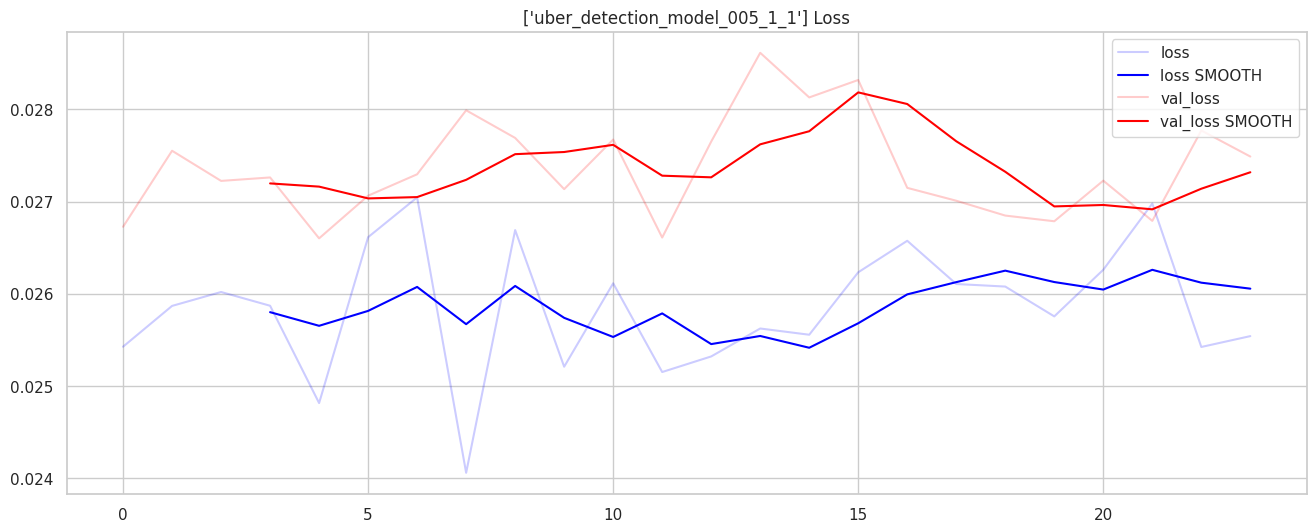

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


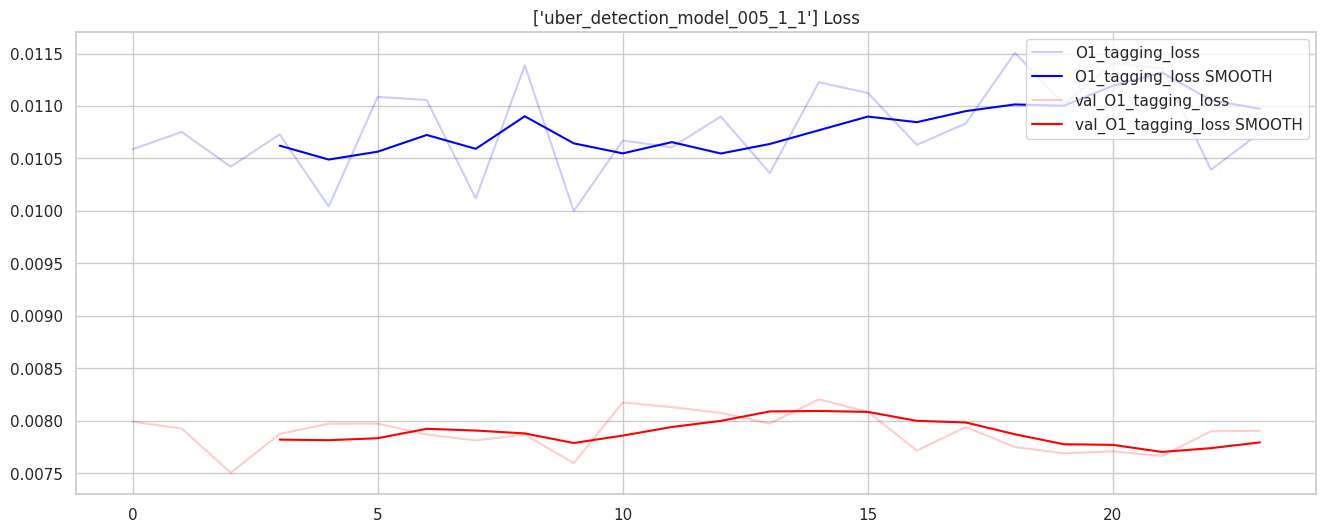

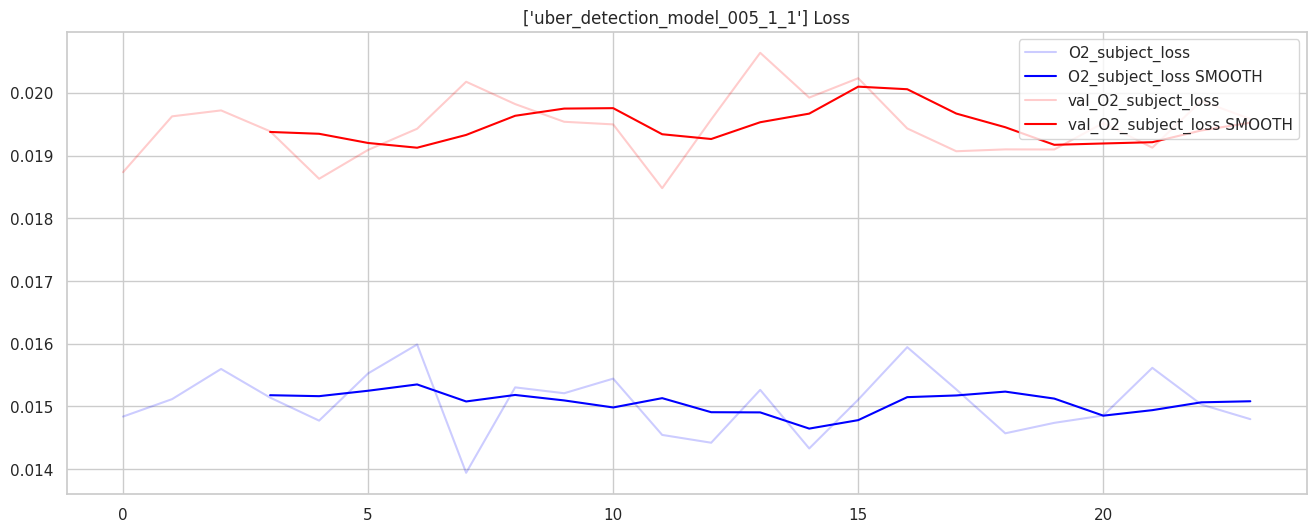

In [44]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.work_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [45]:
# umtm.stats
# semantic_map_keys_contract


5ec2b8da665f7603e03b1255


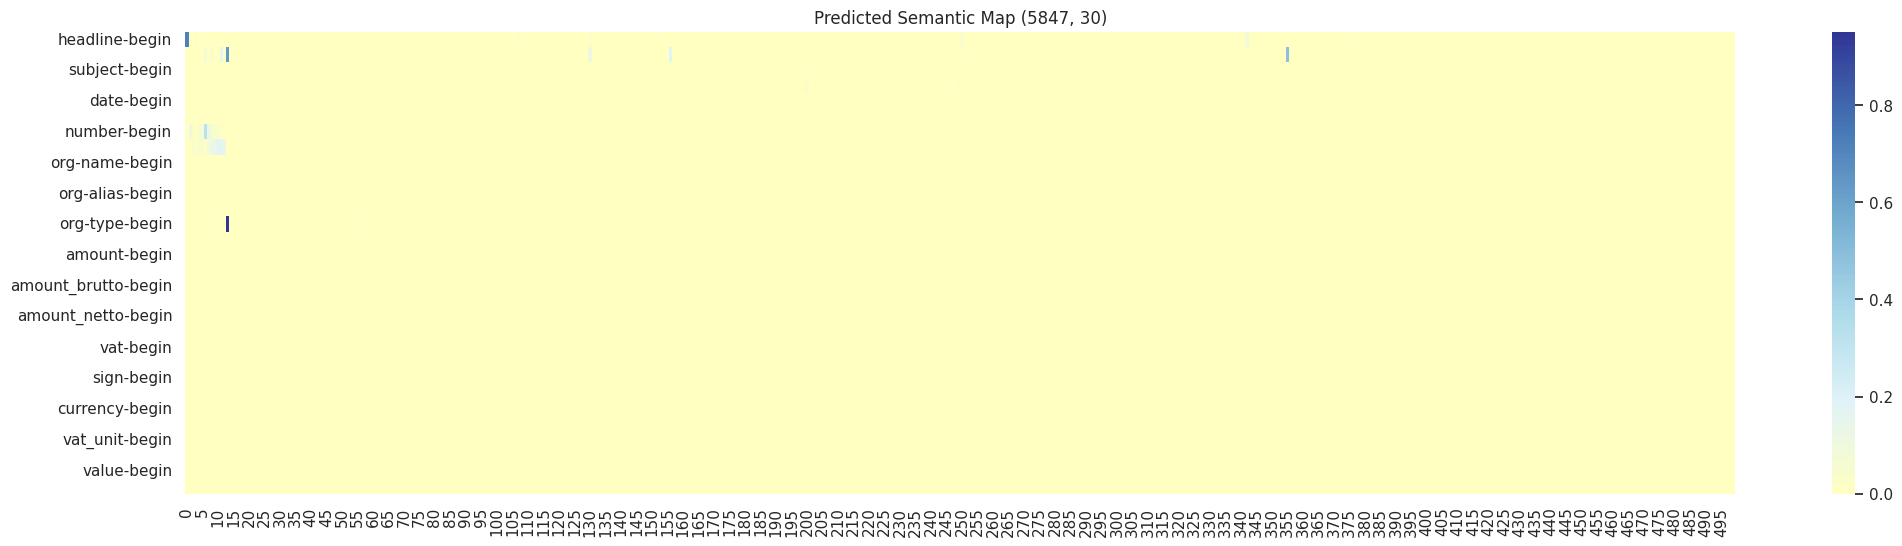

In [46]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [47]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [48]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'